**26. Детекция и распознавание объектов**
В данном ноутбуке планирую изучить баланс классов и ошибки в данных в датасете, найти пустые файлы с лейблами, подсчитать количество размеченных данных. Далее я попробую применить несколько методов аугментации данных, проверить различные способы аугментации и объяснить подходят ли они для выбранной задачи.

1.У нас есть датасет скачанный с сайта Roboflow Universe, он скачан в виде архива. Для начала разархивируем и посмотрим его содержимое.

In [34]:
%%capture
!unzip /content/drive/MyDrive/WeaponDetection.v5-weaponnet18k.yolov11.zip

Проведем анализ содержания датасета и подсчитаем количество файлов в папках тест, трейн и валид

In [2]:
import os
from collections import defaultdict

def analyze_directory(path):
    """
    Подсчитаем общее количество файлов
    и файлов каждого типа

    Аргументы:
    path (str): Путь к директории.
    """
    if not os.path.isdir(path):
        print(f"Ошибка: Директория не найдена по пути: {path}")
        return

    file_count = 0
    file_types = defaultdict(int)
    print(f"Сделаем анализ директории: {path}\n")

    # Используем os.walk для обхода всех файлов и поддиректорий
    for root, dirs, files in os.walk(path):
        for file in files:
            file_count += 1
            file_extension = os.path.splitext(file)[1].lower()
            if not file_extension:
                file_extension = "[без расширения]"
            file_types[file_extension] += 1

    print(f"Общее количество файлов: {file_count}\n")
    print("Количество файлов по типу:")
    for file_type, count in file_types.items():
        print(f"  - {file_type}: {count}")


# укажем пути к папкам
folder_path_test = '/content/test'
analyze_directory(folder_path_test)

folder_path_train = '/content/train'
analyze_directory(folder_path_train)

folder_path_valid = '/content/valid'
analyze_directory(folder_path_valid)

Сделаем анализ директории: /content/test

Общее количество файлов: 40

Количество файлов по типу:
  - .jpg: 20
  - .txt: 20
Сделаем анализ директории: /content/train

Общее количество файлов: 26564

Количество файлов по типу:
  - .jpg: 13282
  - .txt: 13282
Сделаем анализ директории: /content/valid

Общее количество файлов: 8044

Количество файлов по типу:
  - .jpg: 4022
  - .txt: 4022


Анализируем разрешение изображений в датасете

In [3]:

from PIL import Image

def get_image_resolution_stats(directory_path):

    if not os.path.isdir(directory_path):
        print(f"Ошибка: Директория не найдена по пути: {directory_path}")
        return {}

    resolution_stats = defaultdict(int)
    image_extensions = ('.jpg', '.jpeg', '.png', '.bmp', '.gif', '.tiff')

    # Использование os.walk для рекурсивного обхода всех файлов
    for root, _, files in os.walk(directory_path):
        for file in files:
            if file.lower().endswith(image_extensions):
                file_path = os.path.join(root, file)
                try:
                    with Image.open(file_path) as img:
                        width, height = img.size
                        resolution = f"{width}x{height}"
                        resolution_stats[resolution] += 1
                except Exception as e:
                    print(f"Не удалось прочитать изображение: {file_path}. Ошибка: {e}")


    return resolution_stats


# Укажем  путь к нашей папке
folder_path_test = '/content/test'
stats = get_image_resolution_stats(folder_path_test)

if stats:
    print("Статистика по разрешению изображений в тесте:")
    sorted_stats = sorted(stats.items(), key=lambda item: item[1], reverse=True)
    for resolution, count in sorted_stats:
        print(f"  - Разрешение {resolution}: {count} файлов")

Статистика по разрешению изображений в тесте:
  - Разрешение 275x183: 5 файлов
  - Разрешение 300x168: 3 файлов
  - Разрешение 259x194: 3 файлов
  - Разрешение 243x208: 1 файлов
  - Разрешение 918x651: 1 файлов
  - Разрешение 385x270: 1 файлов
  - Разрешение 254x198: 1 файлов
  - Разрешение 292x173: 1 файлов
  - Разрешение 225x225: 1 файлов
  - Разрешение 800x480: 1 файлов
  - Разрешение 249x202: 1 файлов
  - Разрешение 276x183: 1 файлов


In [33]:
%%capture
folder_path_train = '/content/train'
stats = get_image_resolution_stats(folder_path_train)

if stats:
    print("Статистика по разрешению изображений в трейне:")
    sorted_stats = sorted(stats.items(), key=lambda item: item[1], reverse=True)
    for resolution, count in sorted_stats:
        print(f"  - Разрешение {resolution}: {count} файлов")

In [35]:
%%capture
folder_path_valid = '/content/valid'
stats = get_image_resolution_stats(folder_path_valid)

if stats:
    print("Статистика по разрешению изображений в трейне:")
    sorted_stats = sorted(stats.items(), key=lambda item: item[1], reverse=True)
    for resolution, count in sorted_stats:
        print(f"  - Разрешение {resolution}: {count} файлов")

Исходя из этой статистики у нас большое количество изображений с разным разрешением, это неудобно при обучении модели. Модель быстрее обучается когда все изображения одинакового размера, что повышает ее точность,а  также снижает нагрузку на видеопамять.

Проведем ресайзинг изображений в датасете до разрешения 640х640

In [6]:

import numpy as np

def letterbox_resize(img_path, target_size=(640, 640)):
    """
    Изменим размер изображения с сохранением пропорций и добавлением черных полей.
    Возвращает изменённое изображение и параметры масштабирования/отступа.
    """
    img = Image.open(img_path).convert('RGB')
    orig_w, orig_h = img.size
    target_w, target_h = target_size

    scale = min(target_w / orig_w, target_h / orig_h)
    new_w = int(orig_w * scale)
    new_h = int(orig_h * scale)

    resized_img = img.resize((new_w, new_h), Image.LANCZOS)

    padded_img = Image.new('RGB', target_size, (128, 128, 128)) # Серый фон
    paste_x = (target_w - new_w) // 2
    paste_y = (target_h - new_h) // 2
    padded_img.paste(resized_img, (paste_x, paste_y))

    return padded_img, scale, paste_x, paste_y

def process_yolo_dataset(image_dir, label_dir, output_image_dir, output_label_dir, target_size=(640, 640)):

    os.makedirs(output_image_dir, exist_ok=True)
    os.makedirs(output_label_dir, exist_ok=True)

    for img_filename in os.listdir(image_dir):
        # Проверим, является ли файл изображением
        if img_filename.lower().endswith(('.jpg', '.jpeg', '.png')):
            img_path = os.path.join(image_dir, img_filename)
            label_filename = os.path.splitext(img_filename)[0] + '.txt'
            label_path = os.path.join(label_dir, label_filename)

            # Изменим размер изображения
            padded_img, scale, offset_x, offset_y = letterbox_resize(img_path, target_size)
            output_img_path = os.path.join(output_image_dir, img_filename)
            padded_img.save(output_img_path)

            # Корректировка аннотаций
            if os.path.exists(label_path):
                with open(label_path, 'r') as f_in, open(os.path.join(output_label_dir, label_filename), 'w') as f_out:
                    for line in f_in.readlines():
                        parts = line.strip().split()
                        class_id = int(parts[0])
                        x_center, y_center, width, height = map(float, parts[1:])

                        # Исходные размеры изображения
                        orig_w, orig_h = Image.open(img_path).size

                        # Вычислим новые координаты
                        new_x_center = (x_center * orig_w * scale + offset_x) / target_size[0]
                        new_y_center = (y_center * orig_h * scale + offset_y) / target_size[1]
                        new_width = width * orig_w * scale / target_size[0]
                        new_height = height * orig_h * scale / target_size[1]

                        # Запись скорректированных аннотаций в новый файл
                        f_out.write(f"{class_id} {new_x_center:.6f} {new_y_center:.6f} {new_width:.6f} {new_height:.6f}\n")


# укажем пути к папкам с изображениями и лейблами
input_image_dir = '/content/test/images'
input_label_dir = '/content/test/labels'
output_image_dir = './test_640x640/images'
output_label_dir = './test_640x640/labels'

process_yolo_dataset(input_image_dir, input_label_dir, output_image_dir, output_label_dir)

Теперь проверим сработал ли код для ресайзинга

In [7]:
folder_path_test640 = '/content/test_640x640'
stats = get_image_resolution_stats(folder_path_test640)

if stats:
    print("Статистика по разрешению изображений в тесте после ресайзинга:")
    sorted_stats = sorted(stats.items(), key=lambda item: item[1], reverse=True)
    for resolution, count in sorted_stats:
        print(f"  - Разрешение {resolution}: {count} файлов")

Статистика по разрешению изображений в тесте после ресайзинга:
  - Разрешение 640x640: 20 файлов


Код работает, ресайзинг проведен, все отлично.

In [8]:
# путь к папкам трейн
input_image_dir = '/content/train/images'
input_label_dir = '/content/train/labels'
output_image_dir = './train_640x640/images'
output_label_dir = './train_640x640/labels'

process_yolo_dataset(input_image_dir, input_label_dir, output_image_dir, output_label_dir)

In [9]:
# проверка ресайзинга
folder_path_train640 = '/content/train_640x640'
stats = get_image_resolution_stats(folder_path_train640)

if stats:
    print("Статистика по разрешению изображений в трейне после ресайзинга:")
    sorted_stats = sorted(stats.items(), key=lambda item: item[1], reverse=True)
    for resolution, count in sorted_stats:
        print(f"  - Разрешение {resolution}: {count} файлов")

Статистика по разрешению изображений в трейне после ресайзинга:
  - Разрешение 640x640: 13282 файлов


In [10]:
# путь к папкам валид
input_image_dir = '/content/valid/images'
input_label_dir = '/content/valid/labels'
output_image_dir = './valid_640x640/images'
output_label_dir = './valid_640x640/labels'

process_yolo_dataset(input_image_dir, input_label_dir, output_image_dir, output_label_dir)

In [11]:
# проверка ресайзинга
folder_path_valid640 = '/content/valid_640x640'
stats = get_image_resolution_stats(folder_path_valid640)

if stats:
    print("Статистика по разрешению изображений в валиде после ресайзинга:")
    sorted_stats = sorted(stats.items(), key=lambda item: item[1], reverse=True)
    for resolution, count in sorted_stats:
        print(f"  - Разрешение {resolution}: {count} файлов")

Статистика по разрешению изображений в валиде после ресайзинга:
  - Разрешение 640x640: 4022 файлов


После всех преобразований напишем структуру нашего датасета:
- Тест: 20 изображений и 20 лейблов.
- Трейн: 13 282 изображения и 13 282 лейбла.
- Валид: 4 022 изображения и 4 022 лейбла.

Для начала визуализируем лейблы на изображениях чтобы посмотреть на качество разметки, возьмем небольшую часть датасета. Для начала нам надо выяснить какие лейблы есть в датасете.Лейблы содержатся в файле data.yaml и нам надо его прочитать.  

In [12]:
import yaml

# Название файла в текущей директории
yaml_file_path = '/content/data.yaml'

try:
    with open(yaml_file_path, 'r') as file:
        config_data = yaml.safe_load(file)
        print("YAML-файл успешно прочитан.")
        print(config_data)

        # Доступ к конкретным значениям
        print("\nНастройки датасета:")
        print(f"Путь: {config_data['dataset']['path']}")
        print(f"Классы: {config_data['dataset']['names']}")

except FileNotFoundError:
    print(f"Ошибка: Файл '{yaml_file_path}' не найден.")
except Exception as e:
    print(f"Произошла ошибка при чтении файла: {e}")

YAML-файл успешно прочитан.
{'train': '../train/images', 'val': '../valid/images', 'test': '../test/images', 'nc': 2, 'names': ['Handgun', 'Rifle'], 'roboflow': {'workspace': 'xian-douglas', 'project': 'weapondetection-xx3lz', 'version': 5, 'license': 'CC BY 4.0', 'url': 'https://universe.roboflow.com/xian-douglas/weapondetection-xx3lz/dataset/5'}}

Настройки датасета:
Произошла ошибка при чтении файла: 'dataset'


После чтения данного файла мы видим следующее: nc': 2, 'names': ['Handgun', 'Rifle'], из чего мы можем сделать вывод, что в датасете два класса 0 (Handgun) и 1 (Rifle).



Код для визуализации лейблов на изображениях

In [13]:

import random
from PIL import Image, ImageDraw, ImageFont
import matplotlib.pyplot as plt

def visualize_yolo_labels(image_dir, label_dir, classes_file, output_dir, max_images=5):
    """
    Визуализирует бибоксы YOLO на изображениях.

    Аргументы:
        image_dir (str): Путь к папке с изображениями.
        label_dir (str): Путь к папке с файлами аннотаций YOLO.
        classes_file (str): Путь к файлу с названиями классов.
        output_dir (str): Путь для сохранения визуализированных изображений.
        max_images (int): Максимальное количество изображений для визуализации.
    """
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # Сделаем загрузку названий классов
    try:
        with open(classes_file, 'r') as f:
            class_names = [line.strip() for line in f.readlines()]
    except FileNotFoundError:
        print(f"Ошибка: Файл классов '{classes_file}' не найден.")
        return

    # Сделаем генерацию уникальных цветов для каждого класса
    num_classes = len(class_names)
    colors = plt.cm.get_cmap('hsv', num_classes)(np.linspace(0, 1, num_classes))
    colors = (colors[:, :3] * 255).astype(np.uint8) # Преобразование в формат RGB

    # Обработка изображений
    image_filenames = [f for f in os.listdir(image_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    random.shuffle(image_filenames)

    for i, img_filename in enumerate(image_filenames):
        if i >= max_images:
            break

        # Пути к файлам
        img_path = os.path.join(image_dir, img_filename)
        label_filename = os.path.splitext(img_filename)[0] + '.txt'
        label_path = os.path.join(label_dir, label_filename)

        if not os.path.exists(label_path):
            print(f"Предупреждение: Файл аннотаций для {img_filename} не найден.")
            continue

        try:
            # Открытие изображения
            img = Image.open(img_path).convert("RGB")
            draw = ImageDraw.Draw(img)
            width, height = img.size

            # Чтение аннотаций YOLO
            with open(label_path, 'r') as f:
                for line in f.readlines():
                    parts = line.strip().split()
                    class_id = int(parts[0])
                    x_center, y_center, bbox_width, bbox_height = map(float, parts[1:])

                    # Преобразование нормализованных координат YOLO в пиксельные
                    xmin = int((x_center - bbox_width / 2) * width)
                    ymin = int((y_center - bbox_height / 2) * height)
                    xmax = int((x_center + bbox_width / 2) * width)
                    ymax = int((y_center + bbox_height / 2) * height)

                    # Получение цвета и названия класса
                    color = tuple(colors[class_id])
                    label_text = class_names[class_id]

                    # Отрисовка ограничивающей рамки
                    draw.rectangle([xmin, ymin, xmax, ymax], outline=color, width=2)

                    # Отрисовка текста (названия класса)
                    try:
                        font = ImageFont.truetype("arial.ttf", 30) # Попытка использовать системный шрифт
                    except IOError:
                        font = ImageFont.load_default()

                    text_position = (xmin, ymin - 15 if ymin > 15 else ymin + 2)
                    draw.text(text_position, label_text, fill=color, font=font)

            # Сохранение визуализированного изображения
            output_path = os.path.join(output_dir, img_filename)
            img.save(output_path)
            print(f"Визуализировано и сохранено: {img_filename}")

        except Exception as e:
            print(f"Ошибка при обработке файла {img_filename}: {e}")


# укажем пути к файлам
image_folder = '/content/train_640x640/images'
label_folder = '/content/train_640x640/labels'
classes_txt = './classes.txt'
output_folder = './visualized_images'

visualize_yolo_labels(image_folder, label_folder, classes_txt, output_folder, max_images=20)

Визуализировано и сохранено: Em1Rifle176_jpeg.rf.a71558bc69e2c90116f2f0d7ce560404.jpg
Визуализировано и сохранено: DragunovSVD169_jpeg.rf.ab9a80675f72c07027c0bf6396910099.jpg
Визуализировано и сохранено: SoldierwithHKG3283_jpeg.rf.4f80d4b3a90d3f7ea5067309278f8349.jpg
Визуализировано и сохранено: CheyTacIntervention13_jpeg.rf.5d99ca8ff48ae8b5e91e70df70e21931.jpg
Визуализировано и сохранено: 1a65e2b61a31b040_jpg.rf.5872bab6c0040c7c04e30097587da38a.jpg
Визуализировано и сохранено: 612_jpg.rf.2fa7e8d71976cb5d5badac551126bd40.jpg
Визуализировано и сохранено: MilitaryarmedwithHandguns438_jpeg.rf.2af94fd06b724fea62f1cfaec9fd45c4.jpg
Визуализировано и сохранено: 297_jpg.rf.631aae9e65b4a588fdbe44130928aa4a.jpg
Визуализировано и сохранено: DSR1123_jpeg.rf.ca9b1146ffecaa749d9919c901d07f34.jpg
Визуализировано и сохранено: SIGSAUER328_jpeg_jpg.rf.1d13a276f820f180e0d2b79dbe30724f.jpg
Визуализировано и сохранено: 1853_jpg.rf.d6cd5a24add896aa77d12a3dac962da9.jpg
Визуализировано и сохранено: StG44414_j

/tmp/ipython-input-596126832.py:29: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('hsv', num_classes)(np.linspace(0, 1, num_classes))


Код для отображения изображений с лейблами

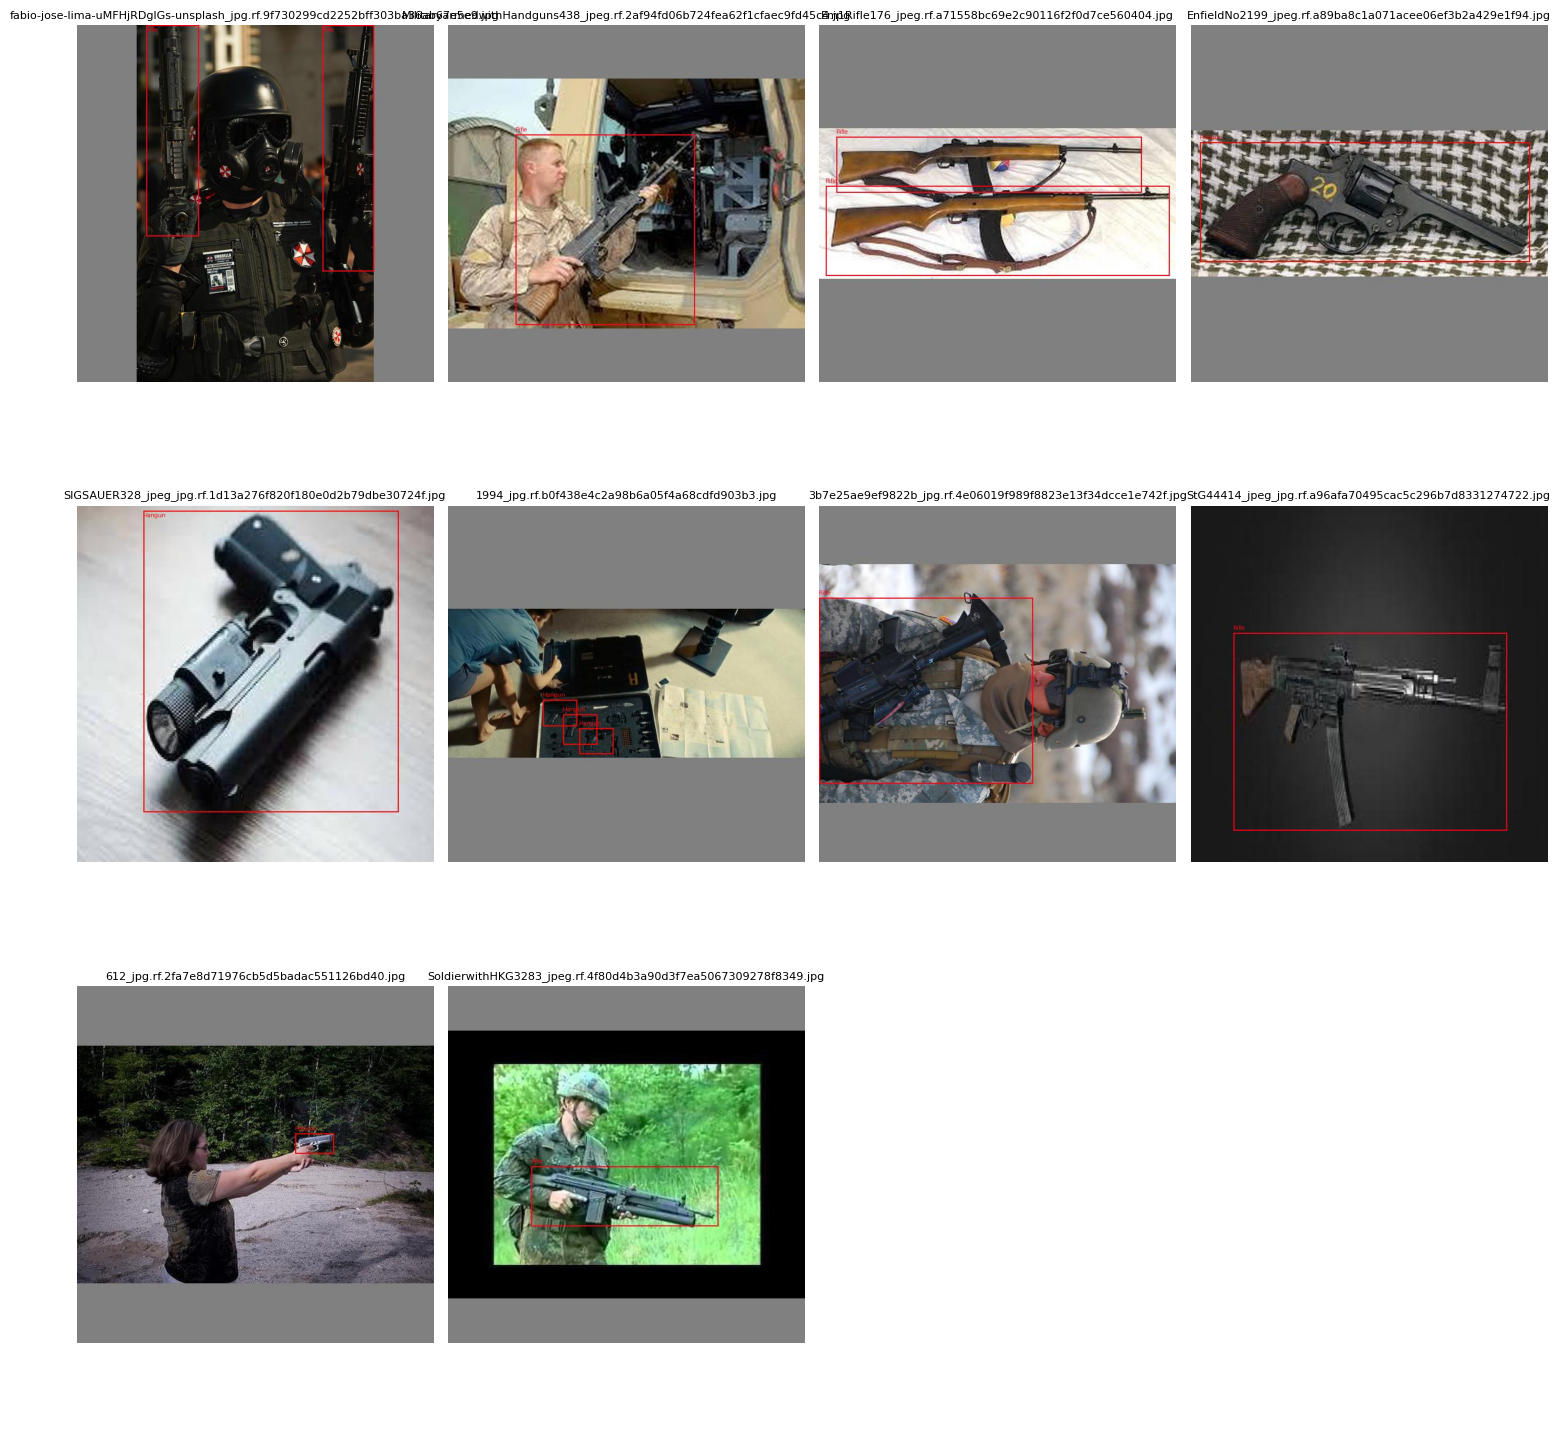

In [14]:


import matplotlib.pyplot as plt
from PIL import Image

def display_multiple_images(image_dir, num_images=10):
    """
    Отображает указанное количество случайных изображений из папки.

    Аргументы:
        image_dir (str): Путь к папке с изображениями.
        num_images (int): Количество изображений для отображения.
    """
    if not os.path.isdir(image_dir):
        print(f"Ошибка: Директория '{image_dir}' не найдена.")
        return

    # Получение списка всех файлов изображений
    image_filenames = [f for f in os.listdir(image_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp'))]

    if not image_filenames:
        print(f"Ошибка: В директории '{image_dir}' не найдено изображений.")
        return

    # Выбор случайных изображений
    selected_images = random.sample(image_filenames, min(num_images, len(image_filenames)))

    # Определение оптимальной сетки для отображения
    rows = int(num_images**0.5)
    cols = (num_images + rows - 1) // rows

    fig, axes = plt.subplots(rows, cols, figsize=(15, 15))
    axes = axes.flatten()

    for i, img_filename in enumerate(selected_images):
        img_path = os.path.join(image_dir, img_filename)
        try:
            img = Image.open(img_path)
            ax = axes[i]
            ax.imshow(img)
            ax.set_title(img_filename, fontsize=8)
            ax.axis('off')
        except Exception as e:
            print(f"Ошибка при загрузке или отображении {img_filename}: {e}")
            ax = axes[i]
            ax.set_title(f"Ошибка: {img_filename}", fontsize=8)
            ax.axis('off')

    # Скрытие пустых осей, если количество изображений меньше, чем размер сетки
    for j in range(len(selected_images), len(axes)):
        axes[j].axis('off')

    plt.tight_layout() # Автоматическая регулировка подокнов
    plt.show()

# укажем путь
image_folder_path = '/content/visualized_images'
display_multiple_images(image_folder_path, num_images=10)

Как мы видим из визуализации, некоторые лейблы могут быть расположены на краю изображения или занимать меньше 5-10 % от размера всего изображения, что может ухудшить качество обучения модели. Для решения данной проблемы можно применить метод изоляции бибоксов в отдельные изображения для центрирования бибокса


Подсчитаем количество лейблов каждого класса в датасете и посмотрим на их соотношение

In [15]:


def count_yolo_labels(label_dir):
    """
    Подсчитывает количество меток классов 0 и 1 в файлах аннотаций YOLO.

    Аргумент:
        label_dir (str): Путь к папке, содержащей текстовые файлы с метками.

    Возвращает:
        dict: Словарь с подсчитанным количеством для каждой метки.
    """
    label_counts = defaultdict(int)

    # Проверка существования директории
    if not os.path.isdir(label_dir):
        print(f"Ошибка: Директория '{label_dir}' не найдена.")
        return label_counts

    # Обход всех файлов в директории
    for filename in os.listdir(label_dir):
        if filename.endswith('.txt'):
            label_path = os.path.join(label_dir, filename)
            try:
                with open(label_path, 'r') as f:
                    for line in f:
                        parts = line.strip().split()
                        if parts:
                            class_id = parts[0]
                            # Увеличиваем счётчик для метки
                            if class_id in ['0', '1']:
                                label_counts[class_id] += 1
            except Exception as e:
                print(f"Ошибка при чтении файла {filename}: {e}")

    return label_counts

# укажем путь
labels_folder = '/content/test_640x640/labels'
counts = count_yolo_labels(labels_folder)

if counts:
    print("Результаты подсчёта лейблов в тесте 640*640:")
    for label, count in counts.items():
        print(f"  - Лейбл {label} : {count}")

    total_found = counts.get('0', 0) + counts.get('1', 0)
    print(f"\nОбщее количество лейблов 0 и 1: {total_found}")
else:
    print("Не найдено меток 0 или 1.")

Результаты подсчёта лейблов в тесте 640*640:
  - Лейбл 0 : 18
  - Лейбл 1 : 3

Общее количество лейблов 0 и 1: 21


In [16]:


labels_folder = '/content/train_640x640/labels'
counts = count_yolo_labels(labels_folder)

if counts:
    print("Результаты подсчёта лейблов в трейне 640*640:")
    for label, count in counts.items():
        print(f"  - Лейбл {label} : {count}")

    total_found = counts.get('0', 0) + counts.get('1', 0)
    print(f"\nОбщее количество лейблов 0 и 1: {total_found}")
else:
    print("Не найдено меток 0 или 1.")

Результаты подсчёта лейблов в трейне 640*640:
  - Лейбл 1 : 8942
  - Лейбл 0 : 6977

Общее количество лейблов 0 и 1: 15919


In [17]:


labels_folder = '/content/valid_640x640/labels'
counts = count_yolo_labels(labels_folder)

if counts:
    print("Результаты подсчёта лейблов в валиде 640*640:")
    for label, count in counts.items():
        print(f"  - Лейбл {label} : {count}")

    total_found = counts.get('0', 0) + counts.get('1', 0)
    print(f"\nОбщее количество лейблов 0 и 1: {total_found}")
else:
    print("Не найдено меток 0 или 1.")

Результаты подсчёта лейблов в валиде 640*640:
  - Лейбл 0 : 2156
  - Лейбл 1 : 2540

Общее количество лейблов 0 и 1: 4696


Исходя из даннной статистики мы можем сделать вывод, что у нас примерно равномерное соотшение классов 0 (Handgun) и 1 (Rifle) в трейне и валиде

Теперь найдем пустые txt файлы в папке с лейблами

In [18]:


def find_empty_txt_files(directory_path):
    """
    Находит все пустые .txt файлы в указанной директории и её поддиректориях.

    Аргумент:
        directory_path (str): Путь к директории для поиска.

    Возвращает:
        list: Список полных путей к пустым файлам.
    """
    if not os.path.isdir(directory_path):
        print(f"Ошибка: Директория '{directory_path}' не найдена.")
        return []

    empty_files = []

    # Рекурсивный обход всех файлов и поддиректорий
    for root, dirs, files in os.walk(directory_path):
        for filename in files:
            # Проверка, является ли файл текстовым
            if filename.lower().endswith('.txt'):
                file_path = os.path.join(root, filename)

                # Проверка размера файла
                try:
                    if os.path.getsize(file_path) == 0:
                        empty_files.append(file_path)
                except OSError as e:
                    print(f"Предупреждение: Не удалось проверить файл {file_path}. Ошибка: {e}")

    return empty_files

# укажем путь
labels_folder = '/content/test_640x640/labels'
empty_txts = find_empty_txt_files(labels_folder)

if empty_txts:
    print(f"Найдено {len(empty_txts)} пустых .txt файлов:")
    for file in empty_txts:
        print(f"  - {file}")
else:
    print(f"В директории '{labels_folder}' не найдено пустых .txt файлов.")

В директории '/content/test_640x640/labels' не найдено пустых .txt файлов.


In [36]:
%%capture
# укажем путь
labels_folder = '/content/train_640x640/labels'
empty_txts = find_empty_txt_files(labels_folder)

if empty_txts:
    print(f"Найдено {len(empty_txts)} пустых .txt файлов:")
    for file in empty_txts:
        print(f"  - {file}")
else:
    print(f"В директории '{labels_folder}' не найдено пустых .txt файлов.")

In [38]:
%%capture
# укажем путь
labels_folder = '/content/valid_640x640/labels'
empty_txts = find_empty_txt_files(labels_folder)

if empty_txts:
    print(f"Найдено {len(empty_txts)} пустых .txt файлов:")
    for file in empty_txts:
        print(f"  - {file}")
else:
    print(f"В директории '{labels_folder}' не найдено пустых .txt файлов.")

Исходя из проделанной работы делаем вывод, что в датасете очень много пустых txt файлов с лейблами:
 - В трейне найдено 793 пустых txt файлов
 - В валиде найдено 238 пустых txt файлов
 - В тесте не найдено пустых txt файлов c лейблами

Проведем удаление пустых файлов с лейблами и соответствующих им изображений из папки трейн

In [83]:
# @title

files_to_remove = [
  '- /content/train_640x640/labels/images---2020-10-23T133454-859_jpeg_jpg.rf.6ef5993d96053419bbd5743d9b858b88.txt',
  '- /content/train_640x640/labels/SoldierwithRPG7110_jpeg.rf.623d3b3c7cde6fd758970adee1036222.txt',
  '- /content/train_640x640/labels/SoldierwithRPG7272_jpeg.rf.7c38da8725692c5f76cbd9953a0dce58.txt',
  '- /content/train_640x640/labels/images235_jpeg_jpg.rf.a910649a576569c139e93e3b1ee9f776.txt',
  '- /content/train_640x640/labels/download--8-_jpeg_jpg.rf.cc87714f6d7ecc4653e6de6cdb6f841e.txt',
  '- /content/train_640x640/labels/M72LAW15_jpeg.rf.8ae519ef942c347dd1b7d1f379c5dd0f.txt',
  '- /content/train_640x640/labels/SoldierwithChinaLake226_jpeg.rf.981b27119c56509f1feab5222d423bd7.txt',
  '- /content/train_640x640/labels/Bazooka199_jpeg.rf.b96514cd9151478a67dba7db805ec48a.txt',
  '- /content/train_640x640/labels/M72LAW150_jpeg.rf.4a8f54247b31001cd099cdbbef6b81e4.txt',
  '- /content/train_640x640/labels/Bazooka52_jpeg.rf.7eed51704e8e550625379c3fcbf95983.txt',
  '- /content/train_640x640/labels/JavelineLauncher176_jpeg.rf.139e367737a4c3e602a4fb9a2ef1e4ca.txt',
  '- /content/train_640x640/labels/SoldierwithRPG7430_jpeg.rf.d38d64f676f6df3c3b90f25651a8800d.txt',
  '- /content/train_640x640/labels/SoldierwithRPG799_jpeg.rf.ae0f4611b297b768ef71ceac30e5cc99.txt',
  '- /content/train_640x640/labels/SoldierwithGrenadeLauncher166---Copy_jpeg.rf.9b0a8cb74575ce7f2b24978e15f38d29.txt',
  '- /content/train_640x640/labels/PersonwithMilkorMGL35_jpeg.rf.22fc00339308586a2e9d297cefecc5ec.txt',
  '- /content/train_640x640/labels/1e325c47de2bbc31_jpg.rf.cdbb5f6b0d14ed3743c7cb63caf1c0d0.txt',
  '- /content/train_640x640/labels/DragunovSVU319_jpeg.rf.c291bde271ae273a239e3f32f2585d3a.txt',
  '- /content/train_640x640/labels/SoldierwithGrenadeLauncher612_jpeg.rf.6dd32e079078f25130be57f8bddb6a25.txt',
  '- /content/train_640x640/labels/M72LAW134_jpeg.rf.aae574053750d0d7537f87f8ca36818f.txt',
  '- /content/train_640x640/labels/SoldierwithGrenadeLauncher172---Copy_jpeg.rf.a03a7e825abf07cb0a5982fc5f6f1062.txt',
  '- /content/train_640x640/labels/download--5-_jpeg_jpg.rf.11e54705f2c4974df38210d3fdd1f5af.txt',
  '- /content/train_640x640/labels/images--83-_jpeg_jpg.rf.8150f7b8e48014009aa2481ba39674cc.txt',
  '- /content/train_640x640/labels/SoldierwithRPG7166_jpeg.rf.8f18a326b9320e213154cf7fe47c33b4.txt',
  '- /content/train_640x640/labels/SoldierwithMatadorLauncher52_jpeg.rf.a21f12ca07bd2be01067dc7a3f958f68.txt',
  '- /content/train_640x640/labels/Bazooka1_jpeg.rf.dcf8a507cf24ad2f48d19047c7f1a424.txt',
  '- /content/train_640x640/labels/JavelineLauncher292_jpeg.rf.d56236523d014d27034ea34e24ba7c4d.txt',
  '- /content/train_640x640/labels/images---2020-10-23T133454-696_jpeg_jpg.rf.17218074cb2761a1fb655c371a8dc97b.txt',
  '- /content/train_640x640/labels/JavelineLauncher80_jpeg.rf.43b2b7e73050812b0662a186f0a73d81.txt',
  '- /content/train_640x640/labels/images--18-_jpeg_jpg.rf.ccaf588057c3e145289921eea5bf0db7.txt',
  '- /content/train_640x640/labels/images231_jpeg_jpg.rf.078429fb4fe7ffa182f9fcac5d6a4a8c.txt',
  '- /content/train_640x640/labels/SoldierwithChinaLake173_jpeg.rf.74912b7a7516f03a5bfb80d0744164a6.txt',
  '- /content/train_640x640/labels/SoldierwithRPG7261_jpeg.rf.9844339b7ba3cb7fb5799a5d8138501f.txt',
  '- /content/train_640x640/labels/download--23-_jpeg_jpg.rf.f0fab80a5e4edaced85120ea011077db.txt',
  '- /content/train_640x640/labels/M72LAW171_jpeg.rf.b7451a0575d2a4e92b7c441c6434894e.txt',
  '- /content/train_640x640/labels/PersonwithRPG78_jpeg.rf.0b1bb4016f4c8a651ddf5d1c5fa9e530.txt',
  '- /content/train_640x640/labels/peopleholdingrifles823_jpeg_jpg.rf.84882977b533e8dd401d880aea9978dd.txt',
  '- /content/train_640x640/labels/a807e3952fb67082_jpg.rf.f21ebb4ef0294eb5446b2bdfae3740fc.txt',
  '- /content/train_640x640/labels/SoldierwithRPG720_jpeg.rf.7a50313882fefebfa606a641630936a5.txt',
  '- /content/train_640x640/labels/images262_jpeg_jpg.rf.ba544d36dcd2b4cdcac58f369db67d50.txt',
  '- /content/train_640x640/labels/SoldierwithRPG7304_jpeg.rf.dcaa3714e50f1b0c40aba9994a473e9a.txt',
  '- /content/train_640x640/labels/images---2020-10-23T133454-862_jpeg_jpg.rf.538b945986ad89352493352564fd8c2c.txt',
  '- /content/train_640x640/labels/SoldierwithChinaLake159_jpeg.rf.e83a9554d8c9e40fc857770e54b9d9c7.txt',
  '- /content/train_640x640/labels/images--89-_jpeg_jpg.rf.f5dddb68c93a34b9f271b44ae38adb8a.txt',
  '- /content/train_640x640/labels/M202A1FLASH3_jpeg.rf.efca24cc35673393e546a3369843bba7.txt',
  '- /content/train_640x640/labels/images271_jpeg_jpg.rf.b6fce8cd9b50d81ca6392c9b6b5c5809.txt',
  '- /content/train_640x640/labels/RocketLauncherPerson13_jpeg.rf.15e121fece56241b07701ba2c2cd4a92.txt',
  '- /content/train_640x640/labels/images283_jpeg_jpg.rf.eddb6b7fdd7c7f8e580daeeb142205fb.txt',
  '- /content/train_640x640/labels/SoldierwithRPG7162_jpeg.rf.f0522c6f0207e1ff721568e5a3bbb687.txt',
  '- /content/train_640x640/labels/RocketLauncherPerson200_jpeg.rf.cec62b4f031c5e222f86ef82c6904731.txt',
  '- /content/train_640x640/labels/SoldierwithRPG7400_jpeg.rf.024573e78bbfaca97b0d1a9f47fbb67f.txt',
  '- /content/train_640x640/labels/Bazooka15_jpeg.rf.763313328a5a0a30985308a4e303bf9c.txt',
  '- /content/train_640x640/labels/images--95-_jpeg_jpg.rf.faf1ce69dee958059278b38b3b4b314f.txt',
  '- /content/train_640x640/labels/SoldierwithM202A1FLASH1_jpeg.rf.d6f7ce9ce2fe85b252c60c6c56ea953e.txt',
  '- /content/train_640x640/labels/images282_jpeg_jpg.rf.27579db5a591646a51140d8d32edf4ec.txt',
  '- /content/train_640x640/labels/SoldierwithGrenadeLauncher375_jpeg.rf.95c8d17f2cb399fb1cc35e66453c58d7.txt',
  '- /content/train_640x640/labels/PersonwithMatadorLauncher34_jpeg.rf.45d4d00a3e2beeeaa3306e7914aef8df.txt',
  '- /content/train_640x640/labels/images--3-_jpeg_jpg.rf.918309286635a598f04bf49ad37f08f0.txt',
  '- /content/train_640x640/labels/SoldierwithGrenadeLauncher56---Copy_jpeg.rf.6c33aac41c6ab5c6db1ac6c120205655.txt',
  '- /content/train_640x640/labels/PersonwithRPG736_jpeg.rf.ad8acaa6bf3b68e047da77287f023c2b.txt',
  '- /content/train_640x640/labels/images--85-_jpeg_jpg.rf.7a79774cd0d6b4e4ab66d45d086d0a55.txt',
  '- /content/train_640x640/labels/images101_jpeg_jpg.rf.68e3c5af5f8c3d027b2d4eff1938920f.txt',
  '- /content/train_640x640/labels/SoldierwithChinaLake227_jpeg.rf.c757883e5f9f0df4c0434e40a8570cad.txt',
  '- /content/train_640x640/labels/peopleholdingrifles728_jpeg_jpg.rf.cd4bf4d2d147aedc542ec5769146608c.txt',
  '- /content/train_640x640/labels/JavelineLauncher363_jpeg.rf.2334ec6cb18b517921dd47032eabd8b5.txt',
  '- /content/train_640x640/labels/SoldierwithRPG7377_jpeg.rf.5f98ff9b8de265adfcf05f45f4ef649c.txt',
  '- /content/train_640x640/labels/JavelineLauncher11_jpeg.rf.b5bfc54d53bbd3041e91fe95f6c1a557.txt',
  '- /content/train_640x640/labels/JavelineLauncher221_jpeg.rf.16590c77fdaef47c7a5074889c5960ad.txt',
  '- /content/train_640x640/labels/PersonwithRPG792_jpeg.rf.3dd1ccb22e7848f7b5dc49a644d94ec2.txt',
  '- /content/train_640x640/labels/M72LAW29_jpeg.rf.3ec093edad05eae8142b38768578355b.txt',
  '- /content/train_640x640/labels/images--2-_jpeg_jpg.rf.55cbd7d2ebd335e0598e6813c6c1f71b.txt',
  '- /content/train_640x640/labels/SoldierwithRocketLauncher26_jpeg.rf.2a99b613bfd3f9fbc5557cd49f5d6f3c.txt',
  '- /content/train_640x640/labels/images242_jpeg_jpg.rf.4f33c5ab19480eb57021e84de6bc4831.txt',
  '- /content/train_640x640/labels/images---2020-10-23T133454-874_jpeg_jpg.rf.9a681c168640969eff7050442f4483fc.txt',
  '- /content/train_640x640/labels/SoldierwithChinaLake521_jpeg.rf.ff1bfc397dcf75e5f54f0a4368c5c429.txt',
  '- /content/train_640x640/labels/SoldierwithMilkorMGL38_jpeg.rf.4f1b547ca3ee3754110e3e8e30723c76.txt',
  '- /content/train_640x640/labels/SoldierwithRPG7156_jpeg.rf.9d5643af9a457beb2790c17982c7abdc.txt',
  '- /content/train_640x640/labels/SoldierwithGrenadeLauncher113---Copy_jpeg.rf.1283daf7897c0d5ff4bc7c3decd6d4c9.txt',
  '- /content/train_640x640/labels/SoldierwithMilkorMGL53_jpeg.rf.bdec0a6886b3a315f6f6457212f86ee3.txt',
  '- /content/train_640x640/labels/SoldierwithMatadorLauncher94_jpeg.rf.044378dd603b63bc039ecffcf37b5177.txt',
  '- /content/train_640x640/labels/images--7-_jpeg_jpg.rf.a4e1c867541e27ca4d76873a0bd6a254.txt',
  '- /content/train_640x640/labels/RocketLauncherPerson78_jpeg.rf.879d38964cea575abfb2c512ea53e1fc.txt',
  '- /content/train_640x640/labels/5dbf40a876f2dbe4_jpg.rf.5b66a8af5a7705d78452d41f50112945.txt',
  '- /content/train_640x640/labels/SoldierwithRPG7458_jpeg.rf.3d913b13b0870dfa08b106335ea777d4.txt',
  '- /content/train_640x640/labels/download--16-_jpeg_jpg.rf.5ea209972f2f62f5c7dc69131d2d64a6.txt',
  '- /content/train_640x640/labels/images---2020-10-23T133454-873_jpeg_jpg.rf.bb946620e8c82ae29546dfa1e7457eee.txt',
  '- /content/train_640x640/labels/547c656cfe525588_jpg.rf.e93fa216a267ce00dbc13069a97246b6.txt',
  '- /content/train_640x640/labels/images--53-_jpeg_jpg.rf.deac1125436e3664c67a92f5947d2df4.txt',
  '- /content/train_640x640/labels/SoldierwithGrenadeLauncher1---Copy_jpeg.rf.8899078f450af43398fcf5c61a77ebdf.txt',
  '- /content/train_640x640/labels/JavelineLauncher144_jpeg.rf.6721f3706fa7afc9aa20cef36145aaa3.txt',
  '- /content/train_640x640/labels/PersonwithMilkorMGL56_jpeg.rf.9e3489842158677a66a5cfb492efd2fc.txt',
  '- /content/train_640x640/labels/SoldierwithRocketLauncher20_jpeg.rf.16bd9e2f60c70c3f2162ff3248db2d4d.txt',
  '- /content/train_640x640/labels/SoldierwithMatadorLauncher78_jpeg.rf.4ec5fa58cab89ef77c16141a49a8c78c.txt',
  '- /content/train_640x640/labels/SoldierwithMilkorMGL45_jpeg.rf.0f699ae95bad19a1c3d4483afc5c13b8.txt',
  '- /content/train_640x640/labels/RocketLauncherPerson34_jpeg.rf.8c1bb243fd83031304d83ab347721656.txt',
  '- /content/train_640x640/labels/images--65-_jpeg_jpg.rf.a627bf610260b215d8e2f2a59e4c6a9e.txt',
  '- /content/train_640x640/labels/images248_jpeg_jpg.rf.082293fd08979b392949d2b2ea77b293.txt',
  '- /content/train_640x640/labels/SoldierwithMatadorLauncher80_jpeg.rf.865de14d4765df5fee4a377c6479b38f.txt',
  '- /content/train_640x640/labels/JavelineLauncher178_jpeg.rf.8653b578f14fb2a444f187e34dd79a32.txt',
  '- /content/train_640x640/labels/RocketLauncherPerson113_jpeg.rf.3f0e13a1faec3a3f72a68490889c3341.txt',
  '- /content/train_640x640/labels/SoldierwithGrenadeLauncher156---Copy_jpeg.rf.bd8f99692ed9e030deb091e026def5f4.txt',
  '- /content/train_640x640/labels/DragunovSVU308_jpeg.rf.b606dab3230b3ebaf922bf095ff9bfc8.txt',
  '- /content/train_640x640/labels/images266_jpeg_jpg.rf.b6e27580e89197845c217ef8cc48d94f.txt',
  '- /content/train_640x640/labels/SoldierwithGrenadeLauncher467_jpeg.rf.2a8ee107397291185f8efcd98af8339b.txt',
  '- /content/train_640x640/labels/SoldierwithRPG725_jpeg.rf.96f8f47491f4b7174d32d2fb2aca0f98.txt',
  '- /content/train_640x640/labels/SoldierwithRPG7284_jpeg.rf.79bf62fef2987db948e092a0ef2688d3.txt',
  '- /content/train_640x640/labels/SoldierwithChinaLake209_jpeg.rf.77a7d3afdf29577f05cffbce5977e304.txt',
  '- /content/train_640x640/labels/SoldierwithChinaLake489_jpeg.rf.24bdda6d310784621100da0447b83b85.txt',
  '- /content/train_640x640/labels/download_jpeg_jpg.rf.c66a28d74a52291a8656841800da71f7.txt',
  '- /content/train_640x640/labels/SoldierwithGrenadeLauncher448_jpeg.rf.892b8f0106d0733adb006f7aef4227d8.txt',
  '- /content/train_640x640/labels/images250_jpeg_jpg.rf.0ac46d327371583d04214bd2d2e12921.txt',
  '- /content/train_640x640/labels/DSR1278_jpeg.rf.f119c3cab5fd3b670767f01e6cc70b5a.txt',
  '- /content/train_640x640/labels/download--14-_jpeg_jpg.rf.7e52a0bff04d26c32b49890c18d602a3.txt',
  '- /content/train_640x640/labels/images---2020-10-23T133454-751_jpeg_jpg.rf.c68d9660e9688c183ae12b1544150e58.txt',
  '- /content/train_640x640/labels/SoldierwithMatadorLauncher63_jpeg.rf.233f1947656cf6cbfb1d42f211369a87.txt',
  '- /content/train_640x640/labels/SoldierwithGrenadeLauncher362_jpeg.rf.ad12255107fb01b70051f6dafc7c94d8.txt',
  '- /content/train_640x640/labels/JavelineLauncher68_jpeg.rf.4ef937a4f020bb2ab90f649ec656ab58.txt',
  '- /content/train_640x640/labels/images--17-_jpeg_jpg.rf.4d1e79674463f94be84bc09dff8790f9.txt',
  '- /content/train_640x640/labels/images--80-_jpeg_jpg.rf.7cb35c2aad876811dbb501d2c22d6a43.txt',
  '- /content/train_640x640/labels/DragunovSVD349_jpeg.rf.70e0e017060e4d866b5e72217f53f2f2.txt',
  '- /content/train_640x640/labels/SoldierwithRPG7159_jpeg.rf.7fcecb6da547630bff8507f029a36c65.txt',
  '- /content/train_640x640/labels/SoldierwithGrenadeLauncher187---Copy_jpeg.rf.3c5f956798b469592cc2306a1e56f50d.txt',
  '- /content/train_640x640/labels/images215_jpeg_jpg.rf.66c721e5932df2d2a2665df37e9e3a37.txt',
  '- /content/train_640x640/labels/download--2-_jpeg_jpg.rf.4503621965cdf184ac36752123a7c465.txt',
  '- /content/train_640x640/labels/SoldierwithRPG721_jpeg.rf.1a4d4b7ea2f985acf1dc1c6ef5368fbc.txt',
  '- /content/train_640x640/labels/M72LAW57_jpeg.rf.a4fa3bb6354c81c01e3dbe1257a608de.txt',
  '- /content/train_640x640/labels/images--81-_jpeg_jpg.rf.680efe96fbb08e932ff1988d7d9da123.txt',
  '- /content/train_640x640/labels/images216_jpeg_jpg.rf.81e26ac5f0d6a5de82c05b4e3db6e70b.txt',
  '- /content/train_640x640/labels/images--66-_jpeg_jpg.rf.312102c3c2c8a7419df276fd96df0347.txt',
  '- /content/train_640x640/labels/M72LAW141_jpeg.rf.2b57b01ce7522f4b2b74381baf60ee0f.txt',
  '- /content/train_640x640/labels/DragunovSVD469_jpeg.rf.93d5b921b043150feddaa067ffc2e1d6.txt',
  '- /content/train_640x640/labels/download--22-_jpeg_jpg.rf.ed50bc5ec3612f5e1bb1e839c4446a18.txt',
  '- /content/train_640x640/labels/JavelineLauncher22_jpeg.rf.6da6f46267af23599be8adfca3ccd975.txt',
  '- /content/train_640x640/labels/M202A1FLASH131_jpeg.rf.546910978601a2541832323af1df488d.txt',
  '- /content/train_640x640/labels/images--31-_jpeg_jpg.rf.3deb727e7c6b63123dd8ca806a00e7ea.txt',
  '- /content/train_640x640/labels/SoldierwithRPG7171_jpeg.rf.c33115bff34648bbca0767bdcb4ea8ac.txt',
  '- /content/train_640x640/labels/SoldierwithRPG710_jpeg.rf.11067c29923273e01db4d18195404d2b.txt',
  '- /content/train_640x640/labels/images264_jpeg_jpg.rf.224b76b530addd1934afdaf9e71cb941.txt',
  '- /content/train_640x640/labels/JavelineLauncher66_jpeg.rf.5f906924e2fe5afbe30508a8006fad14.txt',
  '- /content/train_640x640/labels/Bazooka326_jpeg.rf.709efbbca5658debc296dd80639633ad.txt',
  '- /content/train_640x640/labels/JavelineLauncher155_jpeg.rf.973eb9d676d94341f8f7a3d976cf9011.txt',
  '- /content/train_640x640/labels/images280_jpeg_jpg.rf.f3ffad6984bb969f4db56d08e65f934a.txt',
  '- /content/train_640x640/labels/M72LAW12_jpeg.rf.1dabfc2748e25c710d2dcf9762171294.txt',
  '- /content/train_640x640/labels/PersonwithRPG732_jpeg.rf.affbcf5713527e548d34c11baa71c921.txt',
  '- /content/train_640x640/labels/images--91-_jpeg_jpg.rf.3ce17bf7f9126a580fa1c98a462ad0eb.txt',
  '- /content/train_640x640/labels/JavelineLauncher64_png.rf.c5b8cc20ac806e34695daeaed839e6bb.txt',
  '- /content/train_640x640/labels/SoldierwithRPG7101_jpeg.rf.d939b02ac70f03f083bf7dba80c96a3a.txt',
  '- /content/train_640x640/labels/PersonwithM202A1FLASH165_jpeg.rf.7a016658f3ef8582001c330114e3505c.txt',
  '- /content/train_640x640/labels/images--47-_jpeg_jpg.rf.e5e7c9372ab2fe74d629675936f14ad6.txt',
  '- /content/train_640x640/labels/JavelineLauncher356_jpeg.rf.2ab29b1963b7af5e26436e8418258a5f.txt',
  '- /content/train_640x640/labels/ad07bcc0e2563594_jpg.rf.53dbfac8b8caa6d295fbc7e92bab42ac.txt',
  '- /content/train_640x640/labels/Bazooka196_jpeg.rf.bfeb0229fdf104a8ee317c56f27323c6.txt',
  '- /content/train_640x640/labels/JavelineLauncher129_jpeg.rf.c133bf8c540af4897d8eb2f8a3476b1f.txt',
  '- /content/train_640x640/labels/images--44-_jpeg_jpg.rf.8bdbd7229e4bc413d9008c8dda5e9d93.txt',
  '- /content/train_640x640/labels/PersonwithMilkorMGL156_jpeg.rf.6d67b17004ce3bc7dd7b3e9c5e57f5fb.txt',
  '- /content/train_640x640/labels/images288_jpeg_jpg.rf.9b6894b9c7a36493a2b5a43f062efda9.txt',
  '- /content/train_640x640/labels/DragunovSVU62_jpeg.rf.4d293ad1475abcc884cdeb1509557127.txt',
  '- /content/train_640x640/labels/images--94-_jpeg_jpg.rf.2ca21b4f0c904d64a0afb4f3b6f7b916.txt',
  '- /content/train_640x640/labels/download--7-_jpeg_jpg.rf.c155fed021fa144d0cd0290c2de263a5.txt',
  '- /content/train_640x640/labels/PersonwithMilkorMGL149_jpeg.rf.08a0569be8272cac8c127dc5a0b13cf3.txt',
  '- /content/train_640x640/labels/SoldierwithRPG7279_jpeg.rf.13af5f954c5fcc3c10eff40b8f9cd867.txt',
  '- /content/train_640x640/labels/images200_jpeg_jpg.rf.5ef02ce347e8642ef2615e9d6d6960f3.txt',
  '- /content/train_640x640/labels/66fc12f641aabfea_jpg.rf.b5ff20221d494807f43432e55fdd440b.txt',
  '- /content/train_640x640/labels/SoldierwithMatadorLauncher8_jpeg.rf.3bf56d4e5ee9d07452e1267aedcf5bb3.txt',
  '- /content/train_640x640/labels/ExplosiveOrdinanceLauncher106_jpeg.rf.6ec83eb752cea891528acbf00d1b7e39.txt',
  '- /content/train_640x640/labels/M72LAW45_jpeg.rf.657055c9df31db8f4ed001684ef28eaa.txt',
  '- /content/train_640x640/labels/PersonwithMilkorMGL36_jpeg.rf.09ed1e1c28e01f07f5ff7305a300a90c.txt',
  '- /content/train_640x640/labels/757a10f9ec9503af_jpg.rf.284fbbb1278655c75f6f23c54ebb293b.txt',
  '- /content/train_640x640/labels/JavelineLauncher47_jpeg.rf.6038d06af1c13d599251d4ebacc9b6e0.txt',
  '- /content/train_640x640/labels/images---2020-10-23T133454-974_jpeg_jpg.rf.704825e35aead245b4c7564eb29df0fc.txt',
  '- /content/train_640x640/labels/images296_jpeg_jpg.rf.7d3bcb1fa67aba6ba82821f1b90ce631.txt',
  '- /content/train_640x640/labels/images--12-_jpeg_jpg.rf.c47998eb26b0190c3d0ca19c77a28931.txt',
  '- /content/train_640x640/labels/JavelineLauncher25_jpeg.rf.a973618de66d304d8b1cf487bfe26a77.txt',
  '- /content/train_640x640/labels/SoldierwithRPG7436_jpeg.rf.6cad00dc20e6de7911b317a9cb7f57b2.txt',
  '- /content/train_640x640/labels/M72LAW85_jpeg.rf.dba10b43232f7cd9e117ab5e0779e9e3.txt',
  '- /content/train_640x640/labels/SoldierwithGrenadeLauncher191_jpeg.rf.20b5c58f5d161fd858e6914a1e2aa58f.txt',
  '- /content/train_640x640/labels/SoldierwithGrenadeLauncher595_jpeg.rf.f9f0642060e6f90e0cc747efa0a1b5ed.txt',
  '- /content/train_640x640/labels/SoldierwithRPG722_jpeg.rf.c97380905b0c7e8548c0df4228f8ea22.txt',
  '- /content/train_640x640/labels/images---2020-10-23T133454-857_jpeg_jpg.rf.9296282c6fc2d01c81cbb51a48b5e6b9.txt',
  '- /content/train_640x640/labels/SoldierwithRPG7477_jpeg.rf.df204a8ab82b2ceb04581ad7de991756.txt',
  '- /content/train_640x640/labels/images210_jpeg_jpg.rf.9de38a97e36854d2c59f2691dcd9e701.txt',
  '- /content/train_640x640/labels/CheyTacIntervention284_jpeg.rf.784a39e7e13be4cfee7899b86f4824c1.txt',
  '- /content/train_640x640/labels/download--24-_jpeg_jpg.rf.6baffe54aca74b2101c4a319eebba700.txt',
  '- /content/train_640x640/labels/SoldierwithRPG78_jpeg.rf.3c44041aef8cd216e6e4e193dd668625.txt',
  '- /content/train_640x640/labels/SoldierwithRPG7199_jpeg.rf.07148af6d3d0a49e79d92bb974b37547.txt',
  '- /content/train_640x640/labels/SoldierwithMilkorMGL75_jpeg.rf.2134b38e026152bba9151f495d6b8be0.txt',
  '- /content/train_640x640/labels/images100_jpeg_jpg.rf.916f15ca0e0f3a653e8ff883f23addb6.txt',
  '- /content/train_640x640/labels/SoldierwithGrenadeLauncher169---Copy_jpeg.rf.d35be85dc4c4194e39f02c66649c70ba.txt',
  '- /content/train_640x640/labels/PersonwithRPG737_jpeg.rf.8edfa4436fa35603a4966ecafa5160c6.txt',
  '- /content/train_640x640/labels/Bazooka74_jpeg.rf.b0e6d4cc63ea20a3139f4cb78f0c66ef.txt',
  '- /content/train_640x640/labels/SoldierwithM202A1FLASH52_jpeg.rf.5727e09cd66acaadaf959e3f2464ac2d.txt',
  '- /content/train_640x640/labels/GrenadeLauncherSoldier28_jpeg.rf.386d45d3c29982803d653315e3059347.txt',
  '- /content/train_640x640/labels/dfab4e0d6a20f946_jpg.rf.7cea6447607f80d4834519c8ae9bb9c6.txt',
  '- /content/train_640x640/labels/images--63-_jpeg_jpg.rf.9ba8e6fb5c5ec9c25efae6d50f308925.txt',
  '- /content/train_640x640/labels/SoldierwithMilkorMGL59_jpeg.rf.a52eeea27b979f6e3080e63365a55fa5.txt',
  '- /content/train_640x640/labels/peopleholdingrifles746_jpeg_jpg.rf.9addbfa9b2c0b64d3afc499ee0f7871e.txt',
  '- /content/train_640x640/labels/images224_jpeg_jpg.rf.bfaa31e94b887abdfb39997b6fc6f58c.txt',
  '- /content/train_640x640/labels/images291_jpeg_jpg.rf.5c8553fb3743b5243fcc8bd0838eaf6e.txt',
  '- /content/train_640x640/labels/DragunovSVU321_jpeg.rf.3e976494b34af85735324e36e4b0e7f3.txt',
  '- /content/train_640x640/labels/SoldierwithRPG7359_jpeg.rf.24a0d164a643f8452e52370315d5317d.txt',
  '- /content/train_640x640/labels/images--20-_jpeg_jpg.rf.be79a168326461aeb3ed47eb924b6584.txt',
  '- /content/train_640x640/labels/b1f00662b6c08bb6_jpg.rf.1680368e51e557a0e8e6c7aae79d8caa.txt',
  '- /content/train_640x640/labels/images287_jpeg_jpg.rf.17aa95cf83ce0a17f9a737b3c3fe6bdb.txt',
  '- /content/train_640x640/labels/images---2020-10-23T133454-957_jpeg_jpg.rf.5d96b75ed3342ff1643f06fff3e0b5aa.txt',
  '- /content/train_640x640/labels/MilitaryarmedwithHandguns397_jpeg.rf.1cf5c6d16b9c08ac7bf9504738efc04f.txt',
  '- /content/train_640x640/labels/images--64-_jpeg_jpg.rf.4162297953c75425a4345dc61361b321.txt',
  '- /content/train_640x640/labels/images--54-_jpeg_jpg.rf.91490166741a8348a7d15818fda99a14.txt',
  '- /content/train_640x640/labels/SoldierwithMatadorLauncher23_jpeg.rf.45eb64a434fc7d74954ac91fc0f5e1e5.txt',
  '- /content/train_640x640/labels/JavelineLauncher175_jpeg.rf.1c55c2673ab02b797b596af37da5fcda.txt',
  '- /content/train_640x640/labels/SoldierwithRPG7129_jpeg.rf.4414abec792ea82e6a2a3a9c846ea6b5.txt',
  '- /content/train_640x640/labels/JavelineLauncher1_jpeg.rf.b6b44495e039274833225edadb33984a.txt',
  '- /content/train_640x640/labels/images257_jpeg_jpg.rf.553ff946a97d0a6609264a08a131efbe.txt',
  '- /content/train_640x640/labels/DragunovSVU361_jpeg.rf.ef3b43aa5e3fe94d959e6e4cbca7363c.txt',
  '- /content/train_640x640/labels/SoldierwithM202A1FLASH50_jpeg.rf.7d4cb03367c9dd583faff821f30cfee3.txt',
  '- /content/train_640x640/labels/images--100-_jpeg_jpg.rf.9bc467ce0b14729ee5f8395de6aca8d6.txt',
  '- /content/train_640x640/labels/SoldierwithMilkorMGL34_jpeg.rf.e6ee40430c6d3f5569d856d48164feba.txt',
  '- /content/train_640x640/labels/download--12-_jpeg_jpg.rf.095ef66258a385241ab7ebc9db3458e1.txt',
  '- /content/train_640x640/labels/PersonwithRPG72_jpeg.rf.351893fa5b0a3899dca8e0e4e23b80ee.txt',
  '- /content/train_640x640/labels/images218_jpeg_jpg.rf.fcbe6b0d8e4e27e04e0237c335a54501.txt',
  '- /content/train_640x640/labels/SoldierwithMilkorMGL12_jpeg.rf.1c9566a300413d3af76c2774fc534386.txt',
  '- /content/train_640x640/labels/JavelineLauncher179_jpeg.rf.3c1a69f60f348f24bb0cb117e343ae35.txt',
  '- /content/train_640x640/labels/DragunovSVD296_jpeg.rf.8c794ae40c7ca2dcb918e7517ed93d34.txt',
  '- /content/train_640x640/labels/SMAW96_jpeg.rf.caab70084522736096344949acd817cf.txt',
  '- /content/train_640x640/labels/download--4-_jpeg_jpg.rf.f9d1c35a7899d19287fb0106d5084a8b.txt',
  '- /content/train_640x640/labels/PistolGallery589_jpeg.rf.c72dd4e857caa93d04cf54e2d63ecf5f.txt',
  '- /content/train_640x640/labels/JavelineLauncher169_jpeg.rf.0faa5a186f8c58426f6d27817247501c.txt',
  '- /content/train_640x640/labels/SoldierwithRPG7212_jpeg.rf.3f7d3fdb1821235f1fde65fae740841a.txt',
  '- /content/train_640x640/labels/PersonwithMilkorMGL8_jpeg.rf.48e4bc0d5647b8a49d312a3243ab9c95.txt',
  '- /content/train_640x640/labels/DragunovSVU5_jpeg.rf.002801d681251aca554e4282400ab852.txt',
  '- /content/train_640x640/labels/SoldierwithRPG723_jpeg.rf.f017170b7c3acc61e3bef366499ad733.txt',
  '- /content/train_640x640/labels/SoldierwithGrenadeLauncher263_jpeg.rf.0286c73a0a83fe46a6016fa09b9d26c0.txt',
  '- /content/train_640x640/labels/peopleholdingrifles786_jpeg_jpg.rf.5b760989212145e357aed8fe5b756b03.txt',
  '- /content/train_640x640/labels/images---2020-10-23T133454-851_jpeg_jpg.rf.316e113a2d4f30fc1d7aaed9ad3615ee.txt',
  '- /content/train_640x640/labels/M202A1FLASH57_jpeg.rf.6b79d91beb715d7beecd33a5ace2381a.txt',
  '- /content/train_640x640/labels/DSR1344_jpeg.rf.a7341221c394c4f6f5a47c93d5ba43ee.txt',
  '- /content/train_640x640/labels/094b93f96fd1a92c_jpg.rf.0b202b99bce5bc03f2f7e699007f42e3.txt',
  '- /content/train_640x640/labels/SoldierwithGrenadeLauncher54---Copy_jpeg.rf.33060ef354bfdba62f7d43a19f25243a.txt',
  '- /content/train_640x640/labels/SoldierwithRPG7210_jpeg.rf.413e459d222d42fc24cf7909a529abca.txt',
  '- /content/train_640x640/labels/SoldierwithGrenadeLauncher61_jpeg.rf.deb7307aa6381131f5d5cc33ddf2ce3f.txt',
  '- /content/train_640x640/labels/M202A1FLASH96_jpeg.rf.0aea15d67a463985d59d9acb84a53154.txt',
  '- /content/train_640x640/labels/DragunovSVD374_jpeg.rf.6675838f7f10b09bd75c6a4e94711d49.txt',
  '- /content/train_640x640/labels/images--56-_jpeg_jpg.rf.90dddec0c4475c9c53e831b524d43e7a.txt',
  '- /content/train_640x640/labels/SoldierwithChinaLake78_jpeg.rf.d294ca18793efc472e25e6e9925d0b6b.txt',
  '- /content/train_640x640/labels/Bazooka45_jpeg.rf.e2fadd5a1a2d32d6042b2f843cf45ba8.txt',
  '- /content/train_640x640/labels/peopleholdingrifles608_jpeg_jpg.rf.8f55ace3556eff317ddb67140108a67e.txt',
  '- /content/train_640x640/labels/DragunovSVD477_jpeg.rf.7d6d4aa1a3139f6272e4986fff2a8ddc.txt',
  '- /content/train_640x640/labels/JavelineLauncher227_jpeg.rf.f12ead587b09ab09571c330e367cbed9.txt',
  '- /content/train_640x640/labels/JavelineLauncher50_jpeg.rf.0e160b183012930a4e91f1950e8507e1.txt',
  '- /content/train_640x640/labels/DragunovSVD278_jpeg.rf.1c25999bf496f821da672cde1fa83dde.txt',
  '- /content/train_640x640/labels/SMAW471_jpeg.rf.36724aac28a39897bee94c8d6a9d40ee.txt',
  '- /content/train_640x640/labels/DragunovSVU353_jpeg.rf.6c5acd2ea7cab34bc230b247ab70f2f0.txt',
  '- /content/train_640x640/labels/RocketLauncherPerson538_jpeg.rf.729a18003ff3ed6bbd1ee831df2bac20.txt',
  '- /content/train_640x640/labels/JavelineLauncher48_jpeg.rf.fdc47eeab1769c8b61679e104f0b2893.txt',
  '- /content/train_640x640/labels/SoldierwithGrenadeLauncher331_jpeg.rf.b56900f475d2b0b4c563145e8ed2ca4b.txt',
  '- /content/train_640x640/labels/Bazooka114_jpeg.rf.92e1eded3df8dee45f7ab2d7423643c3.txt',
  '- /content/train_640x640/labels/images244_jpeg_jpg.rf.c00458c48d6cbdc58cc43176e0ec8498.txt',
  '- /content/train_640x640/labels/images---2020-10-23T133454-893_jpeg_jpg.rf.6e948e6c2d99547b1a2b22c2962fc05a.txt',
  '- /content/train_640x640/labels/images294_jpeg_jpg.rf.23f095b85907f10af8833ffdf8b48b81.txt',
  '- /content/train_640x640/labels/images--1-_jpeg_jpg.rf.7ff550785f0117534fc75152a2080867.txt',
  '- /content/train_640x640/labels/images--29-_jpeg_jpg.rf.8ddb2bbdee5e3533d087d205d07c052d.txt',
  '- /content/train_640x640/labels/SoldierwithRPG7185_jpeg.rf.148c646f938636afd8c6a0e3ecac68fa.txt',
  '- /content/train_640x640/labels/DSR1237_jpeg.rf.7064ca9d3f139ae6fcbd0e16761116b5.txt',
  '- /content/train_640x640/labels/DSR1415_jpeg.rf.d08372fc52806902424943013c9bc448.txt',
  '- /content/train_640x640/labels/SoldierwithMilkorMGL181_jpeg.rf.bbf8c017f99542d937f3031e5c73066e.txt',
  '- /content/train_640x640/labels/PersonwithMatadorLauncher25_jpeg.rf.5f3045136c6bb054d382e2a655e4529a.txt',
  '- /content/train_640x640/labels/images--76-_jpeg_jpg.rf.ea65a766ac787621f97e162aa6f37a7d.txt',
  '- /content/train_640x640/labels/JavelineLauncher86_jpeg.rf.a1d2181fdf4daf0ea0af5ad77d284dd5.txt',
  '- /content/train_640x640/labels/images--5-_jpeg_jpg.rf.56608348c5c52f91f83bed555a664b23.txt',
  '- /content/train_640x640/labels/SoldierwithGrenadeLauncher254_jpeg.rf.3a42dc42d0605fac2e792c80fa8c83a0.txt',
  '- /content/train_640x640/labels/images209_jpeg_jpg.rf.88590cea620658377e20bc53aadea51b.txt',
  '- /content/train_640x640/labels/download--20-_jpeg_jpg.rf.1e68f2551122517aed60fe095a8667c4.txt',
  '- /content/train_640x640/labels/DragunovSVD471_jpeg.rf.f0cb57fcf229e187f7041fbf6af1e21d.txt',
  '- /content/train_640x640/labels/images--27-_jpeg_jpg.rf.29c2308915645432dda55000e8629c4a.txt',
  '- /content/train_640x640/labels/SoldierwithRPG764_jpeg.rf.52c4d167ae850a02beb7c27dd627bdd2.txt',
  '- /content/train_640x640/labels/images--21-_jpeg_jpg.rf.e59f544c51e63c8fc2d1c191713f2010.txt',
  '- /content/train_640x640/labels/736_jpg.rf.3e52dca4877e6ac42af1346285e11cec.txt',
  '- /content/train_640x640/labels/SoldierwithRPG7184_jpeg.rf.d807b4fee4632851e5726bc5fe14d9e1.txt',
  '- /content/train_640x640/labels/SoldierwithM202A1FLASH64_jpeg.rf.52a69f20f0ef91134e33ddde6b28b4ce.txt',
  '- /content/train_640x640/labels/7714c386ad78c542_jpg.rf.1cbaffdbdabd5df1d9c16fc8ea520b86.txt',
  '- /content/train_640x640/labels/images---2020-10-23T134345-398_jpeg_jpg.rf.59a001b09cb93364f29acb9feaacf0e5.txt',
  '- /content/train_640x640/labels/images--82-_jpeg_jpg.rf.7274ca9af482e3d87db7c8ba97a104a5.txt',
  '- /content/train_640x640/labels/SoldierwithChinaLake444_jpeg.rf.4b0165363a98e4daf3af425877243b4f.txt',
  '- /content/train_640x640/labels/SoldierwithM202A1FLASH3_jpeg.rf.62d04ad1ef5e27d8652cb84812578dcf.txt',
  '- /content/train_640x640/labels/SoldierwithRPG7296_jpeg.rf.8140a121afa9fbc544271beb28399773.txt',
  '- /content/train_640x640/labels/images265_jpeg_jpg.rf.43a2d7b8c2f8bf67827145c1626e978a.txt',
  '- /content/train_640x640/labels/SoldierwithMilkorMGL56_jpeg.rf.44f47420dabebd2f50c8fb787f28f26c.txt',
  '- /content/train_640x640/labels/JavelineLauncher30_jpeg.rf.a2fdd678a8d6c311975dda90fb17e989.txt',
  '- /content/train_640x640/labels/images--73-_jpeg_jpg.rf.25275eecbe3868fe1f9d59d8b831c7a2.txt',
  '- /content/train_640x640/labels/M72LAW147_jpeg.rf.fd8d8eea8a8475c206bbbb033cdc9a68.txt',
  '- /content/train_640x640/labels/SoldierwithGrenadeLauncher8---Copy_jpeg.rf.0b612f7c3dc21394346129efda313610.txt',
  '- /content/train_640x640/labels/ExplosiveOrdinanceLauncher13_jpeg.rf.9e42b8094a1caf125555c8d1f586dca4.txt',
  '- /content/train_640x640/labels/images222_jpeg_jpg.rf.5ebbca96ffdcbbc01672cd12f24a4c9d.txt',
  '- /content/train_640x640/labels/images---2020-10-23T133454-835_jpeg_jpg.rf.8f7a66d7d8691011f773bc0f0844deb3.txt',
  '- /content/train_640x640/labels/peopleholdingrifles760_jpeg_jpg.rf.4f40e83523b67a5fb3320503486e4b9d.txt',
  '- /content/train_640x640/labels/images---2020-10-23T133454-844_jpeg_jpg.rf.7d1df98bf003356e57c7221ed0153b58.txt',
  '- /content/train_640x640/labels/M202A1FLASH26_jpeg.rf.cbf479d7d7f8628e66e0fd5df54c8a59.txt',
  '- /content/train_640x640/labels/SoldierwithRPG7344_jpeg.rf.1251081164b9132ce751ccbd7a73ff5b.txt',
  '- /content/train_640x640/labels/JavelineLauncher10_jpeg.rf.72d58f2c2ea457c9713ab95346443fce.txt',
  '- /content/train_640x640/labels/images226_jpeg_jpg.rf.0375656ffeb2a212b3b3ffabfeb1374b.txt',
  '- /content/train_640x640/labels/SoldierwithRPG7237_jpeg.rf.2081019b39312373ac845013a342f6e8.txt',
  '- /content/train_640x640/labels/peopleholdingrifles594_jpeg_jpg.rf.3756eb91ed851e161fac4ee054008d8e.txt',
  '- /content/train_640x640/labels/images---2020-10-23T133454-875_jpeg_jpg.rf.77df3b21495e35b8679ecb87dea09be6.txt',
  '- /content/train_640x640/labels/SMAW389_jpeg.rf.9de5e33b727a2d2a561b839cb21cfce4.txt',
  '- /content/train_640x640/labels/images270_jpeg_jpg.rf.43a36572c771bd66afcc7f37fc0b1721.txt',
  '- /content/train_640x640/labels/SoldierwithMatadorLauncher58_jpeg.rf.ab50bed9fb0ebcbb846ab3f7bcc14fed.txt',
  '- /content/train_640x640/labels/images--43-_jpeg_jpg.rf.61809512bb3f4dc2d051c0a0970fbde9.txt',
  '- /content/train_640x640/labels/Bazooka195_jpeg.rf.5728828a721ffc61a3044c4a57d916c8.txt',
  '- /content/train_640x640/labels/download--15-_jpeg_jpg.rf.7e803c60c1513f972cba47f0f476f5e7.txt',
  '- /content/train_640x640/labels/images207_jpeg_jpg.rf.da66659351af04ddb14585897e3bb43c.txt',
  '- /content/train_640x640/labels/images---2020-10-23T133454-858_jpeg_jpg.rf.39c2209d81d3579894a568d07b46557c.txt',
  '- /content/train_640x640/labels/SoldierwithMilkorMGL9_jpeg.rf.48facc05d781bad28e5836a4a21acde0.txt',
  '- /content/train_640x640/labels/SoldierwithGrenadeLauncher134---Copy_jpeg.rf.a1f69261dbf9fb825df1498a818589cc.txt',
  '- /content/train_640x640/labels/images---2020-10-23T133454-841_jpeg_jpg.rf.7724e56e0473c2d65c11fd51effb4f0f.txt',
  '- /content/train_640x640/labels/images--98-_jpeg_jpg.rf.12b202995751cd25471151385cff2b9e.txt',
  '- /content/train_640x640/labels/download--17-_jpeg_jpg.rf.5ad201c81268a7e55276b6ec6ccdae0d.txt',
  '- /content/train_640x640/labels/images--11-_jpeg_jpg.rf.3fe8f723cc14d3997fc3e744226657e5.txt',
  '- /content/train_640x640/labels/peopleholdingrifles718_jpeg_jpg.rf.7968b44fd1b5e2b6e4ddfad883df6ed2.txt',
  '- /content/train_640x640/labels/SoldierwithRPG77_jpeg.rf.b48f887ad08d2962a713f05ab900da79.txt',
  '- /content/train_640x640/labels/SoldierwithGrenadeLauncher261_jpeg.rf.d26249c820acbebdf99805deeeee8ecc.txt',
  '- /content/train_640x640/labels/SoldierwithGrenadeLauncher277_jpeg.rf.33698695816f9ab505b615458a6019b9.txt',
  '- /content/train_640x640/labels/M202A1FLASH0_jpeg.rf.b518a41156c2caaa71e3951f1e66b34a.txt',
  '- /content/train_640x640/labels/SoldierwithGrenadeLauncher60_jpeg.rf.1317256abb23b40ae31f44e63aee2647.txt',
  '- /content/train_640x640/labels/SoldierwithMatadorLauncher95_jpeg.rf.551dfcb5dd0fc6237b3245ded1c1a4e5.txt',
  '- /content/train_640x640/labels/DragunovSVD502_jpeg.rf.e20f7cee4b7200ce74d429624dd2c274.txt',
  '- /content/train_640x640/labels/SoldierwithRocketLauncher24_jpeg.rf.65fb8965cd04ddd2a1c565e06586e644.txt',
  '- /content/train_640x640/labels/PersonwithMilkorMGL114_jpeg.rf.38f21c556a99b670ffe6673b44659ef3.txt',
  '- /content/train_640x640/labels/M202A1FLASH151_jpeg.rf.a8de2487185525b35bd0eefdb5124b44.txt',
  '- /content/train_640x640/labels/download--6-_jpeg_jpg.rf.a12719415493d251e53496b58c5715a0.txt',
  '- /content/train_640x640/labels/images--49-_jpeg_jpg.rf.9804f32e1b494d1e382dca588da7f884.txt',
  '- /content/train_640x640/labels/SMAW285_jpeg.rf.b720eaacb3f949eefc310d15ef751353.txt',
  '- /content/train_640x640/labels/SoldierwithRPG7305_jpeg.rf.b1b7ee564a75d95e8543f08739481d8a.txt',
  '- /content/train_640x640/labels/images--77-_jpeg_jpg.rf.cf9b719ac8198d9198525bf167795e6c.txt',
  '- /content/train_640x640/labels/M202A1FLASH27_jpeg.rf.99928d7201e6934ed633199f11932e42.txt',
  '- /content/train_640x640/labels/download--11-_jpeg_jpg.rf.d1ea6895d5b2f438b7005d799faaaefe.txt',
  '- /content/train_640x640/labels/SoldierwithMatadorLauncher31_jpeg.rf.3bb64d0aea562a539038f1cd319fb088.txt',
  '- /content/train_640x640/labels/Bazooka23_jpeg.rf.f3ddc318e5271e63d8205645cef84a2c.txt',
  '- /content/train_640x640/labels/images--70-_jpeg_jpg.rf.df964a362fa696d47b810c4dda2a7930.txt',
  '- /content/train_640x640/labels/GrenadeLauncherPerson4_jpeg.rf.b114aca6adb8d56dabb33a958f1b8fb2.txt',
  '- /content/train_640x640/labels/images--34-_jpeg_jpg.rf.c8b06a55dfb1502d380c394dfc7710a4.txt',
  '- /content/train_640x640/labels/images223_jpeg_jpg.rf.db8752e1521ef0504d290974be2f6aa1.txt',
  '- /content/train_640x640/labels/PersonwithMilkorMGL1_jpeg.rf.a935e23b3b8c4ea2a206ccf64172fee9.txt',
  '- /content/train_640x640/labels/images217_jpeg_jpg.rf.8b0906dfc8e759ee9c075a4ada2a981f.txt',
  '- /content/train_640x640/labels/images---2020-10-23T133454-773_jpeg_jpg.rf.4901284c8baf6b99fe9dc6e2357f29b9.txt',
  '- /content/train_640x640/labels/peopleholdingrifles637_jpeg_jpg.rf.68a60bffb4f1e4f8a990d0b62968dd2c.txt',
  '- /content/train_640x640/labels/SoldierwithRPG7435_jpeg.rf.5b89c231e24e935d1b7cb8e4e2ccaac6.txt',
  '- /content/train_640x640/labels/images205_jpeg_jpg.rf.06e9e977542727ed49d8a259a6f2d914.txt',
  '- /content/train_640x640/labels/FNBallista126_jpeg.rf.5ae6d0925b75a5c99887d394f8298d75.txt',
  '- /content/train_640x640/labels/JavelineLauncher190_jpeg.rf.5666ec64dfe910ffc91d70e440ac28e6.txt',
  '- /content/train_640x640/labels/SoldierwithGrenadeLauncher181---Copy_jpeg.rf.165961d78a8cae67b02e747194ea875e.txt',
  '- /content/train_640x640/labels/images--84-_jpeg_jpg.rf.751ecaa2ffb12b335ee062173c0dbd8e.txt',
  '- /content/train_640x640/labels/RocketLauncherPerson11_jpeg.rf.79b09f173bfbfa0f0b44464d10e18dee.txt',
  '- /content/train_640x640/labels/images233_jpeg_jpg.rf.44fd673207e98f2b022ad409aa1600f5.txt',
  '- /content/train_640x640/labels/images260_jpeg_jpg.rf.3dfab2c5ecf952e02271e476224adbb5.txt',
  '- /content/train_640x640/labels/SoldierwithAUG55_jpeg.rf.6dd091453dc296e2f14e8b7b8f0601cb.txt',
  '- /content/train_640x640/labels/SoldierwithRPG71_jpeg.rf.b0b90cd4f489f9927124449f6895430d.txt',
  '- /content/train_640x640/labels/images212_jpeg_jpg.rf.52cd29813a6e4fe0a969f48b72d5964f.txt',
  '- /content/train_640x640/labels/peopleholdingrifles712_jpeg_jpg.rf.ee8c0e93dafb7ab11d35e8f64e273ead.txt',
  '- /content/train_640x640/labels/images--9-_jpeg_jpg.rf.b1af9ea540e6424c29ec544584aba3b0.txt',
  '- /content/train_640x640/labels/images---2020-10-23T133454-892_jpeg_jpg.rf.ee7c244d4ccb1543807141f3b69f4a11.txt',
  '- /content/train_640x640/labels/images232_jpeg_jpg.rf.7d8d8f0310912800f6fcbbf9f4908679.txt',
  '- /content/train_640x640/labels/images234_jpeg_jpg.rf.e58d1d56eeb66dd83a0ae175d5bb71ec.txt',
  '- /content/train_640x640/labels/images---2020-10-23T133454-716_jpeg_jpg.rf.1b22ce398bc77de489274c3a9495235a.txt',
  '- /content/train_640x640/labels/SoldierwithM202A1FLASH35_jpeg.rf.57597bb694d8cac02c7b78ab26693358.txt',
  '- /content/train_640x640/labels/SoldierwithMilkorMGL3_jpeg.rf.c1c1ebe980963462b36f9464a2fa3b10.txt',
  '- /content/train_640x640/labels/JavelineLauncher92_jpeg.rf.8eb3e76c2892eb3fca4737a90cdbf0b9.txt',
  '- /content/train_640x640/labels/images--35-_jpeg_jpg.rf.b2e02c8ebe04f3fd331e858ee464c72d.txt',
  '- /content/train_640x640/labels/SoldierwithMatadorLauncher110_jpeg.rf.63bcb736e568a19574f30e6a273060e5.txt',
  '- /content/train_640x640/labels/SoldierwithMatadorLauncher16_jpeg.rf.8c14eebdcaef3a661c8de10fab258e4a.txt',
  '- /content/train_640x640/labels/images252_jpeg_jpg.rf.34926eb49c044c54fb7703f9c422e662.txt',
  '- /content/train_640x640/labels/images---2020-10-23T133454-877_jpeg_jpg.rf.d56d4100cb6fe30523d9033ef699e49a.txt',
  '- /content/train_640x640/labels/peopleholdingrifles787_jpeg_jpg.rf.21f1e066e56d105620c4ec32714d4be2.txt',
  '- /content/train_640x640/labels/download--19-_jpeg_jpg.rf.e365eb54d121b3d00a1fb7cb64e616a6.txt',
  '- /content/train_640x640/labels/DSR1146_jpeg.rf.fb40d2d657ede8c74b1e0d8c6b711751.txt',
  '- /content/train_640x640/labels/images--86-_jpeg_jpg.rf.df62263a08d0b1c7dbbd55a042c399d7.txt',
  '- /content/train_640x640/labels/RocketLauncherPerson77_jpeg.rf.36f8238fae7b238a5b7739b29bf2732f.txt',
  '- /content/train_640x640/labels/SoldierwithChinaLake405_jpeg.rf.4f3202e6805559fc4a2072be7e776b01.txt',
  '- /content/train_640x640/labels/M202A1FLASH134_jpeg.rf.def4d11a333fe0b6ea64aadfc9fe1547.txt',
  '- /content/train_640x640/labels/PersonwithRPG746_jpeg.rf.726434471176ca8f8715a2a730ba0133.txt',
  '- /content/train_640x640/labels/SoldierwithRPG796_jpeg.rf.45dd9bf391dd5108742ae3f1e72a45e8.txt',
  '- /content/train_640x640/labels/images240_jpeg_jpg.rf.cf2ad92b947b5c76382a9185444f08a7.txt',
  '- /content/train_640x640/labels/M72LAW8_jpeg.rf.f9f6e1a28eba38719457c8c77023cede.txt',
  '- /content/train_640x640/labels/SoldierwithMilkorMGL191_jpeg.rf.ee0bed3c60dd05fd7a2ae0a312f9204a.txt',
  '- /content/train_640x640/labels/images--57-_jpeg_jpg.rf.a3a194e417e3080878eb9c54bd26a1a9.txt',
  '- /content/train_640x640/labels/M72LAW200_jpeg.rf.6285c52a714c38661545f6a75a9675ca.txt',
  '- /content/train_640x640/labels/SoldierwithGrenadeLauncher64---Copy_jpeg.rf.134775e0785ba40c276ecb6a978c4c78.txt',
  '- /content/train_640x640/labels/M72LAW27_jpeg.rf.a3348140773bb0fa80405c3490853a93.txt',
  '- /content/train_640x640/labels/PersonwithMilkorMGL244_jpeg.rf.7dec309b15b1839b2bc692c7331347f7.txt',
  '- /content/train_640x640/labels/images---2020-10-23T133454-876_jpeg_jpg.rf.f950c56c7602ec87a9cc38e2ae88d40a.txt',
  '- /content/train_640x640/labels/Bazooka85_jpeg.rf.9358556b5ecb65b522681fdcbbd912ab.txt',
  '- /content/train_640x640/labels/Bazooka141_jpeg.rf.8eeb6d6e3d7614c0781da98232cd674b.txt',
  '- /content/train_640x640/labels/SoldierwithRPG7415_jpeg.rf.8626b78835032d52f9fa9fdaaa2fd0aa.txt',
  '- /content/train_640x640/labels/Bazooka13_jpeg.rf.5cd06caccf03db82ae9618f431fe6cfb.txt',
  '- /content/train_640x640/labels/JavelineLauncher117_jpeg.rf.3886a56ae228aa7c7c66aa05cebbca6b.txt',
  '- /content/train_640x640/labels/SoldierwithChinaLake170_jpeg.rf.ad7505f5b51cd6237f9329400a81b6c2.txt',
  '- /content/train_640x640/labels/SoldierwithMatadorLauncher47_jpeg.rf.435c8e7073adc84c50f31c57f4064c8b.txt',
  '- /content/train_640x640/labels/M202A1FLASH33_jpeg.rf.33193fbf0401a9a6c749932248a0ee55.txt',
  '- /content/train_640x640/labels/7b59347090bc4248_jpg.rf.e6b64d61e05b54ad7ab19dd66874e662.txt',
  '- /content/train_640x640/labels/SoldierwithChinaLake276_jpeg.rf.bd1ba35d6507fc6a0ab140fe8d9c17d4.txt',
  '- /content/train_640x640/labels/peopleholdingrifles593_jpeg_jpg.rf.14d0093312f69106e2aa084377e19c10.txt',
  '- /content/train_640x640/labels/images273_jpeg_jpg.rf.971ea49797a6f1d2bc06158c4091db6e.txt',
  '- /content/train_640x640/labels/SoldierwithGrenadeLauncher59_jpeg.rf.071be6f1d95e5e6d8085154a2069eb44.txt',
  '- /content/train_640x640/labels/images247_jpeg_jpg.rf.aac432d0c73b29c69425568d09d9a2c4.txt',
  '- /content/train_640x640/labels/download--18-_jpeg_jpg.rf.64c2a7469a1daba93c718c6520539ece.txt',
  '- /content/train_640x640/labels/SoldierwithRPG7146_jpeg.rf.610b33ab1b2190ab3a493d1a56e3dc24.txt',
  '- /content/train_640x640/labels/images293_jpeg_jpg.rf.165a05a4a0f40bf26db78477007b1402.txt',
  '- /content/train_640x640/labels/images--78-_jpeg_jpg.rf.59fcebfcb5107bfc85985e0e3f3b8086.txt',
  '- /content/train_640x640/labels/Bazooka36_jpeg.rf.94a17c691745bd133975c5a8b225ce9c.txt',
  '- /content/train_640x640/labels/DragunovSVD485_jpeg.rf.433489f10351c3df086596405b4a26ea.txt',
  '- /content/train_640x640/labels/SoldierwithRPG7236_jpeg.rf.fdb30a723bf64d772e16532bd3c57f04.txt',
  '- /content/train_640x640/labels/Bazooka37_jpeg.rf.d4185a32ca254f74af4bef94ecaa4fb4.txt',
  '- /content/train_640x640/labels/Bazooka117_jpeg.rf.14a4151505df21186f8bb9e8e7805e1f.txt',
  '- /content/train_640x640/labels/JavelineLauncher102_jpeg.rf.23345da1d3291322c55e8efcedf3a5b3.txt',
  '- /content/train_640x640/labels/PersonwithRPG76_jpeg.rf.4cc4bbae21e188ade0ee2c7454f23e73.txt',
  '- /content/train_640x640/labels/7790ee389b7c880e_jpg.rf.85d79e9716abb1fea653f7d1d2db5b98.txt',
  '- /content/train_640x640/labels/images--52-_jpeg_jpg.rf.676b1b4ce03f320440973622266bba90.txt',
  '- /content/train_640x640/labels/peopleholdingrifles750_jpeg_jpg.rf.15600e7c39e37f94bd0232a1f65517ee.txt',
  '- /content/train_640x640/labels/download--21-_jpeg_jpg.rf.1b30dd1eef089d050b78f9be93302974.txt',
  '- /content/train_640x640/labels/DragunovSVD337_jpeg.rf.ea72a4d2ec0747b9c2c4d21335707e3e.txt',
  '- /content/train_640x640/labels/PersonwithMilkorMGL242_jpeg.rf.d6a15c1e2710187d282055b3dc487d08.txt',
  '- /content/train_640x640/labels/SoldierwithGrenadeLauncher34---Copy_jpeg.rf.a422eed8caab07f5fce3f42c4b850ed9.txt',
  '- /content/train_640x640/labels/JavelineLauncher222_jpeg.rf.6b3bf12ff5cc1b9435b41efb2e34738f.txt',
  '- /content/train_640x640/labels/download--13-_jpeg_jpg.rf.b7a1e3fb0a66074b3a1933b0647915f6.txt',
  '- /content/train_640x640/labels/SoldierwithRPG7214_jpeg.rf.b65812e1eff69f9c3a7e1278de5eaa44.txt',
  '- /content/train_640x640/labels/images246_jpeg_jpg.rf.886d5fa0b70c14814feac6db29f7b972.txt',
  '- /content/train_640x640/labels/images--46-_jpeg_jpg.rf.ea434ac03fd94c58a326540fe51f6538.txt',
  '- /content/train_640x640/labels/DSR1189_jpeg.rf.4d8c72e2155b2d4c1aeb02809469177b.txt',
  '- /content/train_640x640/labels/SoldierwithRPG7163_jpeg.rf.f9744e42ff9d1e300caac1c63a11710a.txt',
  '- /content/train_640x640/labels/RocketLauncherPerson1_jpeg.rf.511f2a4c78598301a40f3586dbea2485.txt',
  '- /content/train_640x640/labels/images--28-_jpeg_jpg.rf.6c2fc437c3c971cc9742d6d617e94c1f.txt',
  '- /content/train_640x640/labels/Bazooka150_jpeg.rf.ed7732b5f8dcf072f4b68116f92e0b8a.txt',
  '- /content/train_640x640/labels/images261_jpeg_jpg.rf.f380a7abf823fc6b0205a32cc98d3942.txt',
  '- /content/train_640x640/labels/peopleholdingrifles518_jpeg_jpg.rf.d5e048c7381b21408731f7e33508f6a3.txt',
  '- /content/train_640x640/labels/SoldierwithMP7285_jpeg.rf.2c523865b8e25b1d874f42ad2cabf0a7.txt',
  '- /content/train_640x640/labels/images---2020-10-23T133454-717_jpeg_jpg.rf.2eb9a229246958442b3efcd547562456.txt',
  '- /content/train_640x640/labels/SoldierwithM202A1FLASH46_jpeg.rf.7c1bec9b483c48d4c1448cd9638e2f2a.txt',
  '- /content/train_640x640/labels/M72LAW56_jpeg.rf.a9a4dad1e32356ecf5ffe651004ec4c4.txt',
  '- /content/train_640x640/labels/JavelineLauncher201_jpeg.rf.c61f1a6ecaa534324bbf2a946da20c60.txt',
  '- /content/train_640x640/labels/images---2020-10-23T133454-847_jpeg_jpg.rf.80da2d1ca1ed391fcb7d392952763b0c.txt',
  '- /content/train_640x640/labels/SoldierwithGrenadeLauncher104---Copy_jpeg.rf.e2ab6c3072d27f6bbadd7d5cb65197e3.txt',
  '- /content/train_640x640/labels/393e8287958aedba_jpg.rf.20c4a125d12980605a2ae096e3cf13db.txt',
  '- /content/train_640x640/labels/images---2020-10-23T133454-864_jpeg_jpg.rf.9f48b5592804196aaf81a1e95f949ae0.txt',
  '- /content/train_640x640/labels/742_png_jpg.rf.75d589407f87eb9560ea84b8b5004af8.txt',
  '- /content/train_640x640/labels/images--62-_jpeg_jpg.rf.1738e308f010b1c1cbfd99d04f276b21.txt',
  '- /content/train_640x640/labels/PersonwithRPG724_jpeg.rf.73c870414f52bb74cd55fae37902bb5c.txt',
  '- /content/train_640x640/labels/SoldierwithRPG7262_jpeg.rf.bda8acfaf0c03a63a0743272b8b0721c.txt',
  '- /content/train_640x640/labels/download--10-_jpeg_jpg.rf.1b63144e9f8afa35109bf54501fba645.txt',
  '- /content/train_640x640/labels/PersonwithMilkorMGL34_jpeg.rf.31c61e6bfa615c95d080cf1a25936077.txt',
  '- /content/train_640x640/labels/SMAW412_jpeg.rf.d0d621e833b2314f66806211749ef9e3.txt',
  '- /content/train_640x640/labels/images---2020-10-23T133454-842_jpeg_jpg.rf.9ac6b2588b9f53e57919060367e618e9.txt',
  '- /content/train_640x640/labels/images--79-_jpeg_jpg.rf.44d2f3ce29ea7d3f9066ba73468ad229.txt',
  '- /content/train_640x640/labels/SoldierwithGrenadeLauncher565_jpeg.rf.f8219a27f54b086883afbb264d9d8e3a.txt',
  '- /content/train_640x640/labels/images204_jpeg_jpg.rf.987e69107ec4f93bd7909d49eca7e4c2.txt',
  '- /content/train_640x640/labels/DSR1341_jpeg.rf.13d017a86a6b69f20b11d0257bfa3f84.txt',
  '- /content/train_640x640/labels/JavelineLauncher400_jpeg.rf.852cb43536fbc12edf6b7408f2b0aceb.txt',
  '- /content/train_640x640/labels/images276_jpeg_jpg.rf.14a5f41d6a33c7ba533702c3bd383759.txt',
  '- /content/train_640x640/labels/SoldierwithRPG7254_jpeg.rf.aeda5dc177b257117c60e1aa6c32dadc.txt',
  '- /content/train_640x640/labels/images--55-_jpeg_jpg.rf.64c7c4c33773af5eca3c3722174acc81.txt',
  '- /content/train_640x640/labels/images--15-_jpeg_jpg.rf.2382a28f0df8082c125792fc0131a4d0.txt',
  '- /content/train_640x640/labels/images--51-_jpeg_jpg.rf.361af61e8befdee425e907eebff45795.txt',
  '- /content/train_640x640/labels/SoldierwithRPG7321_jpeg.rf.c8b9590120152d1d4eb0299f1148edf6.txt',
  '- /content/train_640x640/labels/JavelineLauncher114_jpeg.rf.ec95b7a81444220f6879d7966cc7b0cc.txt',
  '- /content/train_640x640/labels/SoldierwithMatadorLauncher136_jpeg.rf.5f16ebb580a2e4e9ad35844caa2edd7e.txt',
  '- /content/train_640x640/labels/Bazooka104_jpeg.rf.4d7d1c23d35245594c9c1e17d016bae0.txt',
  '- /content/train_640x640/labels/PersonwithMilkorMGL131_jpeg.rf.6a68810f847b0f7344790d96f50f51ae.txt',
  '- /content/train_640x640/labels/peopleholdingrifles511_jpeg_jpg.rf.ba14364952feb383ac604a3c55fe31e8.txt',
  '- /content/train_640x640/labels/DSR1186_jpeg.rf.61ce520952a94afdc28cdc44dabd0054.txt',
  '- /content/train_640x640/labels/DragunovSVD279_jpeg.rf.a6f452f978038f9914e7dca584c680c3.txt',
  '- /content/train_640x640/labels/CheyTacIntervention234_jpeg.rf.9a459aaf73a24ce47e02b8d03705d4ab.txt',
  '- /content/train_640x640/labels/SoldierwithChinaLake237_jpeg.rf.b6caafdc915d3f4cbb6e5c650553f28e.txt',
  '- /content/train_640x640/labels/PersonwithMilkorMGL287_jpeg.rf.bfe8e9a5bff390aa21ede357fcefd140.txt',
  '- /content/train_640x640/labels/PersonwithMilkorMGL289_jpeg.rf.ec7dcfac9332af8180361f4c1de4b296.txt',
  '- /content/train_640x640/labels/SoldierwithRPG75_jpeg.rf.6fe45283176dbfd0d6cf22f8255609e8.txt',
  '- /content/train_640x640/labels/SoldierwithRPG776_jpeg.rf.4fb374d780cabacb584a00921d0acc56.txt',
  '- /content/train_640x640/labels/SoldierwithGrenadeLauncher40---Copy_jpeg.rf.dd10c50f6ea39b79dddff66d1f4718a9.txt',
  '- /content/train_640x640/labels/SoldierwithRPG772_jpeg.rf.b1a850d12b684f93b818d9aa67e13551.txt',
  '- /content/train_640x640/labels/DragunovSVU347_jpeg.rf.c88c9a6ab9fd295505e2b6cd205dce5d.txt',
  '- /content/train_640x640/labels/images267_jpeg_jpg.rf.2a81003b548fcb1708aa4c7cdcab51cf.txt',
  '- /content/train_640x640/labels/images---2020-10-23T133454-854_jpeg_jpg.rf.e40f85de297be808177f95c11dbeb8db.txt',
  '- /content/train_640x640/labels/SoldierwithGrenadeLauncher319_jpeg.rf.9e02d2b39060de8ca6a5bbf757f6e829.txt',
  '- /content/train_640x640/labels/SMAW533_jpeg.rf.3df67214e32cfbfdfa29523eda2cfa65.txt',
  '- /content/train_640x640/labels/images245_jpeg_jpg.rf.0bdc4b3e879f2e0363c8fb69c4d1c2ce.txt',
  '- /content/train_640x640/labels/JavelineLauncher24_jpeg.rf.76a8f9fdd9635e8f1071419b0b069f88.txt',
  '- /content/train_640x640/labels/RocketLauncherPerson70_jpeg.rf.f045d16f1b7833ac336c5da0cee4e9d3.txt',
  '- /content/train_640x640/labels/PersonwithMatadorLauncher0_jpeg.rf.e12376ac0aed8c0a8c76343633f5d83e.txt',
  '- /content/train_640x640/labels/SoldierwithChinaLake95_jpeg.rf.ac56c2bc37ed5038d7ad549264c41159.txt',
  '- /content/train_640x640/labels/PersonwithMilkorMGL273_jpeg.rf.d950f5d495aa198a5b476e7261dd4a4a.txt',
  '- /content/train_640x640/labels/SoldierwithMatadorLauncher69_jpeg.rf.55b2afd6987b6ad2cc674c31555374cc.txt',
  '- /content/train_640x640/labels/images--8-_jpeg_jpg.rf.b9caa10d799d2d4cba8637c8b4cec53f.txt',
  '- /content/train_640x640/labels/JavelineLauncher291_jpeg.rf.8f0d24031c077c44e2077afb3cf19ca4.txt',
  '- /content/train_640x640/labels/M72LAW217_jpeg.rf.1f88cdde3c052f103dd32ce24d35b5b1.txt',
  '- /content/train_640x640/labels/images221_jpeg_jpg.rf.20bd11c80283e4f6ca28aafe330b3d7c.txt',
  '- /content/train_640x640/labels/DragunovSVD149_jpeg.rf.24e3b88c4f4c0ee49d9462fde0f88a02.txt',
  '- /content/train_640x640/labels/PersonwithMilkorMGL236_jpeg.rf.ec547487a00f8aacdfe6112237da9a7c.txt',
  '- /content/train_640x640/labels/SoldierwithMilkorMGL27_jpeg.rf.ec0a015ac79c24e937b31d95a8b6a217.txt',
  '- /content/train_640x640/labels/SoldierwithGrenadeLauncher201_jpeg.rf.31fd426be955a138e262bceb2c107115.txt',
  '- /content/train_640x640/labels/images---2020-10-23T133454-839_jpeg_jpg.rf.5cd7bb679ac4ddd8aefdfd85376a991f.txt',
  '- /content/train_640x640/labels/SoldierwithRPG7480_jpeg.rf.9cb2d17d978d2bc95a0c922222be05c2.txt',
  '- /content/train_640x640/labels/SoldierwithMilkorMGL84_jpeg.rf.a5e2b3f9eb1d6d6d896eb746d2efef3d.txt',
  '- /content/train_640x640/labels/peopleholdingrifles785_jpeg_jpg.rf.7587386bd1eaddb9b5035d077a6c80db.txt',
  '- /content/train_640x640/labels/SoldierwithRPG7188_jpeg.rf.41de780bdef4e9967231d19b4fe99312.txt',
  '- /content/train_640x640/labels/images---2020-10-23T133454-861_jpeg_jpg.rf.254d9f1a1ae5b64ec935ead171ed3d37.txt',
  '- /content/train_640x640/labels/M72LAW228_jpeg.rf.69ec4667c543152c7238cdc596308f8e.txt',
  '- /content/train_640x640/labels/SoldierwithGrenadeLauncher105---Copy_jpeg.rf.5e1daa8ca0677254fc683e3ac8c9015a.txt',
  '- /content/train_640x640/labels/444_jpg.rf.e4391520b163b5ccda6886deb848fd77.txt',
  '- /content/train_640x640/labels/JavelineLauncher15_jpeg.rf.1b913c04bf68808ffadc20f2e1cbe478.txt',
  '- /content/train_640x640/labels/SMAW188_jpeg.rf.d78b1275e4f71589ea4270c3d16af120.txt',
  '- /content/train_640x640/labels/SoldierwithGrenadeLauncher325_jpeg.rf.d362542904b7be7967cdc801d42eb35a.txt',
  '- /content/train_640x640/labels/SoldierwithMatadorLauncher89_jpeg.rf.faebe0ecba256050256bb89ce91028fe.txt',
  '- /content/train_640x640/labels/images292_jpeg_jpg.rf.ec59ed463380af1b1d4c3dabeb86f3bb.txt',
  '- /content/train_640x640/labels/SoldierwithRPG7275_jpeg.rf.169be953dbadd26a0d8f769a7c73bd4c.txt',
  '- /content/train_640x640/labels/SoldierwithGrenadeLauncher610_jpeg.rf.76da51a942b028ba6f59530af2f15688.txt',
  '- /content/train_640x640/labels/DSR1201_jpeg.rf.df134dae0d6e0b455484b3759f3a82b8.txt',
  '- /content/train_640x640/labels/SMAW379_jpeg.rf.8cdd316e3dc0573c74e1b6e81fff32db.txt',
  '- /content/train_640x640/labels/JavelineLauncher70_jpeg.rf.c10176b004deb0ac3dfa716e7b85ab8d.txt',
  '- /content/train_640x640/labels/images214_jpeg_jpg.rf.fa1efd380f236a19b831cb2c70a0080e.txt',
  '- /content/train_640x640/labels/images281_jpeg_jpg.rf.c54eea677986eecda742684169d0970e.txt',
  '- /content/train_640x640/labels/JavelineLauncher0_jpeg.rf.c028afd30be52772b61d8c63f8f4f413.txt',
  '- /content/train_640x640/labels/images---2020-10-23T134345-415_jpeg_jpg.rf.5ee7b69870faf920bc72e3915c683d79.txt',
  '- /content/train_640x640/labels/images--24-_jpeg_jpg.rf.bae977da0d42f117325befa019ec6b2d.txt',
  '- /content/train_640x640/labels/SoldierwithMilkorMGL54_jpeg.rf.269a0a86c9a6c519f2c627ce26802322.txt',
  '- /content/train_640x640/labels/images286_jpeg_jpg.rf.3f93f7aa654e7052bc965e7df0849aa7.txt',
  '- /content/train_640x640/labels/SoldierwithRPG7119_jpeg.rf.861a55436bcb89b637ea4ff777d2f10d.txt',
  '- /content/train_640x640/labels/DragunovSVD237_jpeg.rf.d9e507c59a9f9903818d849600acb28f.txt',
  '- /content/train_640x640/labels/images227_jpeg_jpg.rf.0c526d48780aebb609f87de9d4a6b966.txt',
  '- /content/train_640x640/labels/SoldierwithMatadorLauncher32_jpeg.rf.fadbcf46193d4e01bad81f3ec4e5808e.txt',
  '- /content/train_640x640/labels/JavelineLauncher4_jpeg.rf.e661e13dbe01204bcb344e22cd4600ca.txt',
  '- /content/train_640x640/labels/images--45-_jpeg_jpg.rf.fdc62e9a24e1d8b4ae2acebab5d1313b.txt',
  '- /content/train_640x640/labels/images---2020-10-23T133454-860_jpeg_jpg.rf.42d0e1799f4d9620fa5b9a96689a5e6b.txt',
  '- /content/train_640x640/labels/SMAW75_jpeg.rf.377f2e0623e3c86c732d4d208d1d70a0.txt',
  '- /content/train_640x640/labels/peopleholdingrifles673_jpeg_jpg.rf.4e45b7efae653d0f742eece35c696d47.txt',
  '- /content/train_640x640/labels/M72LAW49_jpeg.rf.a2522708e28bf5e0fd17999890047991.txt',
  '- /content/train_640x640/labels/images272_jpeg_jpg.rf.bbab7050bd12a921cffff1cbc2e376d8.txt',
  '- /content/train_640x640/labels/SoldierwithGrenadeLauncher83---Copy_jpeg.rf.15c1f5307a595200b44d939f91ae06e9.txt',
  '- /content/train_640x640/labels/MilitaryarmedwithHandguns607_jpeg.rf.414d07e1cf4e04e611857b1fd82b5b8a.txt',
  '- /content/train_640x640/labels/Bazooka437_jpeg.rf.07a260d9846e134baf7489be389a67fd.txt',
  '- /content/train_640x640/labels/images--33-_jpeg_jpg.rf.22a89450298851d02dc05d79c19b30eb.txt',
  '- /content/train_640x640/labels/SoldierwithMilkorMGL7_jpeg.rf.69c9a063a69e2e93133d202ca84876db.txt',
  '- /content/train_640x640/labels/SoldierwithRPG7190_jpeg.rf.0a3a36a051d9fb2b0312ee64ad8dd80f.txt',
  '- /content/train_640x640/labels/images---2020-10-23T133454-846_jpeg_jpg.rf.26205223a6de88f820c01e1c421dabe0.txt',
  '- /content/train_640x640/labels/RocketLauncherPerson433_jpeg.rf.5db88c96c96f966ffbfc1d5e8f90f196.txt',
  '- /content/train_640x640/labels/Bazooka164_jpeg.rf.ecfeb359842c40cdb2e7f74036ff10a6.txt',
  '- /content/train_640x640/labels/JavelineLauncher131_jpeg.rf.49e2cb24222843071927d2b83056542a.txt',
  '- /content/train_640x640/labels/images---2020-10-23T133454-870_jpeg_jpg.rf.4780775031c64d8707c9d6708e01cbef.txt',
  '- /content/train_640x640/labels/DragunovSVD499_jpeg.rf.b18cc78223b4dbce694f51bfdd4cea33.txt',
  '- /content/train_640x640/labels/images254_jpeg_jpg.rf.57b58028cf12fff8963889d1ce267e11.txt',
  '- /content/train_640x640/labels/7941d7e88e94be01_jpg.rf.4cc338fd6185296f2b07ac6c97701241.txt',
  '- /content/train_640x640/labels/DSR1363_jpeg.rf.296998aeb4d1038e168c69625f6df8c6.txt',
  '- /content/train_640x640/labels/SMAW269_jpeg.rf.73e7625112f09b0af3a940fff569b1fb.txt',
  '- /content/train_640x640/labels/JavelineLauncher54_jpeg.rf.103a28ab4cec890c92a81a9cf1baeb78.txt',
  '- /content/train_640x640/labels/DSR1438_jpeg.rf.034ad56730008a891320ed2e6fc51233.txt',
  '- /content/train_640x640/labels/images225_jpeg_jpg.rf.e69e3d1b88717d530ce064764bcdba9a.txt',
  '- /content/train_640x640/labels/images--37-_jpeg_jpg.rf.dbc309ecbda27476d74703467f659e20.txt',
  '- /content/train_640x640/labels/images220_jpeg_jpg.rf.f7b278c8099576de47b999eabbe14efd.txt',
  '- /content/train_640x640/labels/images--67-_jpeg_jpg.rf.bd2c92b8c1ca939386eeabc4a9efa71c.txt',
  '- /content/train_640x640/labels/SoldierwithRPG7206_jpeg.rf.e2af94d57c7aa7911f90f37816227e73.txt',
  '- /content/train_640x640/labels/PersonwithMilkorMGL12_jpeg.rf.9d859d9f2c83e6a6b032cc0f5f0fd0d2.txt',
  '- /content/train_640x640/labels/PersonwithRPG712_jpeg.rf.fd807209df5442a3e82a3294f8202051.txt',
  '- /content/train_640x640/labels/SoldierwithMatadorLauncher45_jpeg.rf.d58f3b1b3a1a9440549c6dad12baa5bd.txt',
  '- /content/train_640x640/labels/images--50-_jpeg_jpg.rf.02147a98580d36bb595ed19612950ba9.txt',
  '- /content/train_640x640/labels/DragunovSVD367_jpeg.rf.18782a034f717dcc3ed7c813233c4cb6.txt',
  '- /content/train_640x640/labels/PersonwithMatadorLauncher18_jpeg.rf.f072375bc5d9a86d74b97c6e59d6f7bf.txt',
  '- /content/train_640x640/labels/SoldierwithRPG76_jpeg.rf.c88010c9fc1b77fff0c48336caef9250.txt',
  '- /content/train_640x640/labels/SoldierwithGrenadeLauncher82---Copy_jpeg.rf.435cf00efd38e576cc499dd47e3e56a0.txt',
  '- /content/train_640x640/labels/SoldierwithRPG767_jpeg.rf.7162a73831ebe239ad7007056cfb1e0e.txt',
  '- /content/train_640x640/labels/images--74-_jpeg_jpg.rf.48574e59a599746db4fba7b8e59d0ecb.txt',
  '- /content/train_640x640/labels/images229_jpeg_jpg.rf.26253a4c6c43a0b1271d66d7de5d1d8a.txt',
  '- /content/train_640x640/labels/images--38-_jpeg_jpg.rf.c3b0610a6214716c849508bf77146416.txt',
  '- /content/train_640x640/labels/SoldierwithMatadorLauncher102_jpeg.rf.fc421c117f393bb3bd9c8508ff1a6b67.txt',
  '- /content/train_640x640/labels/SoldierwithRPG766_jpeg.rf.291d5f61247e8d77dedbb55b058f03a4.txt',
  '- /content/train_640x640/labels/PersonwithRPG70_jpeg.rf.5afb7a3f978e2b7ae548cccf1468f4b1.txt',
  '- /content/train_640x640/labels/SoldierwithRPG7467_jpeg.rf.bf79c1c424175d1fd0196564006a9529.txt',
  '- /content/train_640x640/labels/images--72-_jpeg_jpg.rf.61637b6bf1bbd90be2da676b88116258.txt',
  '- /content/train_640x640/labels/PersonwithRPG755_jpeg.rf.63550129632433a521d14c5195e041c7.txt',
  '- /content/train_640x640/labels/PersonwithMilkorMGL50_jpeg.rf.896beec07756007e4ec0dca1cc5e57fb.txt',
  '- /content/train_640x640/labels/images--71-_jpeg_jpg.rf.858014de1b0fb23fcf6a7a102917d770.txt',
  '- /content/train_640x640/labels/SoldierwithM202A1FLASH7_jpeg.rf.f1d69f22452b77995e9f7a15c0591435.txt',
  '- /content/train_640x640/labels/SoldierwithMilkorMGL13_jpeg.rf.43c70033b7b855ce1e30fcbfa800be20.txt',
  '- /content/train_640x640/labels/images---2020-10-23T133454-848_jpeg_jpg.rf.56d977c8912547b16551d058d155ba03.txt',
  '- /content/train_640x640/labels/SoldierwithChinaLake221_jpeg.rf.0c30fda3c4a628f29629399046c64ef5.txt',
  '- /content/train_640x640/labels/images241_jpeg_jpg.rf.8f1ab51d431f22542a1253e2be58342c.txt',
  '- /content/train_640x640/labels/images---2020-10-23T133454-778_jpeg_jpg.rf.a9759b72f5f7d517beb3c50057da3e6b.txt',
  '- /content/train_640x640/labels/RocketLauncherPerson64_jpeg.rf.ff95cfebe32c1ad109bb9277ff7472cf.txt',
  '- /content/train_640x640/labels/SoldierwithRocketLauncher4_jpeg.rf.52cc80cafeb531afd097fe26f4c085d9.txt',
  '- /content/train_640x640/labels/DragunovSVD274_jpeg.rf.0577c0c02566725b21c6b2aef727514c.txt',
  '- /content/train_640x640/labels/images237_jpeg_jpg.rf.c9a31769db50124d4a2f606f17a0012d.txt',
  '- /content/train_640x640/labels/images259_jpeg_jpg.rf.de47ae230425c09787982d4b96859320.txt',
  '- /content/train_640x640/labels/images---2020-10-23T134345-431_jpeg_jpg.rf.c612e01db55367077174703b4d1b473c.txt',
  '- /content/train_640x640/labels/images--16-_jpeg_jpg.rf.1a94083ce564a1b9f3d22d3cc5c417ea.txt',
  '- /content/train_640x640/labels/M72LAW233_jpeg.rf.289ad4d7931e2ede51bd28a9427a444f.txt',
  '- /content/train_640x640/labels/SoldierwithChinaLake275_jpeg.rf.4c33a704f73b8e29a0e5168394cef59f.txt',
  '- /content/train_640x640/labels/SoldierwithChinaLake128_jpeg.rf.9387c4832ff47ec779d771baeff6fd3a.txt',
  '- /content/train_640x640/labels/images285_jpeg_jpg.rf.7d3d9249cf2274e876d883bc8bb94241.txt',
  '- /content/train_640x640/labels/images211_jpeg_jpg.rf.c9ebe51b1b017b97eac354079e884664.txt',
  '- /content/train_640x640/labels/JavelineLauncher91_jpeg.rf.f4f0e809a6be61e62a622b7577bc83e1.txt',
  '- /content/train_640x640/labels/PersonwithRPG74_jpeg.rf.7fbb5509cb6fc84bbca8a135286cd72e.txt',
  '- /content/train_640x640/labels/SoldierwithMilkorMGL196_jpeg.rf.2420589ffd76ebd0c22d6eebe4bc28af.txt',
  '- /content/train_640x640/labels/SMAW342_jpeg.rf.26a13e1a1404d95304e26bba3c175256.txt',
  '- /content/train_640x640/labels/SoldierwithRocketLauncher15_jpeg.rf.02897ab7b5fec801d4be323afd0df7ca.txt',
  '- /content/train_640x640/labels/images---2020-10-23T133454-863_jpeg_jpg.rf.15fd941521ea332c51f17ff2b6124501.txt',
  '- /content/train_640x640/labels/images---2020-10-23T133454-843_jpeg_jpg.rf.e5d0cf8d1f11ae6017753cf0ce1e8604.txt',
  '- /content/train_640x640/labels/SoldierwithChinaLake60_jpeg.rf.6f846553485bc7a790d8f0917e25a116.txt',
  '- /content/train_640x640/labels/JavelineLauncher79_jpeg.rf.882a0e8643c482834f05cfdfa73d16e7.txt',
  '- /content/train_640x640/labels/DSR1106_jpeg.rf.0c4efd036df3522efcc4d798bd4b9ea1.txt',
  '- /content/train_640x640/labels/SMAW532_jpeg.rf.094e9f1b9d9d7c6a766d8d473140b733.txt',
  '- /content/train_640x640/labels/Bazooka40_jpeg.rf.cb1e939c3e9ea0e07a635118b9d54424.txt',
  '- /content/train_640x640/labels/SoldierwithAUG29_jpeg.rf.354811b8ed7daf1d804e4b9d59f488ba.txt',
  '- /content/train_640x640/labels/SoldierwithRPG728_jpeg.rf.48e3fd1c8ce6d4507678569e6fbeeef8.txt',
  '- /content/train_640x640/labels/JavelineLauncher39_jpeg.rf.1bb25419fce52ac880ef78e6dc311d26.txt',
  '- /content/train_640x640/labels/images243_jpeg_jpg.rf.dfcfb3d45c41ab9c0b7ad7def25fd53d.txt',
  '- /content/train_640x640/labels/SoldierwithChinaLake204_jpeg.rf.7a36b2521bd02d8c4398fe2250eca672.txt',
  '- /content/train_640x640/labels/SoldierwithRPG7319_jpeg.rf.41457bd5af1e71b2924954884ccfbfcf.txt',
  '- /content/train_640x640/labels/images274_jpeg_jpg.rf.94562ff3afd6361796e6449b92d64d28.txt',
  '- /content/train_640x640/labels/images219_jpeg_jpg.rf.9471aa5ea704e5e5e35d18d03598318d.txt',
  '- /content/train_640x640/labels/SoldierwithRPG7154_jpeg.rf.489e20853f6808d3c3b5a36e6f2bcbc4.txt',
  '- /content/train_640x640/labels/SMAW363_jpeg.rf.24fb26b63780faca8e15f729849a69c1.txt',
  '- /content/train_640x640/labels/images---2020-10-23T133454-758_jpeg_jpg.rf.366240d88d0d5e77218cced5f5e7c48c.txt',
  '- /content/train_640x640/labels/SoldierwithMatadorLauncher70_jpeg.rf.72487259af1f648a3e39ddc4c9cd6c6e.txt',
  '- /content/train_640x640/labels/SoldierwithMatadorLauncher90_jpeg.rf.b73e0945b75e4b98aa68447522394ac0.txt',
  '- /content/train_640x640/labels/SoldierwithRPG7317_jpeg.rf.225264134a52374815610d632d74323f.txt',
  '- /content/train_640x640/labels/M72LAW66_jpeg.rf.f199c1eb91196575c93411dc71003a49.txt',
  '- /content/train_640x640/labels/M202A1FLASH20_jpeg.rf.3b4d415c11a7e4b3cc5d6a86ea0b1370.txt',
  '- /content/train_640x640/labels/JavelineLauncher173_jpeg.rf.3289a8e48b958430ab2ea8060e04b80d.txt',
  '- /content/train_640x640/labels/RocketLauncherPerson56_jpeg.rf.60379c3fc710c1c760a785489ba74828.txt',
  '- /content/train_640x640/labels/Bazooka83_jpeg.rf.b0c487f421a344549f638207fcf68dbf.txt',
  '- /content/train_640x640/labels/images269_jpeg_jpg.rf.7e1c186bf30433085416b6b732089f05.txt',
  '- /content/train_640x640/labels/images--32-_jpeg_jpg.rf.3faa9324bf67172a511c19ec66802252.txt',
  '- /content/train_640x640/labels/SoldierwithRPG7123_jpeg.rf.1a86a32f777020b6c49192abc563aaf9.txt',
  '- /content/train_640x640/labels/CheyTacIntervention419_jpeg.rf.df33a732a07c7d44d3ba2ad08c3d74d0.txt',
  '- /content/train_640x640/labels/peopleholdingrifles725_jpeg_jpg.rf.8c94609a2c0f2e2af1812fdd1f17256b.txt',
  '- /content/train_640x640/labels/SoldierwithRPG7325_jpeg.rf.47ae791aa75804f86ff0a2ba9598b4b4.txt',
  '- /content/train_640x640/labels/SoldierwithGrenadeLauncher85---Copy_jpeg.rf.5d9039c05a70312a6b5fef14d2443139.txt',
  '- /content/train_640x640/labels/JavelineLauncher75_jpeg.rf.4b7ac9b03da2b5e0531c2c88973848f9.txt',
  '- /content/train_640x640/labels/peopleholdingrifles835_jpeg_jpg.rf.fb48fc6ea989cbe7a4779c936dc8c4f6.txt',
  '- /content/train_640x640/labels/M202A1FLASH161_jpeg.rf.af760200394272c6cd67d3ae2bfa064b.txt',
  '- /content/train_640x640/labels/SoldierwithRPG717_jpeg.rf.0e52ba0caf9cf8709ae88b41b642488e.txt',
  '- /content/train_640x640/labels/SoldierwithMilkorMGL363_jpeg.rf.8bd98d57787a480d3de4a06b41902940.txt',
  '- /content/train_640x640/labels/7be13fc7ed069ff7_jpg.rf.ff67ea1b2db845ccac40bb195b1d1e84.txt',
  '- /content/train_640x640/labels/images202_jpeg_jpg.rf.8185ec34e33810522c14f99c5665d997.txt',
  '- /content/train_640x640/labels/images---2020-10-23T133454-722_jpeg_jpg.rf.74f27150744cbc3b994f504f4a2899e8.txt',
  '- /content/train_640x640/labels/SoldierwithMatadorLauncher119_jpeg.rf.78cff6822c61a002bb2b61f599cb586a.txt',
  '- /content/train_640x640/labels/images--23-_jpeg_jpg.rf.73cea328673be2f1d38698dc2b9d836b.txt',
  '- /content/train_640x640/labels/images278_jpeg_jpg.rf.3401f2465e6bf4ef42cc5659337b3746.txt',
  '- /content/train_640x640/labels/JavelineLauncher60_jpeg.rf.8448284f5fa98be604c3e27dc256959f.txt',
  '- /content/train_640x640/labels/M72LAW123_jpeg.rf.29d09206a24945930dea815b0e359a1c.txt',
  '- /content/train_640x640/labels/images--68-_jpeg_jpg.rf.ccab73cc3c81d861a2da0931c6e14a87.txt',
  '- /content/train_640x640/labels/SoldierwithM202A1FLASH57_jpeg.rf.5f34edab0a09500ca139011d1057f843.txt',
  '- /content/train_640x640/labels/M72LAW213_jpeg.rf.f8995d8a6840b01626019b519ccea80f.txt',
  '- /content/train_640x640/labels/CheyTacIntervention378_jpeg.rf.14154ff53729a07a0930944c09195f22.txt',
  '- /content/train_640x640/labels/DragunovSVU190_jpeg.rf.b4f9a12c8f2403dcfdf3a415f0684c8e.txt',
  '- /content/train_640x640/labels/images--59-_jpeg_jpg.rf.655cba4b0c4e579c8e991f302a3f8170.txt',
  '- /content/train_640x640/labels/DragunovSVD200_jpeg.rf.73109f4e1f1b1d0c9a8f20116d717227.txt',
  '- /content/train_640x640/labels/SoldierwithChinaLake293_jpeg.rf.dea361b2d48f332f2079a0e0207f5818.txt',
  '- /content/train_640x640/labels/SoldierwithRPG7383_jpeg.rf.9d88c8eae9de0ef307ba341118b54735.txt',
  '- /content/train_640x640/labels/images--26-_jpeg_jpg.rf.a7d8b7b56d1cfe0b208e8318c2199075.txt',
  '- /content/train_640x640/labels/DSR1265_jpeg.rf.cdefe03aea7f862013aa59e9fd0c3381.txt',
  '- /content/train_640x640/labels/PersonwithRPG77_jpeg.rf.44bfcbbcafba76c053204d033248c596.txt',
  '- /content/train_640x640/labels/SoldierwithChinaLake25_jpeg.rf.57a67b445d11d55e65f7367100494194.txt',
  '- /content/train_640x640/labels/SoldierwithChinaLake565_jpeg.rf.fd153cbb7d739caeca7409139ccaed3c.txt',
  '- /content/train_640x640/labels/ExplosiveOrdinanceLauncher27_jpeg.rf.e883dc146ce3b836d4993eb6831f1333.txt',
  '- /content/train_640x640/labels/images--48-_jpeg_jpg.rf.cf1d1080e614d71ed75e05cba00a94dd.txt',
  '- /content/train_640x640/labels/SoldierwithChinaLake203_jpeg.rf.c0fbe2529dc8cc22165ed46792a0effb.txt',
  '- /content/train_640x640/labels/JavelineLauncher271_jpeg.rf.b5c8d127025285815953352ed0bcae51.txt',
  '- /content/train_640x640/labels/images---2020-10-23T133454-879_jpeg_jpg.rf.61e4d130a3bacdc458959df4a19dab7d.txt',
  '- /content/train_640x640/labels/DragunovSVU204_jpeg.rf.8e306125765aecb544e579fb94920409.txt',
  '- /content/train_640x640/labels/JavelineLauncher147_jpeg.rf.b479196c3f7b0926af87714417a73bdc.txt',
  '- /content/train_640x640/labels/images236_jpeg_jpg.rf.fa9ad95bf3d97176842bbaa9653c8828.txt',
  '- /content/train_640x640/labels/SoldierwithRPG7263_jpeg.rf.f3e47de0b3f201b950ca2e687f4af76c.txt',
  '- /content/train_640x640/labels/ExplosiveOrdinanceLauncher7_jpeg.rf.d9e025f1a3f906e9360d8d64f46ac9b4.txt',
  '- /content/train_640x640/labels/PersonwithMilkorMGL299_jpeg.rf.793d008b5c0b26192239fcfeae481065.txt',
  '- /content/train_640x640/labels/SoldierwithMatadorLauncher96_jpeg.rf.e40b5684058e50144167bee9f57fd406.txt',
  '- /content/train_640x640/labels/SoldierwithChinaLake160_jpeg.rf.72226dc396922d48557fa6ae13721071.txt',
  '- /content/train_640x640/labels/PersonwithMilkorMGL40_jpeg.rf.3f187169c073220c85b30d442a806ba1.txt',
  '- /content/train_640x640/labels/JavelineLauncher43_jpeg.rf.46b668c4916909f871ad7b2d284dda5b.txt',
  '- /content/train_640x640/labels/images---2020-10-23T133454-903_jpeg_jpg.rf.d0ccbe72a868ce75bc3d57f40b04fba0.txt',
  '- /content/train_640x640/labels/SMAW520_jpeg.rf.4bc5884630be925293f4db81780b1816.txt',
  '- /content/train_640x640/labels/M72LAW210_jpeg.rf.31383e0e722af02d9b40bc8b6a605996.txt',
  '- /content/train_640x640/labels/PersonwithMilkorMGL284_jpeg.rf.902a3f384e3c97e86133bd4e11d6b8e5.txt',
  '- /content/train_640x640/labels/SoldierwithGrenadeLauncher13---Copy_jpeg.rf.5d53e72198ad9990125ae53e4173e10a.txt',
  '- /content/train_640x640/labels/JavelineLauncher141_jpeg.rf.4547b592ea5ca3cb25e67a68dbb90760.txt',
  '- /content/train_640x640/labels/JavelineLauncher148_jpeg.rf.95d5939840174f7195f1fad9c49696c9.txt',
  '- /content/train_640x640/labels/images---2020-10-23T133454-902_jpeg_jpg.rf.03a8c943750b3eb62d48af45f8a64726.txt',
  '- /content/train_640x640/labels/DSR1436_jpeg.rf.8ec8b9bfb589a4e9081a85dda42d4ac0.txt',
  '- /content/train_640x640/labels/SoldierwithRPG7303_jpeg.rf.e282695260a3ad5287d898c911022550.txt',
  '- /content/train_640x640/labels/images--88-_jpeg_jpg.rf.eecaec49fe93af213d81872c07ca0b08.txt',
  '- /content/train_640x640/labels/GrenadeLauncherPerson23_jpeg.rf.e3e49eb5d70a3b4c3a2e52cf07741b09.txt',
  '- /content/train_640x640/labels/SoldierwithRPG7376_jpeg.rf.e8dcc23c5541d343586262eea611c8cd.txt',
  '- /content/train_640x640/labels/images--75-_jpeg_jpg.rf.fda23c18c8e6dacc62d796dff915c257.txt',
  '- /content/train_640x640/labels/peopleholdingrifles711_jpeg_jpg.rf.8e20c4ed1d5226cea238d0ddc6554915.txt',
  '- /content/train_640x640/labels/images--42-_jpeg_jpg.rf.9f8e434dfb128058517dbb76db748d0e.txt',
  '- /content/train_640x640/labels/images---2020-10-23T133454-869_jpeg_jpg.rf.5f8b706e8dda7a2551e7259a9567b897.txt',
  '- /content/train_640x640/labels/JavelineLauncher123_jpeg.rf.5622a8cc26d00af373099154a85480c9.txt',
  '- /content/train_640x640/labels/SoldierwithM202A1FLASH41_jpeg.rf.8aa1813a9480411aebc39152134d1358.txt',
  '- /content/train_640x640/labels/SoldierwithGrenadeLauncher222_jpeg.rf.65429ac25a67355b0867b8f54008986a.txt',
  '- /content/train_640x640/labels/SoldierwithMilkorMGL147_jpeg.rf.c5a2d5368b1ebc06ad20fbb6ee4126b0.txt',
  '- /content/train_640x640/labels/PersonwithRPG7125_jpeg.rf.f4d32e73922a791ac38a8471b5a77ae7.txt',
  '- /content/train_640x640/labels/M202A1FLASH28_jpeg.rf.ce324e961b0c72c8e8c27ba295b3f1b2.txt',
  '- /content/train_640x640/labels/images277_jpeg_jpg.rf.2bf2a85cb9dbe40a97a559f7ef82440f.txt',
  '- /content/train_640x640/labels/SoldierwithGrenadeLauncher35---Copy_jpeg.rf.d110bbdecbb8ec478d9d58fe71318777.txt',
  '- /content/train_640x640/labels/RocketLauncherSoldier27_jpeg.rf.ea5f0c26b0ab62f08246f448194d0fb5.txt',
  '- /content/train_640x640/labels/SoldierwithRPG7179_jpeg.rf.d8d88ca58985866ae837b8fb0c448892.txt',
  '- /content/train_640x640/labels/SoldierwithRocketLauncher3_jpeg.rf.02c9c4aca3f15b21766e32131fd09091.txt',
  '- /content/train_640x640/labels/images---2020-10-23T133454-855_jpeg_jpg.rf.454560c3aeee014d8b400b1a2af4cfff.txt',
  '- /content/train_640x640/labels/images213_jpeg_jpg.rf.42cb2069048889526c5a093ad6b2f509.txt',
  '- /content/train_640x640/labels/images---2020-10-23T133454-871_jpeg_jpg.rf.68080ef6a9c91f8be4e5b4bb3f607c18.txt',
  '- /content/train_640x640/labels/PersonwithRPG7117_jpeg.rf.28f67bb7f9a4818e420a8c1caa0b2000.txt',
  '- /content/train_640x640/labels/JavelineLauncher115_jpeg.rf.d1319d287a3d43d932c74035cdb9517d.txt',
  '- /content/train_640x640/labels/M72LAW316_jpeg.rf.d217dfbdcd5dafe255c9440c877807c7.txt',
  '- /content/train_640x640/labels/images--87-_jpeg_jpg.rf.f8b36ca462eaa320e5ecb93c000133a5.txt',
  '- /content/train_640x640/labels/images--40-_jpeg_jpg.rf.34b3584a637dbfba59ef5db14d0e290b.txt',
  '- /content/train_640x640/labels/peopleholdingrifles715_jpeg_jpg.rf.512b32713ccd17723e9f83bf39b4698b.txt',
  '- /content/train_640x640/labels/images--36-_jpeg_jpg.rf.5653518c43d4fb4fd921bb805b6b974f.txt',
  '- /content/train_640x640/labels/SoldierwithMilkorMGL253_jpeg.rf.7c710fa9ddcc083a069e972b4ff53584.txt',
  '- /content/train_640x640/labels/JavelineLauncher257_jpeg.rf.a37011652e1466c4ed4b9d61547f517c.txt',
  '- /content/train_640x640/labels/images275_jpeg_jpg.rf.789958ef18d43ebaec60bd95c103e436.txt',
  '- /content/train_640x640/labels/SoldierwithGrenadeLauncher330_jpeg.rf.5350a01e657baf6963daa440809dce52.txt',
  '- /content/train_640x640/labels/JavelineLauncher241_jpeg.rf.f50096ae1f6981a1a20c539e549c9223.txt',
  '- /content/train_640x640/labels/PersonwithRPG7100_jpeg.rf.de8590639d5a8669ab72d2a5d5a2869e.txt',
  '- /content/train_640x640/labels/SoldierwithMilkorMGL2_jpeg.rf.3811a16369e99d9f9b67ac6074a79bfe.txt',
  '- /content/train_640x640/labels/images251_jpeg_jpg.rf.b35b220a437a8db7d516246db5ffccee.txt',
  '- /content/train_640x640/labels/SoldierwithMatadorLauncher128_jpeg.rf.f0d4d8b268c8ce8d6b93c960661b7b52.txt',
  '- /content/train_640x640/labels/DragunovSVD458_jpeg.rf.dd41a6f3d74ce27f994a2aafbafdab7b.txt',
  '- /content/train_640x640/labels/M72LAW0_jpeg.rf.61684e5bdf070658838992f2b097f36c.txt',
  '- /content/train_640x640/labels/SoldierwithMilkorMGL166_jpeg.rf.c703228cadf86e0ce031b212145bcc97.txt',
  '- /content/train_640x640/labels/SoldierwithRPG7349_jpeg.rf.a3f5a8b12b0d144d23e3a798fb1bda2e.txt',
  '- /content/train_640x640/labels/JavelineLauncher97_jpeg.rf.bdf76d9eadd15f7f02f0d1e1dbd2b184.txt',
  '- /content/train_640x640/labels/Bazooka263_png.rf.094dcaf2c9dfac084822e4369f1007c2.txt',
  '- /content/train_640x640/labels/SoldierwithChinaLake266_jpeg.rf.c7690670c07b39fc66ff2c99748e42fa.txt',
  '- /content/train_640x640/labels/SoldierwithMatadorLauncher24_jpeg.rf.c5d0f684936365dd2adfa89a88b2882f.txt',
  '- /content/train_640x640/labels/SoldierwithGrenadeLauncher122---Copy_jpeg.rf.daa9a13f689f840a62e5251d7acf2f33.txt',
  '- /content/train_640x640/labels/SoldierwithMatadorLauncher129_jpeg.rf.496cc088313f13b7dd731bb7d5871f0a.txt',
  '- /content/train_640x640/labels/PersonwithMilkorMGL297_jpeg.rf.d036309fd0a7c0acce65cad6187017b7.txt',
  '- /content/train_640x640/labels/RocketLauncherPerson178_jpeg.rf.aa05165318607a0960d458de94965949.txt',
  '- /content/train_640x640/labels/SoldierwithChinaLake21_jpeg.rf.eda3f2c6d1b09173381fb025ee25d275.txt',
  '- /content/train_640x640/labels/SoldierwithRPG7153_jpeg.rf.9148b29294c56e3faf7e7e1b8f2febe5.txt',
  '- /content/train_640x640/labels/images--19-_jpeg_jpg.rf.00423244485344adc055c94f9672a920.txt',
  '- /content/train_640x640/labels/SoldierwithChinaLake37_jpeg.rf.cde47ca7b348b635e28f8bdb39a39f21.txt',
  '- /content/train_640x640/labels/M202A1FLASH130_jpeg.rf.0d78acf471f545dfb7d806d7e2a71b7e.txt',
  '- /content/train_640x640/labels/SoldierwithRPG73_jpeg.rf.fe46d6adca87b64e4e8409316bed44b3.txt',
  '- /content/train_640x640/labels/images268_jpeg_jpg.rf.987f46437fa1f8b66cf7e29f0f80079c.txt',
  '- /content/train_640x640/labels/images---2020-10-23T133454-856_jpeg_jpg.rf.50de6e8910b47c83552449d619069ada.txt',
  '- /content/train_640x640/labels/DSR1337_jpeg.rf.7765276fdf47ce116e2ffb853f08bebf.txt',
  '- /content/train_640x640/labels/DSR1236_jpeg.rf.b5cbf0a62eddc426a46c8254390ed3ee.txt',
  '- /content/train_640x640/labels/SoldierwithRPG7167_jpeg.rf.c513c13b3f02205c8ec213594b7819fc.txt',
  '- /content/train_640x640/labels/images--99-_jpeg_jpg.rf.a77cd6f920890a32bd8d73829984dfd8.txt',
  '- /content/train_640x640/labels/images--25-_jpeg_jpg.rf.273fb97bf983669372f95155b6bacf5d.txt',
  '- /content/train_640x640/labels/SMAW171_jpeg.rf.0132eba802a08555b73ef82865f1e671.txt',
  '- /content/train_640x640/labels/images--61-_jpeg_jpg.rf.307b307ef74ad74187f7b6c231e19b29.txt',
  '- /content/train_640x640/labels/images--30-_jpeg_jpg.rf.7657de830a47c6a577a63897f5a376cf.txt',
  '- /content/train_640x640/labels/JavelineLauncher135_jpeg.rf.097c39e067b2f078d6c4ed881b8412db.txt',
  '- /content/train_640x640/labels/PersonwithMatadorLauncher17_jpeg.rf.ec5b77749ffe4454b3b396b7d39880b3.txt',
  '- /content/train_640x640/labels/JavelineLauncher18_png.rf.31a26fa3da991c44bb4d50260dc5f8ad.txt',
  '- /content/train_640x640/labels/images---2020-10-23T133454-850_jpeg_jpg.rf.e77dace680489a11cd35d6c5ee3737ec.txt',
  '- /content/train_640x640/labels/images230_jpeg_jpg.rf.803498970fb13bf4d41251d40f0ab1ac.txt',
  '- /content/train_640x640/labels/images--58-_jpeg_jpg.rf.379f539999226aa31937cbfc3ad235e1.txt',
  '- /content/train_640x640/labels/images--96-_jpeg_jpg.rf.1457451ef4758d8b3a1a37b174faf74c.txt',
  '- /content/train_640x640/labels/images238_jpeg_jpg.rf.dbe2db8bcc5d4628e6a63b69076a19ee.txt',
  '- /content/train_640x640/labels/download--9-_jpeg_jpg.rf.b5225b53b8a416a938b59d5e267c91a9.txt',
  '- /content/train_640x640/labels/M72LAW5_jpeg.rf.05158e40ca05905a0044c4096b75be6d.txt',
  '- /content/train_640x640/labels/DragunovSVD255_jpeg.rf.155fcdac041c5009e26b1776c3beef32.txt',
  '- /content/train_640x640/labels/JavelineLauncher107_jpeg.rf.7d24721916b673a75dd81b7cfe1d7200.txt',
  '- /content/train_640x640/labels/PersonwithRPG726_jpeg.rf.e946eca70b5b07b0414102b7240230df.txt',
  '- /content/train_640x640/labels/SoldierwithMatadorLauncher104_jpeg.rf.f96fc8d77e9d57baea08a7f66f725785.txt',
  '- /content/train_640x640/labels/SoldierwithRPG7276_jpeg.rf.3db0eb83419c5af6b015e076b6a69e9c.txt',
  '- /content/train_640x640/labels/SoldierwithChinaLake241_jpeg.rf.b0098067ff040219438a14073af44c7a.txt',
  '- /content/train_640x640/labels/images--14-_jpeg_jpg.rf.97ac589682e575a6c07946853205a870.txt',
  '- /content/train_640x640/labels/SoldierwithMatadorLauncher75_jpeg.rf.5ec7d3701adfcfe5740e267736ff0d11.txt',
  '- /content/train_640x640/labels/SoldierwithMilkorMGL79_jpeg.rf.5c782cdb157346d06909908dbea45d85.txt',
  '- /content/train_640x640/labels/SoldierwithMilkorMGL40_jpeg.rf.b9966de90728570e5ad9db6ed5b89471.txt',
  '- /content/train_640x640/labels/images201_jpeg_jpg.rf.c6ffb1a7816c30a675a23b2f9267eaa7.txt',
  '- /content/train_640x640/labels/images--13-_jpeg_jpg.rf.35fd1b7f0eccab7ba7ec210bfc33fe43.txt',
  '- /content/train_640x640/labels/RocketLauncherPerson10_jpeg.rf.3a785f2de2755e855254a8c6813bb0be.txt',
  '- /content/train_640x640/labels/M72LAW1_jpeg.rf.d544a2f94e80ed6e4f5fe7ff8c1d519a.txt',
  '- /content/train_640x640/labels/peopleholdingrifles831_jpeg_jpg.rf.7994edc54ef1c8e51f3818e758f21dcd.txt',
 '- /content/train_640x640/labels/images--22-_jpeg_jpg.rf.79510eb8e60c2b8e8fda26a5221d1d4b.txt',
 '- /content/train_640x640/labels/images--97-_jpeg_jpg.rf.9c7302722d8715c92aa956a10c6bfe6e.txt',
  '- /content/train_640x640/labels/SoldierwithMilkorMGL124_jpeg.rf.603fd83c3cb220ba5b5ab0fc260d3728.txt',
  '- /content/train_640x640/labels/DSR1254_jpeg.rf.c5aa08fdde6cbf2f6e145bd375db2bc0.txt',
  '- /content/train_640x640/labels/SoldierwithRPG7446_jpeg.rf.807cb40f318ea1dabdd110f39b38bf83.txt',
  '- /content/train_640x640/labels/PersonwithMilkorMGL2_jpeg.rf.5890373c2a4ebe4c7160ccd4d238d6bc.txt',
  '- /content/train_640x640/labels/images--41-_jpeg_jpg.rf.1237ea344260e067642ccb7b2172c42f.txt',
  '- /content/train_640x640/labels/SoldierwithRPG7173_jpeg.rf.00b127741b6030ede5a96aa626dc735e.txt',
  '- /content/train_640x640/labels/M72LAW208_jpeg.rf.9c3bc4d2b894993b76f7ebed0f37ce2a.txt',
  '- /content/train_640x640/labels/JavelineLauncher34_jpeg.rf.ff9b09c6e60a3e41eb87fe3a49779eb6.txt',
  '- /content/train_640x640/labels/images284_jpeg_jpg.rf.cf755f2693920c4c8b327d3ce45e8479.txt',
  '- /content/train_640x640/labels/cd54ad9afcd0f109_jpg.rf.bcc246391fa654a9c78d8384b681d0ee.txt'
  '- /content/train_640x640/labels/SoldierwithChinaLake36_jpeg.rf.dce1dbb3363056210b3e1538bf8ba7b2.txt',
  '- /content/train_640x640/labels/images290_jpeg_jpg.rf.21fa92efd6f0bdeacea587b6831f84eb.txt',
  '- /content/train_640x640/labels/images--69-_jpeg_jpg.rf.fe03470a2cde7e340465eaf4a01d6b7d.txt',
  '- /content/train_640x640/labels/JavelineLauncher32_jpeg.rf.662ebc7d288dc73fff2e4c3ed107ff67.txt',
  '- /content/train_640x640/labels/PersonwithRPG731_jpeg.rf.0f211f1a959685a745a452a8c32424fc.txt',
  '- /content/train_640x640/labels/SoldierwithGrenadeLauncher20---Copy_jpeg.rf.fb177ec1318c876a1040b1cbe7555e6a.txt',
  '- /content/train_640x640/labels/M72LAW70_jpeg.rf.4e7824ecd8ef2b3da4cbbc2aff13a88c.txt',
  '- /content/train_640x640/labels/images289_jpeg_jpg.rf.674396e33994ea59fe8b7a742c003f43.txt',
  '- /content/train_640x640/labels/images239_jpeg_jpg.rf.99272e62735d6f6b2a605e4a8d375b64.txt'
]

In [60]:
%%capture

def delete_yolo_files(label_paths_to_delete, image_dir, label_dir):
    """
    Удаляет изображения и соответствующие им файлы аннотаций из датасета YOLO.

    Аргументы:
        label_paths_to_delete (list): Список полных путей к файлам аннотаций (.txt),
                                      которые нужно удалить.
        image_dir (str): Путь к папке с изображениями.
        label_dir (str): Путь к папке с аннотациями.
    """
    if not os.path.isdir(image_dir):
        print(f"Ошибка: Директория с изображениями '{image_dir}' не найдена.")
        return
    if not os.path.isdir(label_dir):
        print(f"Ошибка: Директория с метками '{label_dir}' не найдена.")
        return

    deleted_count = 0

    for label_path in label_paths_to_delete:
        # Извлечение имени файла без пути и расширения
        base_name = os.path.splitext(os.path.basename(label_path))[0]

        # Определение пути к изображению
        image_name = base_name + '.jpg'  # Пробуем расширение .jpg
        image_path = os.path.join(image_dir, image_name)

        # Если .jpg не найден, пробуем .png
        if not os.path.exists(image_path):
            image_name = base_name + '.png'
            image_path = os.path.join(image_dir, image_name)

        # Удаление файла аннотации
        if os.path.exists(label_path):
            try:
                os.remove(label_path)
                print(f"Удалён файл аннотации: {label_path}")
                deleted_count += 1
            except OSError as e:
                print(f"Ошибка при удалении аннотации {label_path}: {e}")
        else:
            print(f"Предупреждение: Файл аннотации '{label_path}' не найден.")

        # Удаление файла изображения
        if os.path.exists(image_path):
            try:
                os.remove(image_path)
                print(f"Удалено изображение: {image_path}")
                deleted_count += 1
            except OSError as e:
                print(f"Ошибка при удалении изображения {image_path}: {e}")
        else:
            print(f"Предупреждение: Файл изображения '{image_path}' не найден.")

    print(f"\nЗавершено. Всего удалено {deleted_count} файлов.")


images_folder = '/content/train_640x640/images'
labels_folder = '/content/train_640x640/labels'

# 3. Вызовем функцию для удаления
delete_yolo_files(files_to_remove, images_folder, labels_folder)

Удалим пустые лейблы и изображения к ним из папки валид

In [82]:
# @title

files_to_remove = [
  ' - /content/valid_640x640/labels/images---2020-10-23T133454-868_jpeg_jpg.rf.ffa512e6a803f6ea861054500442b572.txt',
'- /content/valid_640x640/labels/PersonwithMilkorMGL110_jpeg.rf.8ec30f81c121d0e6411b0687abbc6aac.txt',
'  - /content/valid_640x640/labels/SoldierwithRPG7203_jpeg.rf.1dbc6bcc46245a2a7c7394ff995bd515.txt',
'- /content/valid_640x640/labels/SoldierwithChinaLake537_jpeg.rf.e1e737152c33dd275888cc38c60811ae.txt',
'- /content/valid_640x640/labels/DragunovSVD250_jpeg.rf.477d0980211bc1c3c44bbdfb6a6311f5.txt',
'- /content/valid_640x640/labels/RocketLauncherPerson169_jpeg.rf.7c480bdbfa9af66a8c210b1d03c82179.txt',
'- /content/valid_640x640/labels/images---2020-10-23T133454-782_jpeg_jpg.rf.4727c4964ea5b2f982b51136aa396147.txt',
'- /content/valid_640x640/labels/M72LAW204_jpeg.rf.7efb8cd15c745f79fdf6696f2004786f.txt',
'- /content/valid_640x640/labels/JavelineLauncher143_jpeg.rf.3eaba16269baff9ae4daf89e3f950b93.txt',
'- /content/valid_640x640/labels/PersonwithRPG795_jpeg.rf.fe7205b839bede315f6ff661f9809917.txt',
'- /content/valid_640x640/labels/Bazooka192_jpeg.rf.80a66237a06f9cd68057a25e267c5170.txt',
'- /content/valid_640x640/labels/JavelineLauncher42_jpeg.rf.30274d47d794e9dc6dab8f2c18af9649.txt',
'- /content/valid_640x640/labels/SoldierwithMatadorLauncher82_jpeg.rf.a79e1fbb8ed49a24b798bec47fbd227b.txt',
'- /content/valid_640x640/labels/JavelineLauncher196_jpeg.rf.7b9da60e31ced96ab1e2591542118daa.txt',
'- /content/valid_640x640/labels/M72LAW77_jpeg.rf.1e6784128b7c8d835f7c8f2c1bd1f8b3.txt',
'- /content/valid_640x640/labels/SoldierwithRPG7238_jpeg.rf.8fc2f50f516876df9def0714c0361559.txt',
'- /content/valid_640x640/labels/SoldierwithRPG730_jpeg.rf.22a26d4933c13f68ae828d6b5f772cbc.txt',
'- /content/valid_640x640/labels/M72LAW235_jpeg.rf.b1b29a64c5dd7b04d4d04a7f656e8b2c.txt',
'- /content/valid_640x640/labels/SMAW433_jpeg.rf.19c222e4f955f2bd90904e45dc619c1b.txt',
'- /content/valid_640x640/labels/SoldierwithGrenadeLauncher141---Copy_jpeg.rf.aab48951f521c24402270a4195d6b4bc.txt',
'- /content/valid_640x640/labels/SoldierwithChinaLake23_jpeg.rf.2d7f27404ad730d7096f9a534cf52534.txt',
'- /content/valid_640x640/labels/images---2020-10-23T133454-777_jpeg_jpg.rf.c7512d39fad395639d9083a445aeabfc.txt',
'- /content/valid_640x640/labels/DSR1220_jpeg.rf.c8e91740bed67678f3fffcdcc604717f.txt',
'- /content/valid_640x640/labels/SoldierwithGrenadeLauncher200_jpeg.rf.92536fcfb367888ff1f1f2deb956177b.txt',
'- /content/valid_640x640/labels/DSR1320_jpeg.rf.2712c49cc4d460e779af7d9b50b087ee.txt',
'- /content/valid_640x640/labels/JavelineLauncher159_jpeg.rf.899c0107245376168db8d683c728e743.txt',
'- /content/valid_640x640/labels/SoldierwithGrenadeLauncher5---Copy_jpeg.rf.1f3c89f31c278e5e1a893213f9f31f2c.txt',
'- /content/valid_640x640/labels/JavelineLauncher106_jpeg.rf.3372fa9b45470dc79601457d97a6b3bd.txt',
'- /content/valid_640x640/labels/M202A1FLASH111_jpeg.rf.2628bec6cd24daa01cd49811ae9d6d60.txt',
'- /content/valid_640x640/labels/SoldierwithRPG774_jpeg.rf.8ffc89052df0c9a72b3b4adcbeb2d6e0.txt',
'- /content/valid_640x640/labels/SoldierwithGrenadeLauncher442_jpeg.rf.bcf878e951223a945239e088e9dca19a.txt',
'- /content/valid_640x640/labels/ExplosiveOrdinanceLauncher1_jpeg.rf.de02d0742fad5e0bfb07ccf889205d10.txt',
'- /content/valid_640x640/labels/SoldierwithChinaLake175_jpeg.rf.0df75a2b8a72cc1f237259f48b091edc.txt',
'- /content/valid_640x640/labels/DragunovSVD384_jpeg.rf.069750f9588cffcf731c57ba1cd42322.txt',
'- /content/valid_640x640/labels/Bazooka112_jpeg.rf.7652831338eb8b784097083745fe53ab.txt',
'- /content/valid_640x640/labels/images--4-_jpeg_jpg.rf.317d96663cc5a6bd7df5c1d5106e44ea.txt',
'- /content/valid_640x640/labels/SoldierwithRPG7337_jpeg.rf.4105612be1fab5f570fdd9461ebe8f72.txt',
'- /content/valid_640x640/labels/SoldierwithMatadorLauncher7_jpeg.rf.469a644796ab199f9d2e48ca0d324d9c.txt',
'- /content/valid_640x640/labels/SoldierwithRPG7181_jpeg.rf.dc4ed15530b69e0a7bb2badbd5b65f5c.txt',
'- /content/valid_640x640/labels/JavelineLauncher96_jpeg.rf.ee6fd00a99c256693774b5435308e232.txt',
'- /content/valid_640x640/labels/SoldierwithGrenadeLauncher167---Copy_jpeg.rf.5264fff0e3ced9cfd2b526bc7829cbd9.txt',
'- /content/valid_640x640/labels/Bazooka184_jpeg.rf.ed18c170b5420a87adfcae7e4b22a94a.txt',
'- /content/valid_640x640/labels/images295_jpeg_jpg.rf.b7ce1c042712e34b4882197bc7904c7e.txt',
'- /content/valid_640x640/labels/SoldierwithRPG7144_jpeg.rf.0902e43dc50b229d3f2c24627a78e6dd.txt',
'- /content/valid_640x640/labels/SoldierwithRPG7115_jpeg.rf.baf005b96b472d767649feeac5c3a45d.txt',
'- /content/valid_640x640/labels/JavelineLauncher103_jpeg.rf.15f54381f4af25a12be3fdc5882a7d20.txt',
'- /content/valid_640x640/labels/RocketLauncherPerson373_jpeg.rf.b015128f20da2b524b3553fd12a07e4d.txt',
'- /content/valid_640x640/labels/JavelineLauncher90_jpeg.rf.9eec0a8f926f3b6fd469b39ceded0ba6.txt',
'- /content/valid_640x640/labels/SMAW374_jpeg.rf.46d0e9ffe03b958fed5bd46635ddc09d.txt',
'- /content/valid_640x640/labels/SoldierwithChinaLake338_jpeg.rf.9373897c61250f8ec783e4b44b51c74b.txt',
'- /content/valid_640x640/labels/DragunovSVD391_jpeg.rf.d702222494c9cb3dcb87a2b662bc2748.txt',
'- /content/valid_640x640/labels/JavelineLauncher17_jpeg.rf.aac39120d449845d775eff03d314fe01.txt',
'- /content/valid_640x640/labels/JavelineLauncher232_jpeg.rf.f7cd822e9f895450560e0013dc5bb774.txt',
'- /content/valid_640x640/labels/SoldierwithRPG7102_jpeg.rf.205847cc45c010fa04a4bd371cc6a203.txt',
'- /content/valid_640x640/labels/JavelineLauncher164_jpeg.rf.69575205cf745f05874f0a77fec860cf.txt',
'- /content/valid_640x640/labels/JavelineLauncher35_jpeg.rf.247430a1af7eb15a50c3f088673c81d2.txt',
'- /content/valid_640x640/labels/DSR1416_jpeg.rf.869ddb921732c08237f8d20d54c035c8.txt',
'- /content/valid_640x640/labels/PersonwithMilkorMGL125_jpeg.rf.5f5fb205907b9bc4c61d88f8d8c73bc3.txt',
'- /content/valid_640x640/labels/SoldierwithGrenadeLauncher19---Copy_jpeg.rf.517200610dcb7d53e40245e1a858b305.txt',
'- /content/valid_640x640/labels/SMAW209_jpeg.rf.6afc12e629905ff933059f6410c02f92.txt',
'- /content/valid_640x640/labels/SoldierwithMatadorLauncher17_jpeg.rf.8b12274e3104a8e2fa3484d4ea8795d3.txt',
'- /content/valid_640x640/labels/PersonwithRPG715_jpeg.rf.124c79b4474f37851cde6a6b511d7074.txt',
'- /content/valid_640x640/labels/ExplosiveOrdinanceLauncher35_jpeg.rf.cb7b9cb33774c8e13596d8a3f6d92ab5.txt',
'- /content/valid_640x640/labels/SoldierwithRPG7278_jpeg.rf.0f453edb79243d1d6fc7eb70df3ec1f5.txt',
'- /content/valid_640x640/labels/PersonwithRPG7108_jpeg.rf.01e59237ba217ed4cc3c17c52310557a.txt',
'- /content/valid_640x640/labels/images---2020-10-23T133454-849_jpeg_jpg.rf.7971acc6b6f2afa0885f4aa4faa4f6d1.txt',
'- /content/valid_640x640/labels/SoldierwithChinaLake279_jpeg.rf.e49942ce4d18f75a8ca74892386eb006.txt',
'- /content/valid_640x640/labels/SMAW314_jpeg.rf.c6ef182057eacfad423a12a8d44f0bf4.txt',
'- /content/valid_640x640/labels/SoldierwithChinaLake273_jpeg.rf.53e3857aa1ee9e5e890027b99b07f054.txt',
'- /content/valid_640x640/labels/images--39-_jpeg_jpg.rf.0c00a586e9f3aada53401a871b162152.txt',
'- /content/valid_640x640/labels/JavelineLauncher133_jpeg.rf.95e51e55848434b81d17d7512d801139.txt',
'- /content/valid_640x640/labels/M72LAW58_jpeg.rf.ce037afc0257d5c64f9c1db63188e119.txt',
'- /content/valid_640x640/labels/SoldierwithRPG7440_jpeg.rf.f17ee22b8ca3bb5cab6a81859ef5f9e6.txt',
'- /content/valid_640x640/labels/images--93-_jpeg_jpg.rf.40d123aa3727461451e49f15321939f3.txt',
'- /content/valid_640x640/labels/DSR1260_jpeg.rf.741e0fa866def01633ee8b57bb8dc859.txt',
'- /content/valid_640x640/labels/PersonwithMilkorMGL126_jpeg.rf.0038e152d2ef144c17d9bae80ff1e514.txt',
'- /content/valid_640x640/labels/Bazooka189_jpeg.rf.145f4412d63d91e807ac02b612b10812.txt',
'- /content/valid_640x640/labels/images---2020-10-23T133454-780_jpeg_jpg.rf.ac5cc2f7b604c76dd149c5ff8c12d453.txt',
'- /content/valid_640x640/labels/SoldierwithMilkorMGL249_jpeg.rf.81cf0c9a86e7363e3030894488f635b0.txt',
'- /content/valid_640x640/labels/DragunovSVU222_jpeg.rf.dc9efb879cec3d83de1d604f31b61357.txt',
'- /content/valid_640x640/labels/images279_jpeg_jpg.rf.cf991e7d336c2a1b557c92471d6637c0.txt',
'- /content/valid_640x640/labels/SoldierwithMilkorMGL308_jpeg.rf.ab6c97cda37c9559e3c7732467be8240.txt',
'- /content/valid_640x640/labels/SoldierwithMilkorMGL5_jpeg.rf.21940397f7631353107e6a713ef05a37.txt',
'- /content/valid_640x640/labels/M202A1FLASH4_jpeg.rf.1a994fc74e08a9092acea5908cad99af.txt',
'- /content/valid_640x640/labels/JavelineLauncher88_jpeg.rf.2a8918fb42a015dbd380899d33e93796.txt',
'- /content/valid_640x640/labels/DragunovSVU293_jpeg.rf.8dc920db5a9623833e985f53377c657d.txt',
'- /content/valid_640x640/labels/Bazooka138_jpeg.rf.78fa596b81f3253662ae4603f7d40123.txt',
'- /content/valid_640x640/labels/SoldierwithMatadorLauncher1_jpeg.rf.4fb3adbccfc604115c4c1df3cc9599bd.txt',
'- /content/valid_640x640/labels/M72LAW86_jpeg.rf.4227bf0f81ce68acb9e120ac856760b2.txt',
'- /content/valid_640x640/labels/images--60-_jpeg_jpg.rf.fae9fdadd0387233a0a8f7640bbf6e2d.txt',
'- /content/valid_640x640/labels/SoldierwithMatadorLauncher67_jpeg.rf.3ecef4cbea3b5b34aad0df10c885bf5d.txt',
'- /content/valid_640x640/labels/images--90-_jpeg_jpg.rf.8b6e5fbf902acffd8bf502c4a566b4c2.txt',
'- /content/valid_640x640/labels/JavelineLauncher28_jpeg.rf.dfc7a07da199149f865d69b8e3ca7f83.txt',
'- /content/valid_640x640/labels/JavelineLauncher82_jpeg.rf.8d11b2bd48b16549d9ece32132aff725.txt',
'- /content/valid_640x640/labels/images263_jpeg_jpg.rf.bd1e9dc9c4683de48a70137f46768d55.txt',
'- /content/valid_640x640/labels/JavelineLauncher170_jpeg.rf.a794bbab678e372e349896b3a988b939.txt',
'- /content/valid_640x640/labels/M202A1FLASH103_jpeg.rf.f0b3426f5041daf8ef6ce7809473f3d9.txt',
'- /content/valid_640x640/labels/SoldierwithChinaLake598_jpeg.rf.5c82c2a30e9126bc6f490fd81d4d94b9.txt',
'- /content/valid_640x640/labels/SoldierwithGrenadeLauncher11---Copy_jpeg.rf.c1050d02ca5376bdb91b504dcca28cdb.txt',
'- /content/valid_640x640/labels/images253_jpeg_jpg.rf.f11701abd20b1b6330d074296292c562.txt',
'- /content/valid_640x640/labels/JavelineLauncher83_jpeg.rf.df97c30538eb1fd51d08fb6693263482.txt',
'- /content/valid_640x640/labels/PersonwithMilkorMGL3_jpeg.rf.5cacccfade3834d43a268842350965fc.txt',
'- /content/valid_640x640/labels/JavelineLauncher31_jpeg.rf.df1fd0a504f934d33a10236a950ce1b5.txt',
'- /content/valid_640x640/labels/M72LAW149_png.rf.35c580c1e1b454bac0ee7ba8e1ed3f92.txt',
'- /content/valid_640x640/labels/PersonwithMilkorMGL253_jpeg.rf.39de5ec50d76443558dd6cde11327df1.txt',
'- /content/valid_640x640/labels/SoldierwithMilkorMGL185_jpeg.rf.436d24d0880901cb84b5fc40e6cdfdb1.txt',
'- /content/valid_640x640/labels/download--3-_jpeg_jpg.rf.f619e8bb2c4a476ff4df4b70775faff8.txt',
'- /content/valid_640x640/labels/SoldierwithGrenadeLauncher216_jpeg.rf.7675b68898590f3cb54bd6bf0a3132a4.txt',
'- /content/valid_640x640/labels/images203_jpeg_jpg.rf.db9cf4ba1a708d8bfc62c94055717cb4.txt',
'- /content/valid_640x640/labels/SMAW322_jpeg.rf.b9542ef8fd3919d0cba0a100cb9c72c2.txt',
'- /content/valid_640x640/labels/SoldierwithMatadorLauncher6_jpeg.rf.a38a899a5c9f85de945c6de6799e7b58.txt',
'- /content/valid_640x640/labels/Bazooka28_jpeg.rf.36b77e3642338425b22991cd2511c1f5.txt',
'- /content/valid_640x640/labels/RocketLauncherPerson27_jpeg.rf.62de4b281acce38c64bba1dbdeebe5d9.txt',
'- /content/valid_640x640/labels/SoldierwithMilkorMGL125_jpeg.rf.66d86dd53abe8a1e1628752be3ee1c36.txt',
'- /content/valid_640x640/labels/DragunovSVD209_jpeg.rf.85e1ea00a1b531ab20463c72b79f0292.txt',
'- /content/valid_640x640/labels/SoldierwithRPG7114_jpeg.rf.c9ed14cb11c66dfc9cb7aa62a96c36f4.txt',
'- /content/valid_640x640/labels/SoldierwithGrenadeLauncher192_jpeg.rf.3685b8ef8b3c7c413a6c0a8d3a0ea4eb.txt',
'- /content/valid_640x640/labels/SoldierwithGrenadeLauncher295_jpeg.rf.71d2dd8af202f43a9b5a52722430221e.txt',
'- /content/valid_640x640/labels/SoldierwithGrenadeLauncher7---Copy_jpeg.rf.570013ad94f68fc38181848c5a809928.txt',
'- /content/valid_640x640/labels/SoldierwithGrenadeLauncher256_jpeg.rf.513d9fa8f8b868345c433f6487c66be3.txt',
'- /content/valid_640x640/labels/RocketLauncherPerson501_jpeg.rf.6105760f09d39950f4f47d3af6a8e0fa.txt',
'- /content/valid_640x640/labels/SoldierwithGrenadeLauncher273_jpeg.rf.733026fcc9f29861b2e66be4285eac7d.txt',
'- /content/valid_640x640/labels/Bazooka190_jpeg.rf.274205da2daa21420433edb00a7bc20a.txt',
'- /content/valid_640x640/labels/PersonwithMilkorMGL246_jpeg.rf.3b066abb217d0fefa97698896f9aed6b.txt',
'- /content/valid_640x640/labels/PersonwithMilkorMGL58_jpeg.rf.7e56aaa4d1fa637efe88f05bd979f78a.txt',
'- /content/valid_640x640/labels/JavelineLauncher6_jpeg.rf.1f45549925cbb5f226a989ce9807cd71.txt',
'- /content/valid_640x640/labels/images297_jpeg_jpg.rf.6fe0f70628663acba319b26f8580d4de.txt',
'- /content/valid_640x640/labels/SoldierwithMilkorMGL194_jpeg.rf.ec037a0e287d394412fee73e152d5d90.txt',
'- /content/valid_640x640/labels/PersonwithMilkorMGL118_jpeg.rf.a7e89af2f038a2f3b24b9f298142e97a.txt',
'- /content/valid_640x640/labels/SoldierwithGrenadeLauncher159---Copy_jpeg.rf.442d69d8365a32221668cd5ff10fc842.txt',
'- /content/valid_640x640/labels/SoldierwithRPG7394_jpeg.rf.c3c1251321c025ba5580fd2072640dd4.txt',
'- /content/valid_640x640/labels/PersonwithRPG7120_jpeg.rf.abcb77094be3cb27df4ee47db5249400.txt',
'- /content/valid_640x640/labels/M202A1FLASH1_jpeg.rf.4828a88c16ad535711d13634fc420afe.txt',
'- /content/valid_640x640/labels/SMAW336_jpeg.rf.02bb51ad050d02ab0954c6b4e6e3638e.txt',
'- /content/valid_640x640/labels/SoldierwithMilkorMGL128_jpeg.rf.1d8d2a7d30b2b527f939d0a269274095.txt',
'- /content/valid_640x640/labels/SoldierwithRPG719_jpeg.rf.4a93c596a9fd9932a4e52496c765c507.txt',
'- /content/valid_640x640/labels/SMAW375_jpeg.rf.dd054de4bece8c93dda7db563f869c41.txt',
'- /content/valid_640x640/labels/peopleholdingrifles135_jpeg_jpg.rf.7579602f3030648122fa337ab9b93371.txt',
'- /content/valid_640x640/labels/RocketLauncherPerson23_jpeg.rf.b36e3d0f2e682442421c048bc5e36575.txt',
'- /content/valid_640x640/labels/SoldierwithChinaLake454_jpeg.rf.05b8339fae6094bca6cc90090dc334ca.txt',
'- /content/valid_640x640/labels/SoldierwithMilkorMGL43_jpeg.rf.0c90f9c141fdcd52f399e5fdbc86a6c1.txt',
'- /content/valid_640x640/labels/JavelineLauncher174_jpeg.rf.e571e13bb29e748792e3da52d7bbce10.txt',
'- /content/valid_640x640/labels/images---2020-10-23T133454-865_jpeg_jpg.rf.ee3216c243adc0b4b941d1f734721ac8.txt',
'- /content/valid_640x640/labels/images206_jpeg_jpg.rf.57ce173fb7b396d2950a71f955048466.txt',
'- /content/valid_640x640/labels/M72LAW16_jpeg.rf.6ca4871ae93c237ca5b395a50771a6ae.txt',
'- /content/valid_640x640/labels/simon-infanger-uLI1__h0q2c-unsplash_jpg.rf.f65bb7ef0235a731fc3c6c47a8e6ba69.txt',
'- /content/valid_640x640/labels/M72LAW159_jpeg.rf.e3328c146ed69a9d3a6139e76fbbe6f3.txt',
'- /content/valid_640x640/labels/SoldierwithM202A1FLASH5_jpeg.rf.d09969180c4401f13ce13526b032c01a.txt',
'- /content/valid_640x640/labels/M72LAW318_jpeg.rf.42fc1cbac9e61760c8d88b25a9f0f910.txt',
'- /content/valid_640x640/labels/SoldierwithMilkorMGL203_jpeg.rf.e55d5a71410fa3b394749ea0ee612486.txt',
'- /content/valid_640x640/labels/SoldierwithChinaLake532_jpeg.rf.53d377938f1d4ac36db50d2b8e1ee0f9.txt',
'- /content/valid_640x640/labels/SoldierwithRPG7207_jpeg.rf.edafe530270b9caf801d9381e0472734.txt',
'- /content/valid_640x640/labels/images249_jpeg_jpg.rf.4887a81f8e65a63e4440ea5e321490b3.txt',
'- /content/valid_640x640/labels/RocketLauncherPerson105_jpeg.rf.57117e8b7b121e624ac4eecb513a3193.txt',
'- /content/valid_640x640/labels/SoldierwithGrenadeLauncher620_jpeg.rf.6f96bdb7b135dedf379594cb4133dcdf.txt',
'- /content/valid_640x640/labels/SoldierwithMatadorLauncher11_jpeg.rf.9f0d057a35459c351f04c514e6f1702f.txt',
'- /content/valid_640x640/labels/PersonwithMilkorMGL6_jpeg.rf.e310c832434a0fab085bf6a5f537921a.txt',
'- /content/valid_640x640/labels/M72LAW160_png.rf.9c9fc7db6b9370a5f21d29ba59d00f87.txt',
'- /content/valid_640x640/labels/PersonwithMilkorMGL90_jpeg.rf.19612d168a64bb0a16a02f4303bcf703.txt',
'- /content/valid_640x640/labels/PersonwithMatadorLauncher35_jpeg.rf.d60295a64a146673153473303624ce93.txt',
'- /content/valid_640x640/labels/M72LAW253_jpeg.rf.2af33cc1db1fed4a1d947ad07c4ae6fa.txt',
'- /content/valid_640x640/labels/SoldierwithChinaLake488_jpeg.rf.039110f48117340ca08737ffc3e5c823.txt',
'- /content/valid_640x640/labels/SoldierwithGrenadeLauncher493_jpeg.rf.5485c2f3fd1a9a65dfca358fc1d9e8e6.txt',
'- /content/valid_640x640/labels/DSR1361_jpeg.rf.98a7cd1cbfa2e3e56e48a18a56e8c925.txt',
'- /content/valid_640x640/labels/SoldierwithChinaLake434_jpeg.rf.c892902dd11586cce1c9914ab5f04cb3.txt',
'- /content/valid_640x640/labels/images--10-_jpeg_jpg.rf.d5cc1198461f706f9775e6fb439ed0a5.txt',
'- /content/valid_640x640/labels/SoldierwithMilkorMGL321_jpeg.rf.dac3b7ba0ebdfe3c0a34ebd49a1ec904.txt',
'- /content/valid_640x640/labels/PersonwithMilkorMGL88_jpeg.rf.06c2c32ba44eb4c3a4b277dc93555a3a.txt',
'- /content/valid_640x640/labels/SoldierwithChinaLake479_jpeg.rf.70162ef3fcbdb92d69d0dabd4802b0cf.txt',
'- /content/valid_640x640/labels/SoldierwithChinaLake514_jpeg.rf.f574d1a5b833c09a8a83efd2f942da0b.txt',
'- /content/valid_640x640/labels/Bazooka242_jpeg.rf.b1bad33bd218441293bd56806f82f07f.txt',
'- /content/valid_640x640/labels/M72LAW9_jpeg.rf.d83e673eead8758c9ac06ac132beafdb.txt',
'- /content/valid_640x640/labels/peopleholdingrifles614_jpeg_jpg.rf.45bdae8e9bf2aa00c433c4c24d214a1b.txt',
'- /content/valid_640x640/labels/M202A1FLASH120_jpeg.rf.fce25066e6aa505f508b9cb39750da55.txt',
'- /content/valid_640x640/labels/SoldierwithRPG7239_jpeg.rf.7cc7553e4bc5c83c50ab133f325ed69d.txt',
'- /content/valid_640x640/labels/SoldierwithRPG7235_jpeg.rf.9225593e70d4d49691cacee4e4c8403e.txt',
'- /content/valid_640x640/labels/PersonwithMilkorMGL64_jpeg.rf.142b5bd9d1ae0a56e0cca4bef6a90148.txt',
'- /content/valid_640x640/labels/SoldierwithMatadorLauncher4_jpeg.rf.f9b04bd039cf879faf3d801e3a7a44a5.txt',
'- /content/valid_640x640/labels/SoldierwithMilkorMGL319_jpeg.rf.77af1a6c5bfcbcf6dce52f8063b3cc1e.txt',
'- /content/valid_640x640/labels/SoldierwithRPG7295_jpeg.rf.038b4a410854916ac062da08cbd0c826.txt',
'- /content/valid_640x640/labels/images256_jpeg_jpg.rf.d4daedc1601e85cd06342ce8ba6b5583.txt',
'- /content/valid_640x640/labels/PersonwithMilkorMGL216_jpeg.rf.323c8a29b2833bbf29dfa3ba86e647c0.txt',
'- /content/valid_640x640/labels/SMAW512_jpeg.rf.54ee00408737fd7f93ee493ea885e87f.txt',
'- /content/valid_640x640/labels/DSR1414_jpeg.rf.4b1a9d44c2b2780915a04704f2101b3b.txt',
'- /content/valid_640x640/labels/DragunovSVD400_jpeg.rf.a3e6e508cfd2db47ca634ef923f7825d.txt',
'- /content/valid_640x640/labels/SoldierwithGrenadeLauncher102---Copy_jpeg.rf.ae57e1ef22f6d4d37a472f82a81ccb77.txt',
'- /content/valid_640x640/labels/images--6-_jpeg_jpg.rf.6aa27014aa0ff8df6935f4554f556ae4.txt',
'- /content/valid_640x640/labels/ExplosiveOrdinanceLauncher10_jpeg.rf.bd15915c5bb2303661db802d1a3914e0.txt',
'- /content/valid_640x640/labels/JavelineLauncher8_jpeg.rf.4579bbe4fe63a5ff5d5f9c8f577bb77e.txt',
'- /content/valid_640x640/labels/DragunovSVU384_jpeg.rf.61b850e389757b9203491e2b087b25fc.txt',
'- /content/valid_640x640/labels/SoldierwithMatadorLauncher21_jpeg.rf.1c9f7e0a94e56c79ff5fbbc5ca2bdd1f.txt',
'- /content/valid_640x640/labels/RocketLauncherPerson5_jpeg.rf.a3e6cf95fec3bb3affdf4f9a8addefaf.txt',
'- /content/valid_640x640/labels/images--92-_jpeg_jpg.rf.322cd84aa02e72144dd71d7b1f63ac83.txt',
'- /content/valid_640x640/labels/PersonwithMilkorMGL233_jpeg.rf.b50aba7907dfe411af810c259d6aa898.txt',
'- /content/valid_640x640/labels/peopleholdingrifles818_jpeg_jpg.rf.2db0a0d893327d309e798c7daa7d6010.txt',
'- /content/valid_640x640/labels/JavelineLauncher3_jpeg.rf.6536b58bbbcd764d8b64427e77db7fd2.txt',
'- /content/valid_640x640/labels/DSR1335_jpeg.rf.7c988b3a335053e3588dc953fb9348bc.txt',
'- /content/valid_640x640/labels/SoldierwithRPG7322_jpeg.rf.1bd3fb6a7d98dc707068a7d6d7382440.txt',
'- /content/valid_640x640/labels/SMAW415_jpeg.rf.eaa1829d0e8e7cabaf89e87817d767e3.txt',
'- /content/valid_640x640/labels/RocketLauncherPerson132_jpeg.rf.609f16039dbc16647eeca31f36bc821d.txt',
'- /content/valid_640x640/labels/RocketLauncherPerson435_jpeg.rf.63c5b4b9a2087b25edfde03eece5192c.txt',
'- /content/valid_640x640/labels/M72LAW36_jpeg.rf.f6db55f48f446ba31e78406c7d13a8d8.txt',
'- /content/valid_640x640/labels/SoldierwithRPG7155_jpeg.rf.dfedec942579f518c447b0b780dbdef4.txt',
'- /content/valid_640x640/labels/JavelineLauncher239_jpeg.rf.8168ab49f33bbff93fcbb94e68aab011.txt',
'- /content/valid_640x640/labels/SoldierwithRPG7253_jpeg.rf.195baf842214873492f0e69d235f8669.txt',
'- /content/valid_640x640/labels/SoldierwithGrenadeLauncher372_jpeg.rf.9849c4dc041d8ab605af782d480383e1.txt',
'- /content/valid_640x640/labels/M72LAW37_jpeg.rf.376de94ea5397b82f47f282984224acf.txt',
'- /content/valid_640x640/labels/JavelineLauncher118_jpeg.rf.31d7a80ef11c45dc96c6040c14808b53.txt',
'- /content/valid_640x640/labels/images228_jpeg_jpg.rf.90cedd611b7a00469b1154f8b2a6393d.txt',
'- /content/valid_640x640/labels/SoldierwithGrenadeLauncher198_jpeg.rf.70631f45a33e49c3a968a1bdd6a90915.txt',
'- /content/valid_640x640/labels/SoldierwithGrenadeLauncher93_jpeg.rf.f7704428073e92c6abeb2251dfd297b3.txt',
'- /content/valid_640x640/labels/SoldierwithRPG7301_jpeg.rf.ff4566c3f6868baa95a37963887a04af.txt',
'- /content/valid_640x640/labels/SoldierwithRPG7260_jpeg.rf.692a732c16a7217505a1b6a387f0f199.txt',
'- /content/valid_640x640/labels/JavelineLauncher16_jpeg.rf.17a544cd469f27ea9220cd5983f4f8c7.txt',
'- /content/valid_640x640/labels/PersonwithMilkorMGL178_jpeg.rf.3e36f2232736d3aab998d1f06f896e73.txt',
'- /content/valid_640x640/labels/SoldierwithRPG7107_jpeg.rf.5b7750adb9a8ec1a03579f982823d450.txt',
'- /content/valid_640x640/labels/images258_jpeg_jpg.rf.19728b1d4d0968b055ba35ec21f9dfbc.txt',
'- /content/valid_640x640/labels/M202A1FLASH12_jpeg.rf.7316e42c83ebe27c614e42b79e059b8b.txt',
'- /content/valid_640x640/labels/SoldierwithChinaLake66_jpeg.rf.8dbb10535f50023a849e9ed32e7c246d.txt',
'- /content/valid_640x640/labels/SoldierwithGrenadeLauncher190_jpeg.rf.c0967c1987340e386816e92379a971e7.txt',
'- /content/valid_640x640/labels/download--1-_jpeg_jpg.rf.afb27f5f79acc944452bd0920233e6a7.txt',
'- /content/valid_640x640/labels/peopleholdingrifles846_jpeg_jpg.rf.4f8737c9f7c947b1ae50bfff7fff33a5.txt',
'- /content/valid_640x640/labels/JavelineLauncher112_jpeg.rf.1a61ca8b6b51fa7420c74ed9b47ddb00.txt',
'- /content/valid_640x640/labels/images---2020-10-23T133454-721_jpeg_jpg.rf.6d22634542770ae01a35f7d1d9cb3e5f.txt',
'- /content/valid_640x640/labels/SoldierwithChinaLake35_jpeg.rf.1d2dcb918b0e54d8dfee35347509fe1d.txt',
'- /content/valid_640x640/labels/SoldierwithGrenadeLauncher431_jpeg.rf.2df17587918ba14518c447b5d819193d.txt',
'- /content/valid_640x640/labels/JavelineLauncher283_jpeg.rf.8f15a8073c9d0f8e18b5051439a2e21f.txt',
'- /content/valid_640x640/labels/SMAW302_jpeg.rf.c1dbe4d75eb529c9e17000358c3eee78.txt',
'- /content/valid_640x640/labels/SoldierwithRPG765_jpeg.rf.9d12a058d5d5071117a853246e093aa1.txt',
'- /content/valid_640x640/labels/SoldierwithMatadorLauncher51_jpeg.rf.27ccce29358ba2052d5ab64313255b04.txt',
'- /content/valid_640x640/labels/images255_jpeg_jpg.rf.91854e1e6c9ea9a0631f059c942d077e.txt',
'- /content/valid_640x640/labels/SoldierwithRPG7108_jpeg.rf.fc25042f98ac02b9492a3473d2f5b889.txt',
'- /content/valid_640x640/labels/SoldierwithMatadorLauncher22_jpeg.rf.87ca0f5cd3b0fc33512253be8cdbde8a.txt',
'- /content/valid_640x640/labels/PersonwithRPG769_jpeg.rf.2a6f990bd7c3cff37cfd1311ed540745.txt',
'- /content/valid_640x640/labels/SoldierwithRPG711_jpeg.rf.4d7a707f9a09283d6ff525eefe80f958.txt',
'- /content/valid_640x640/labels/SoldierwithChinaLake431_jpeg.rf.9ad0a10d939f320a68e1c9d475cc574d.txt',
'- /content/valid_640x640/labels/SoldierwithMatadorLauncher0_jpeg.rf.9646df3d5e56473f5c73343d7f4626be.txt',
'- /content/valid_640x640/labels/SoldierwithMilkorMGL97_jpeg.rf.9726d7b8985837de2c131d907e098f74.txt'
]

In [63]:
%%capture

# укажем путь
images_folder = '/content/valid_640x640/images'
labels_folder = '/content/valid_640x640/labels'

# 3. Вызовем функцию для удаления
delete_yolo_files(files_to_remove, images_folder, labels_folder)

удалили пустые файлы с лейблами и связанные с ними изображения

Теперь проведем изоляцию объектов - выделим бибоксы в отдельные изображения

In [41]:
%%capture
import cv2
import numpy as np

def convert_yolo_to_coords(yolo_box, img_width, img_height):
    """
    Преобразует нормализованные координаты YOLO в пиксельные координаты.
    Формат YOLO: [x_center, y_center, width, height]
    Формат OpenCV: [x_min, y_min, x_max, y_max]
    """
    x_center, y_center, width, height = yolo_box

    x_min = int((x_center - width / 2) * img_width)
    y_min = int((y_center - height / 2) * img_height)
    x_max = int((x_center + width / 2) * img_width)
    y_max = int((y_center + height / 2) * img_height)

    return [x_min, y_min, x_max, y_max]

def crop_objects_from_labels(image_dir, labels_dir, output_dir):
    """
    Выделяет и сохраняет объекты в отдельные изображения на основе меток YOLO.

    Args:
        image_dir (str): Путь к папке с изображениями.
        labels_dir (str): Путь к папке с текстовыми файлами меток YOLO.
        output_dir (str): Путь к папке для сохранения обрезанных изображений.
    """
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # Проходим по всем файлам меток в указанной директории
    for label_file in os.listdir(labels_dir):
        if label_file.endswith('.txt'):
            base_name = os.path.splitext(label_file)[0]
            image_path = os.path.join(image_dir, f"{base_name}.jpg") # Укажите свой формат изображения
            label_path = os.path.join(labels_dir, label_file)

            if not os.path.exists(image_path):
                print(f"Изображение не найдено для {label_file}, пропуск.")
                continue

            # Чтение изображения
            image = cv2.imread(image_path)
            if image is None:
                print(f"Не удалось загрузить изображение {image_path}, пропуск.")
                continue

            img_height, img_width, _ = image.shape

            with open(label_path, 'r') as f:
                lines = f.readlines()

            # Обработка каждой строки (каждой метки)
            for i, line in enumerate(lines):
                parts = list(map(float, line.strip().split()))
                class_id, yolo_box = int(parts[0]), parts[1:]

                x_min, y_min, x_max, y_max = convert_yolo_to_coords(yolo_box, img_width, img_height)

                # Обрезка объекта
                cropped_object = image[y_min:y_max, x_min:x_max]

                # Проверка, что обрезанное изображение не пустое
                if cropped_object.size == 0:
                    print(f"Объект в {label_file} с индексом {i} имеет некорректные координаты. Пропуск.")
                    continue

                # Создание папки для класса, если она не существует
                class_output_dir = os.path.join(output_dir, str(class_id))
                if not os.path.exists(class_output_dir):
                    os.makedirs(class_output_dir)

                # Сохранение обрезанного изображения
                output_path = os.path.join(class_output_dir, f"{base_name}_obj_{i}.jpg")
                cv2.imwrite(output_path, cropped_object)
                print(f"Сохранён объект {i} из {label_file} как {output_path}")


if __name__ == "__main__":
    # укажем путь
    images_folder = "/content/valid_640x640/images"
    labels_folder = "/content/valid_640x640/labels"
    output_folder = "./isolate_objects"

    crop_objects_from_labels(images_folder, labels_folder, output_folder)


Визуализируем полученные изображения после изоляции объектов - класс 0 (Handgun) и класс 1 (Rifle)

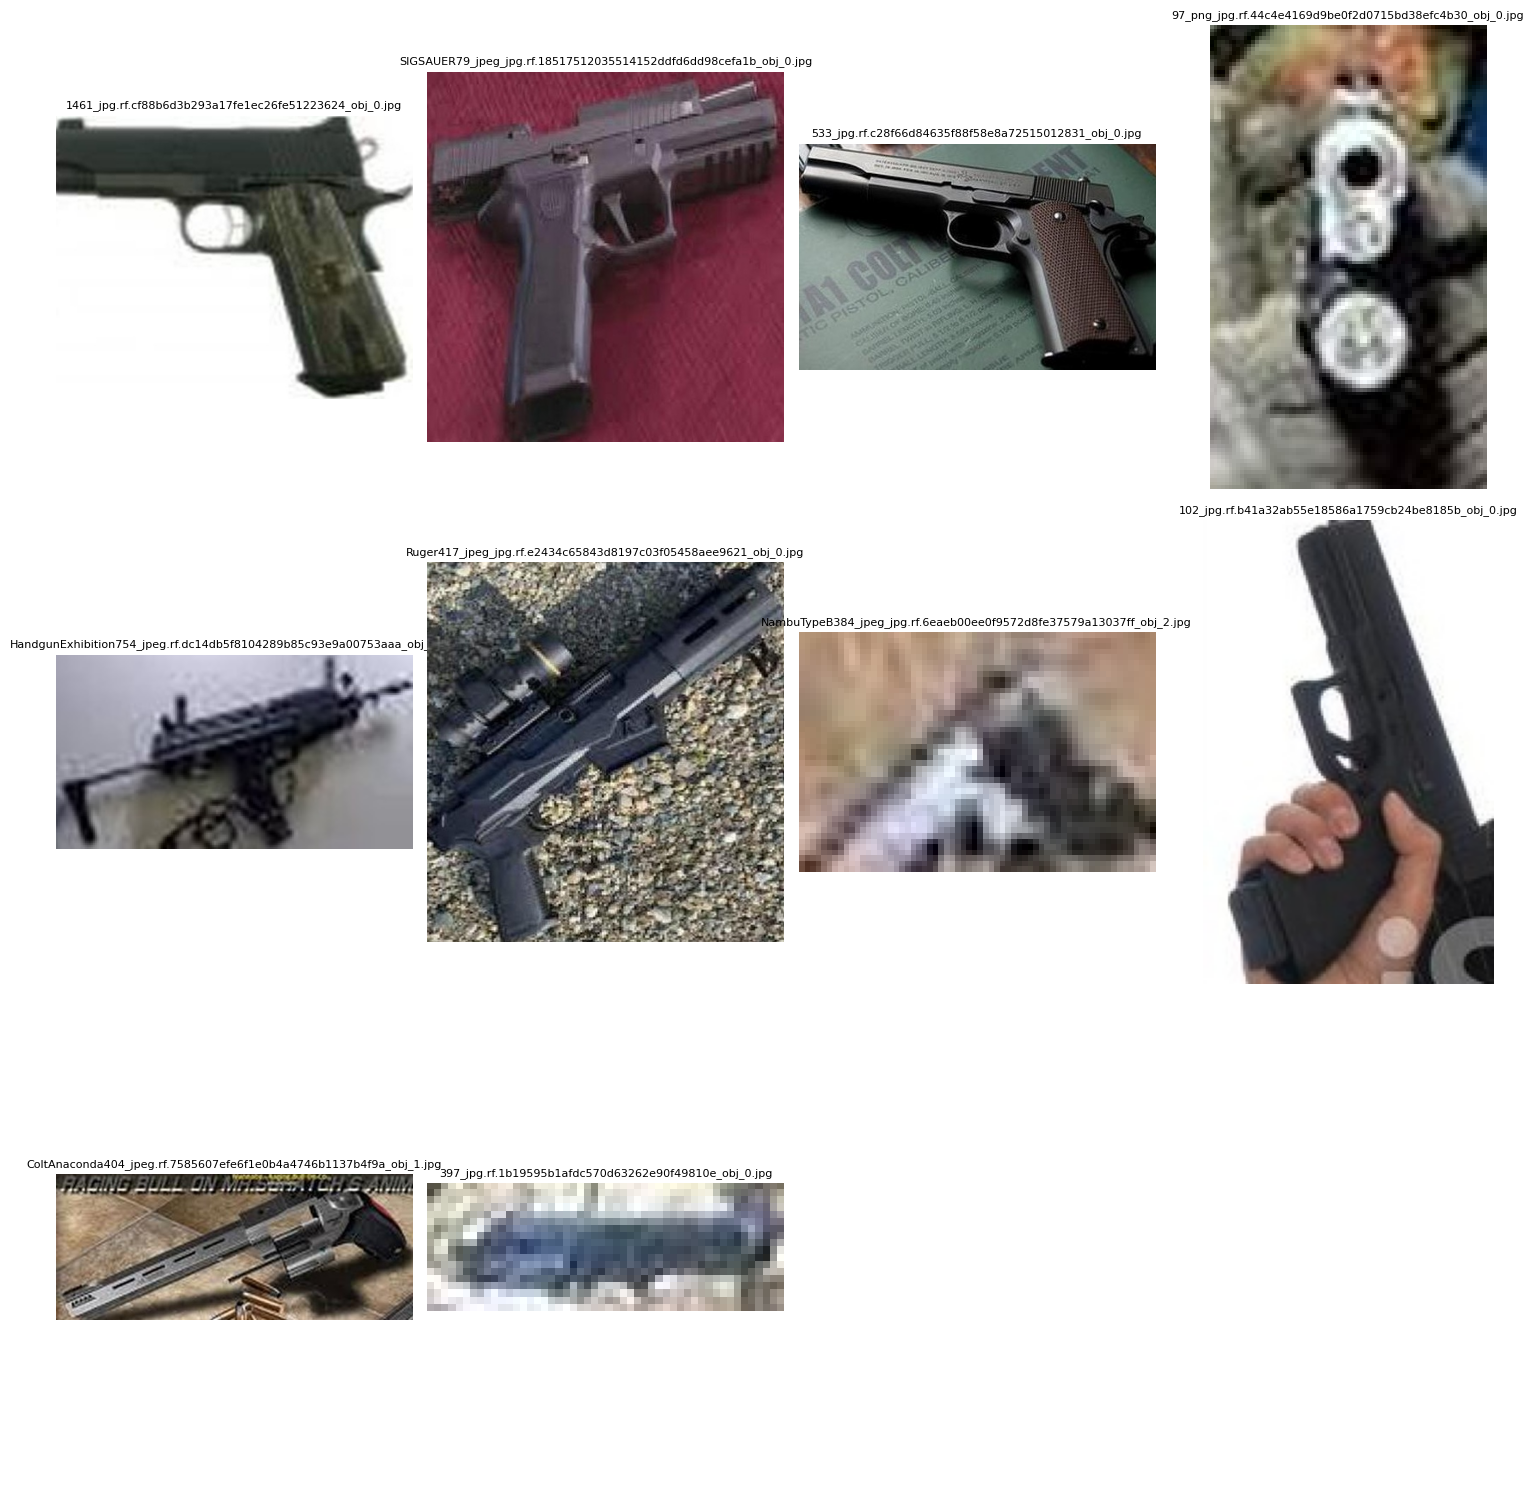

In [24]:
image_folder_path = '/content/isolate_objects/0'
display_multiple_images(image_folder_path, num_images=10)

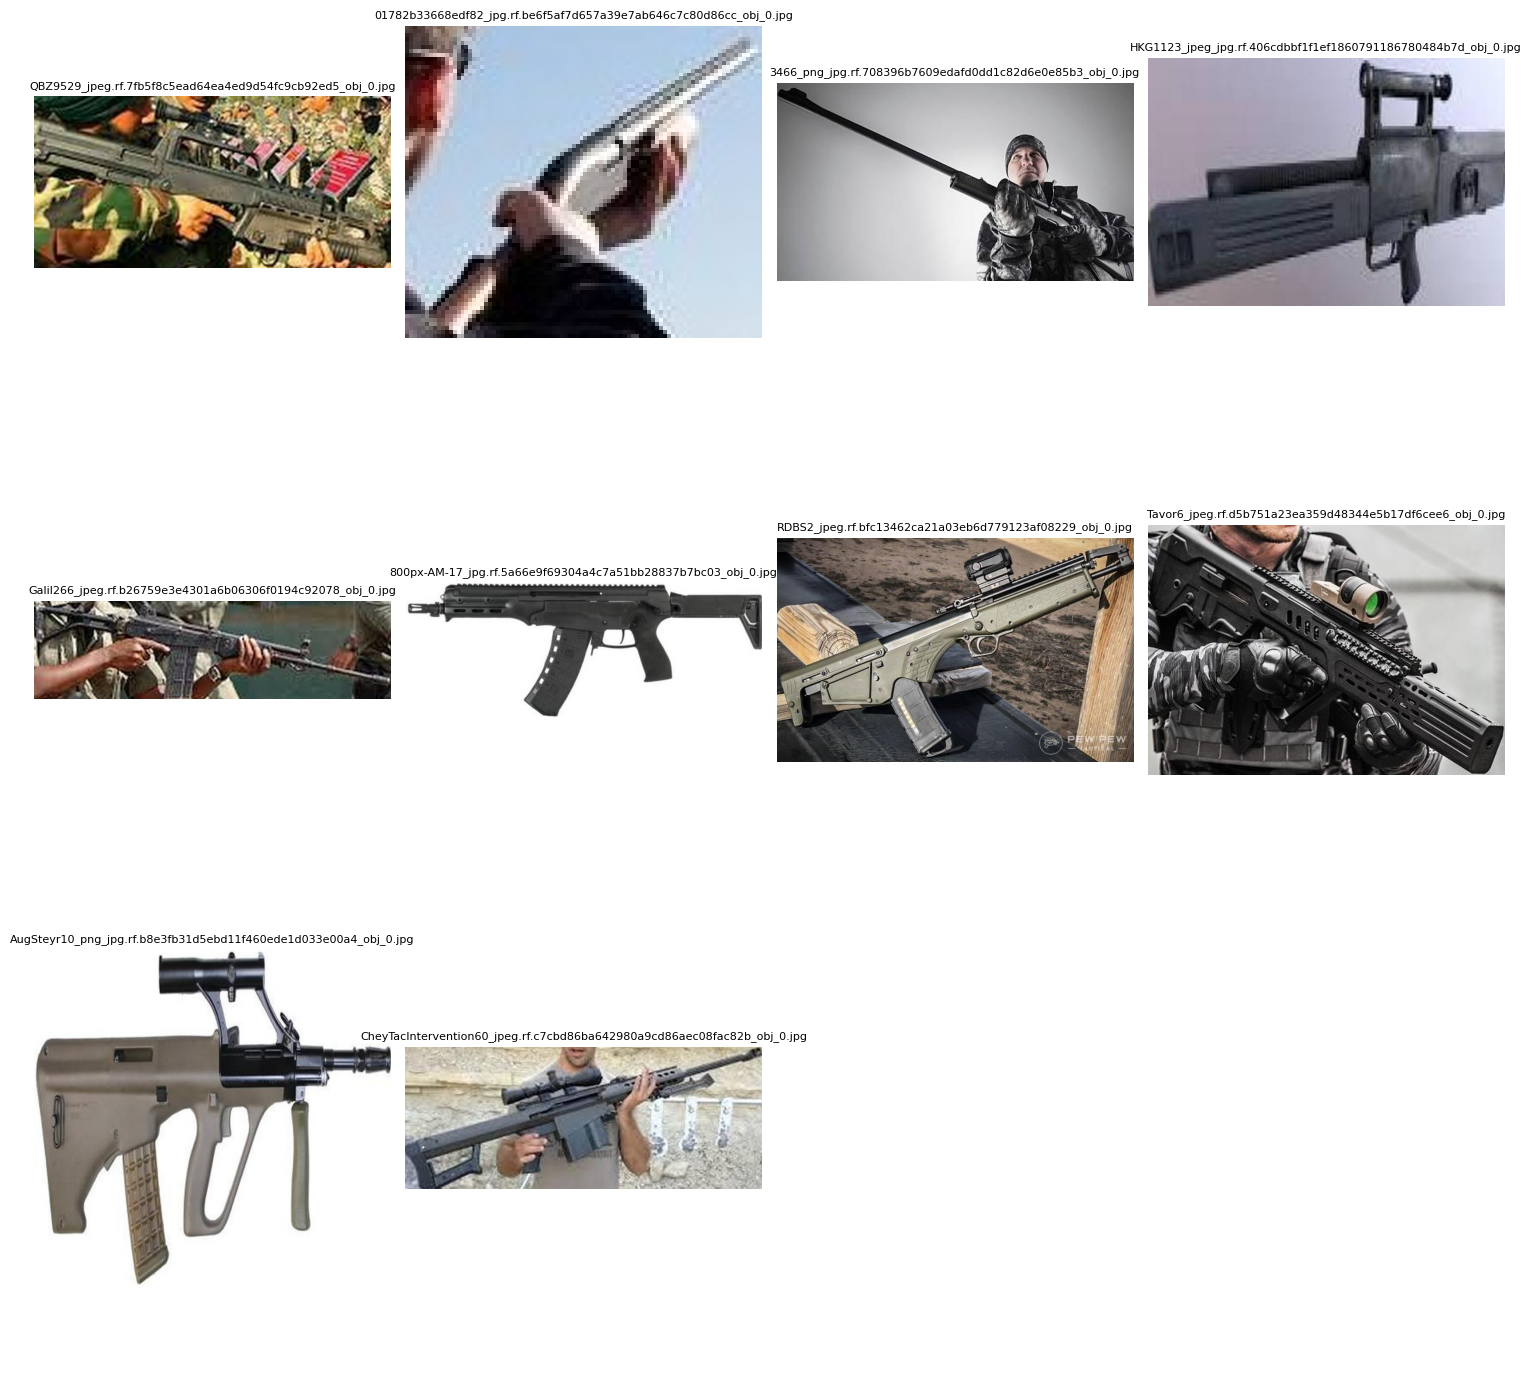

In [25]:
image_folder_path = '/content/isolate_objects/1'
display_multiple_images(image_folder_path, num_images=10)

Но у данного метода есть существенный недостаток - разрешение изображения меняется в зависимости от размера бибокса. Для решения данной проблемы проведем изоляцию бибокса в отдельное изображение с добавлением окамления бибокса из изображения и ресайзинга с паддингом (добавление черных полос) до разрешения 640х640

In [43]:
%%capture
import glob
from typing import List, Optional, Tuple
from collections import Counter


def convert_yolo_to_coords(
    yolo_box: List[float],
    img_width: int,
    img_height: int
) -> Tuple[int, int, int, int]:
    """
    Преобразуем нормализованные координаты лейблов YOLO в фиксированные пиксельные координаты (х-мин, у-мин; х_мах, у-мах)
    """
    x_center, y_center, width, height = yolo_box

    x_min = int(round((x_center - width / 2) * img_width))
    y_min = int(round((y_center - height / 2) * img_height))
    x_max = int(round((x_center + width / 2) * img_width))
    y_max = int(round((y_center + height / 2) * img_height))

    # Прикрепим к границам изображения
    x_min = max(0, min(x_min, img_width - 1))
    y_min = max(0, min(y_min, img_height - 1))
    x_max = max(0, min(x_max, img_width - 1))
    y_max = max(0, min(y_max, img_height - 1))


    if x_max <= x_min or y_max <= y_min:
        return 0, 0, 0, 0

    return x_min, y_min, x_max, y_max


def resize_with_padding_to_square(
    image,
    target_size: int = 640,
    pad_color: Tuple[int, int, int] = (114, 114, 114)
):
    """
   Формат Letterbox превращается в квадрат заданного размера с сохранением пропорций.
    """
    h, w = image.shape[:2]
    scale = min(target_size / h, target_size / w)
    new_w = max(1, int(round(w * scale)))
    new_h = max(1, int(round(h * scale)))

    interp = cv2.INTER_AREA if scale < 1.0 else cv2.INTER_LINEAR
    resized = cv2.resize(image, (new_w, new_h), interpolation=interp)


    canvas = cv2.copyMakeBorder(
        resized,
        top=(target_size - new_h) // 2,
        bottom=target_size - new_h - (target_size - new_h) // 2,
        left=(target_size - new_w) // 2,
        right=target_size - new_w - (target_size - new_w) // 2,
        borderType=cv2.BORDER_CONSTANT,
        value=pad_color
    )
    return canvas


def find_image_for_basename(image_dir: str, base_name: str) -> Optional[str]:
    """
   Поиск файлов изображений по базовому имени с распространёнными расширениями.
    """
    exts = ["jpg", "jpeg", "png", "bmp", "tif", "tiff", "webp"]
    for ext in exts:
        candidate = os.path.join(image_dir, f"{base_name}.{ext}")
        if os.path.exists(candidate):
            return candidate
    # Резервный вариант: выполнить поиск по базовому имени с любым расширением в каталоге image_dir
    matches = glob.glob(os.path.join(image_dir, f"{base_name}.*"))
    return matches[0] if matches else None


def crop_objects_from_labels(
    image_dir: str,
    labels_dir: str,
    output_dir: str,
    target_size: int = 640
) -> None:
    """
Извлечение объектов из изображений с помощью меток YOLO и сохранение изображений.
Размер изменен до target_size x target_size (в формате Letterbox).
    """
    os.makedirs(output_dir, exist_ok=True)

    label_paths = [p for p in glob.glob(os.path.join(labels_dir, "*.txt")) if os.path.isfile(p)]
    if not label_paths:
        print(f"Нет .txt меток в {labels_dir}")
        return

    for label_path in sorted(label_paths):
        base_name = os.path.splitext(os.path.basename(label_path))[0]
        image_path = find_image_for_basename(image_dir, base_name)

        if not image_path:
            print(f"Изображение не найдено для {base_name}, пропуск.")
            continue

        image = cv2.imread(image_path)
        if image is None:
            print(f"Не удалось загрузить изображение {image_path}, пропуск.")
            continue

        img_height, img_width = image.shape[:2]

        with open(label_path, "r", encoding="utf-8") as f:
            lines = [ln.strip() for ln in f if ln.strip()]

        if not lines:
            print(f"Метки пусты для {label_path}, пропуск.")
            continue

        for i, line in enumerate(lines):
            try:
                parts = list(map(float, line.split()))
                if len(parts) < 5:
                    print(f"Некорректная строка метки в {label_path}: '{line}', пропуск.")
                    continue
                class_id = int(parts[0])
                yolo_box = parts[1:5]
            except Exception:
                print(f"Ошибка парсинга строки метки в {label_path}: '{line}', пропуск.")
                continue

            x_min, y_min, x_max, y_max = convert_yolo_to_coords(yolo_box, img_width, img_height)

            # Пропустим недействительные или пустые ячейки
            if x_max <= x_min or y_max <= y_min:
                print(f"Объект в {label_path} с индексом {i} имеет некорректные координаты. Пропуск.")
                continue

            cropped = image[y_min:y_max, x_min:x_max]
            if cropped.size == 0:
                print(f"Пустой кроп в {label_path} (индекс {i}). Пропуск.")
                continue

            # Изменить размер до 640x640 (используем формат Letterbox для сохранения соотношения сторон)
            cropped_640 = resize_with_padding_to_square(cropped, target_size)

            class_output_dir = os.path.join(output_dir, str(class_id))
            os.makedirs(class_output_dir, exist_ok=True)

            out_name = f"{base_name}_obj_{i}.jpg"
            out_path = os.path.join(class_output_dir, out_name)

            success = cv2.imwrite(out_path, cropped_640)
            if success:
                print(f"Сохранён объект {i} из {os.path.basename(label_path)} как {out_path}")
            else:
                print(f"Не удалось сохранить {out_path}")


if __name__ == "__main__":
    # укажем путь
    images_folder = "/content/test_640x640/images"
    labels_folder = "/content/test_640x640/labels"
    output_folder = "./isolate_640x640"

    crop_objects_from_labels(images_folder, labels_folder, output_folder, target_size=640)

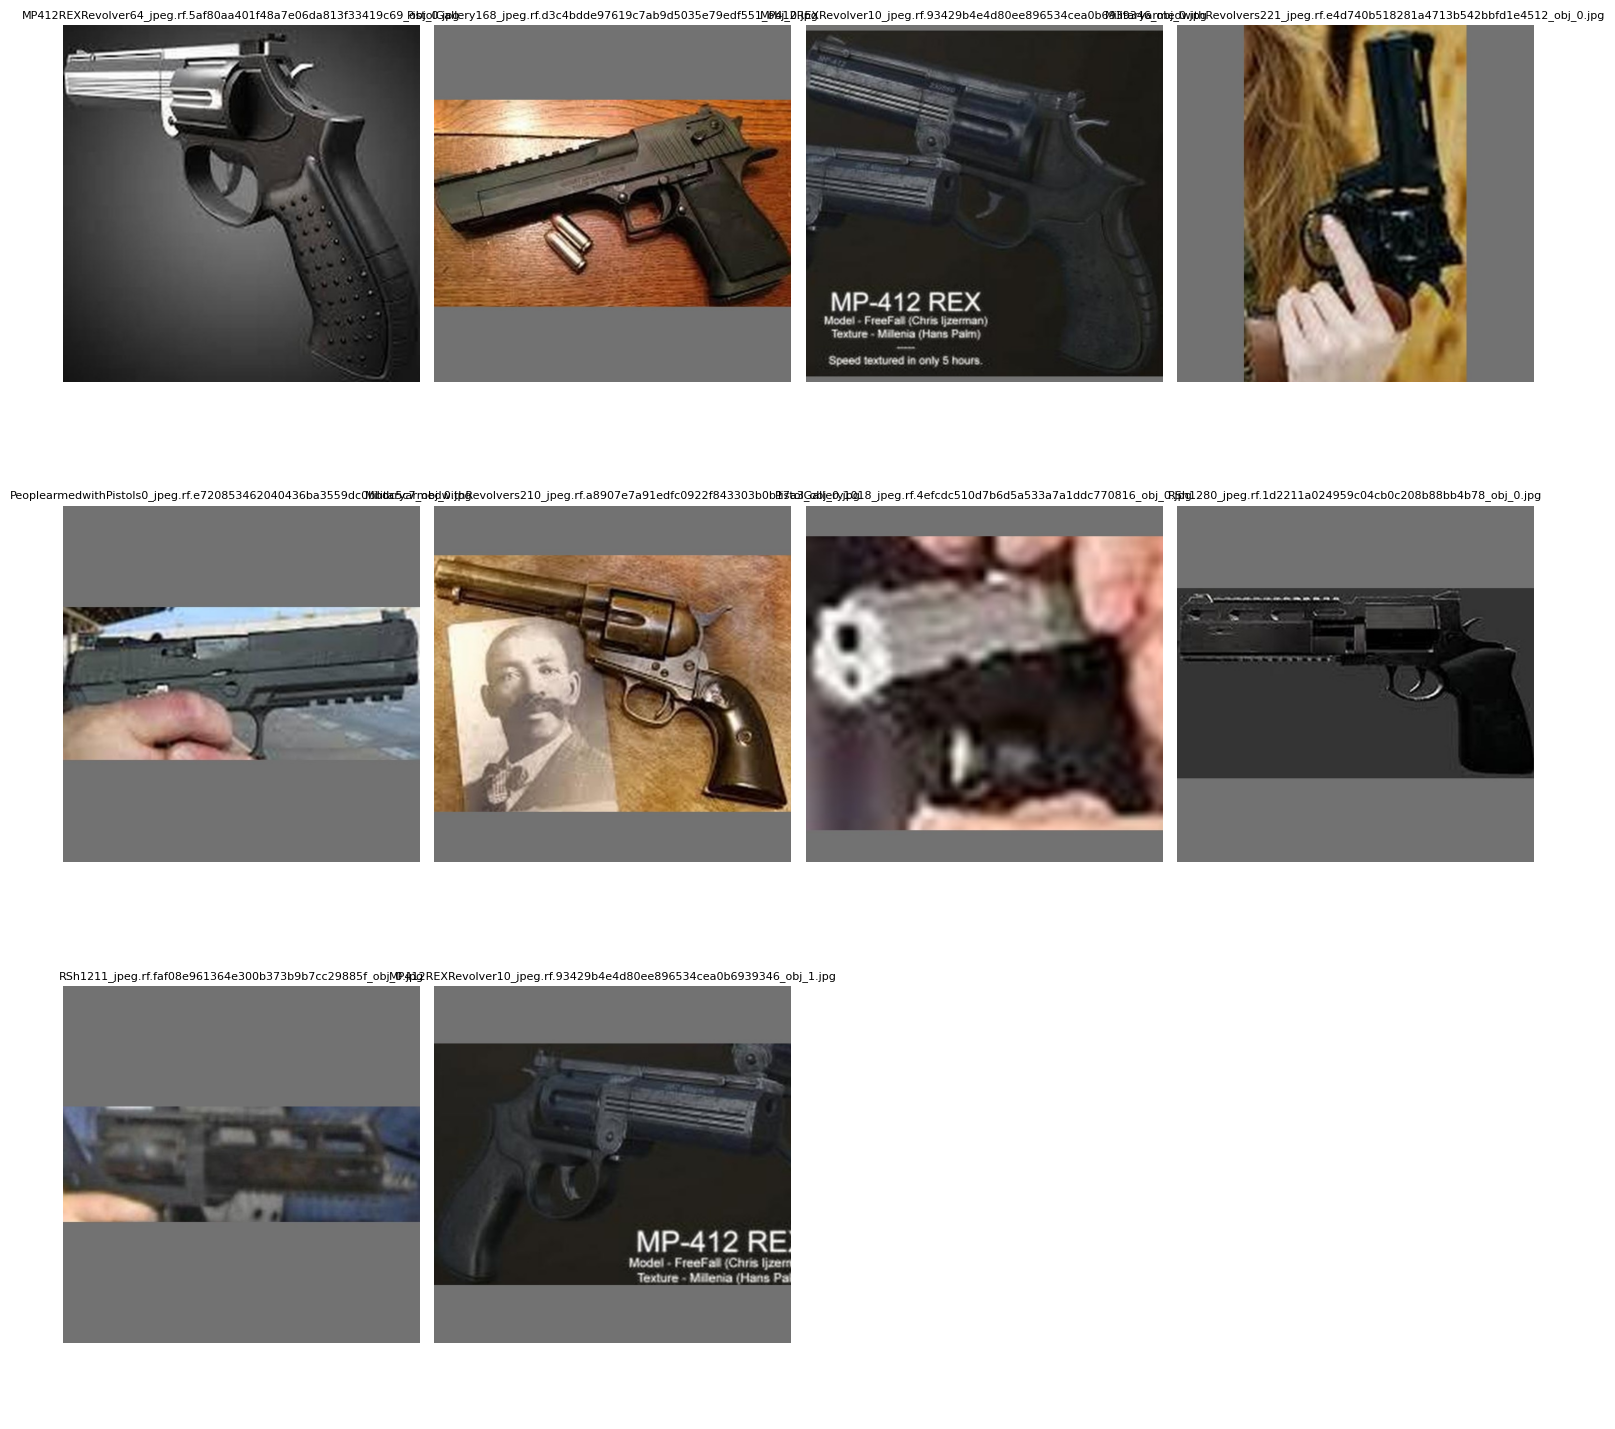

In [27]:
image_folder_path = '/content/isolate_640x640/0'
display_multiple_images(image_folder_path, num_images=10)

Выберем несколько видов аугментации и проведем ее:
- вертикальное отражение (стандартная аугиентация для большинства случаев)
- горизонтальное отражение
- поворот на случайный угол
- при детекции возможны солнечные блики в солнечную погоду
- добавление тени
- при детекции возможны брызги дождя

In [44]:

%%capture
import albumentations as A

# укажем путь
DATASET_PATH = '/content/train_640x640'
IMAGES_INPUT_DIR = os.path.join(DATASET_PATH, 'images')
LABELS_INPUT_DIR = os.path.join(DATASET_PATH, 'labels')

# путь для аугментированных изображений и лейблов к ним
AUGMENTED_IMAGES_DIR = os.path.join(DATASET_PATH, 'augmented_images')
AUGMENTED_LABELS_DIR = os.path.join(DATASET_PATH, 'augmented_labels')

# Создаем папки для сохраненият
os.makedirs(AUGMENTED_IMAGES_DIR, exist_ok=True)
os.makedirs(AUGMENTED_LABELS_DIR, exist_ok=True)

# Настройка аугментаций
# Здесь мы выбираем и настраиваем нужные нам аугментации
# (список всех доступных аугментаций есть в документации albumentations)
augmentor = A.Compose([
    # Вертикальное отражение
    A.VerticalFlip(p=0.5),
    # Горизонтальное отражение
    A.HorizontalFlip(p=0.5),
    # Поворот на случайный угол
    A.Rotate(limit=15, p=0.5),
    # При детекции возможны солнечные блики в солнечную погоду
    A.RandomSunFlare(p=0.2),
    # Добавление тени
    A.RandomShadow(p=0.2),
    # При детекции возможны брызги дождя
    A.Spatter(p=0.3),
], bbox_params=A.BboxParams(format='yolo', label_fields=['class_labels']))

# Аугментация данных
image_files = os.listdir(IMAGES_INPUT_DIR)

# укажем количество аугментированных копий для каждого изображения
augmentation_factor = 2

for image_name in image_files:
    # Загружаем оригинальное изображение
    image_path = os.path.join(IMAGES_INPUT_DIR, image_name)
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Загружаем аннотации
    label_path = os.path.join(LABELS_INPUT_DIR, image_name.replace('.jpg', '.txt').replace('.png', '.txt'))

    bboxes = []
    class_labels = []
    if os.path.exists(label_path):
        with open(label_path, 'r') as f:
            for line in f.readlines():
                parts = line.strip().split()
                if len(parts) == 5:
                    class_id, x_center, y_center, width, height = map(float, parts)
                    bboxes.append([x_center, y_center, width, height])
                    class_labels.append(int(class_id))

    # Применяем аугментацию несколько раз
    for i in range(augmentation_factor):
        try:
            # Применяем трансформации
            augmented = augmentor(image=image, bboxes=bboxes, class_labels=class_labels)

            # Получаем аугментированное изображение и аннотации
            aug_image = augmented['image']
            aug_bboxes = augmented['bboxes']
            aug_labels = augmented['class_labels']

            # Формируем новое имя файла
            base_name = os.path.splitext(image_name)[0]
            new_image_name = f"{base_name}_aug_{i}.jpg"
            new_label_name = f"{base_name}_aug_{i}.txt"

            # Сохраняем новое изображение
            aug_image_bgr = cv2.cvtColor(aug_image, cv2.COLOR_RGB2BGR)
            cv2.imwrite(os.path.join(AUGMENTED_IMAGES_DIR, new_image_name), aug_image_bgr)

            # Сохраняем новые аннотации
            with open(os.path.join(AUGMENTED_LABELS_DIR, new_label_name), 'w') as f:
                for j, bbox in enumerate(aug_bboxes):
                    class_id = aug_labels[j]
                    x_c, y_c, w, h = bbox
                    f.write(f"{class_id} {x_c:.6f} {y_c:.6f} {w:.6f} {h:.6f}\n")
        except Exception as e:
            print(f"Ошибка при аугментации изображения {image_name} (итерация {i}): {e}")
            continue

print("Аугментация завершена.")

Возникает ошибка с координтами бибокса, но она не влияет на аугментацию. В дальнейшем планирую разобраться с данной ошибкой

Теперь выгрузим и сохраним в архиве наш датасет

In [45]:
%%capture
!zip -r combined_output.zip isolate_objects/ test_640x640/ train_640x640/ valid_640x640/

In [46]:
from google.colab import files
files.download('combined_output.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Скачала предобработанный датасет, его объем составляет 5 086 125 кб